In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm_notebook as tqdm
from cycler import cycler

In [2]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 26
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CF353C', '#FFE3A6',
#                                                 '#727272'])

In [3]:
mpl.rcParams['axes.prop_cycle']

cycler('color', ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])

# Data Extraction

In [4]:
df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])
df.head()

Order Date   Brand                                   Sneaker Name  \
0 2017-09-01   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1 2017-09-01   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2 2017-09-01   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3 2017-09-01   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4 2017-09-01   Yeezy  Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017   

   Sale Price  Retail Price Release Date  Shoe Size  Buyer Region  
0      1097.0           220   2016-09-24       11.0    California  
1       685.0           220   2016-11-23       11.0    California  
2       690.0           220   2016-11-23       11.0    California  
3      1075.0           220   2016-11-23       11.5      Kentucky  
4       828.0           220   2017-02-11       11.0  Rhode Island

# Exploratory Data Analysis

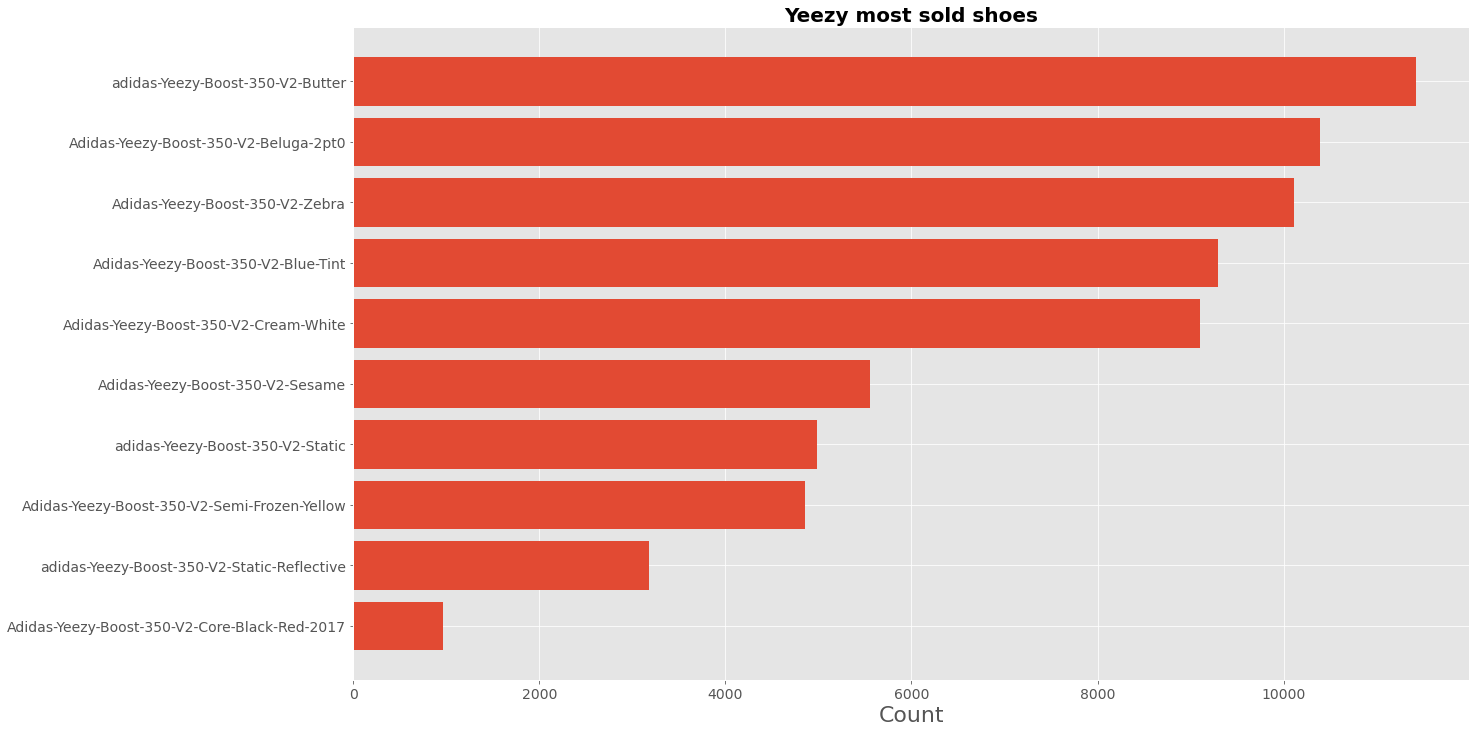

In [14]:
freq_shoes = (df.loc[df.Brand == ' Yeezy'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))

freq_shoes.sort_values(by=0, inplace=True, ascending=True)

plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0])
plt.xlabel('Count')
# plt.xlim(900)
plt.title('Yeezy most sold shoes')
plt.show()
# del freq_shoes

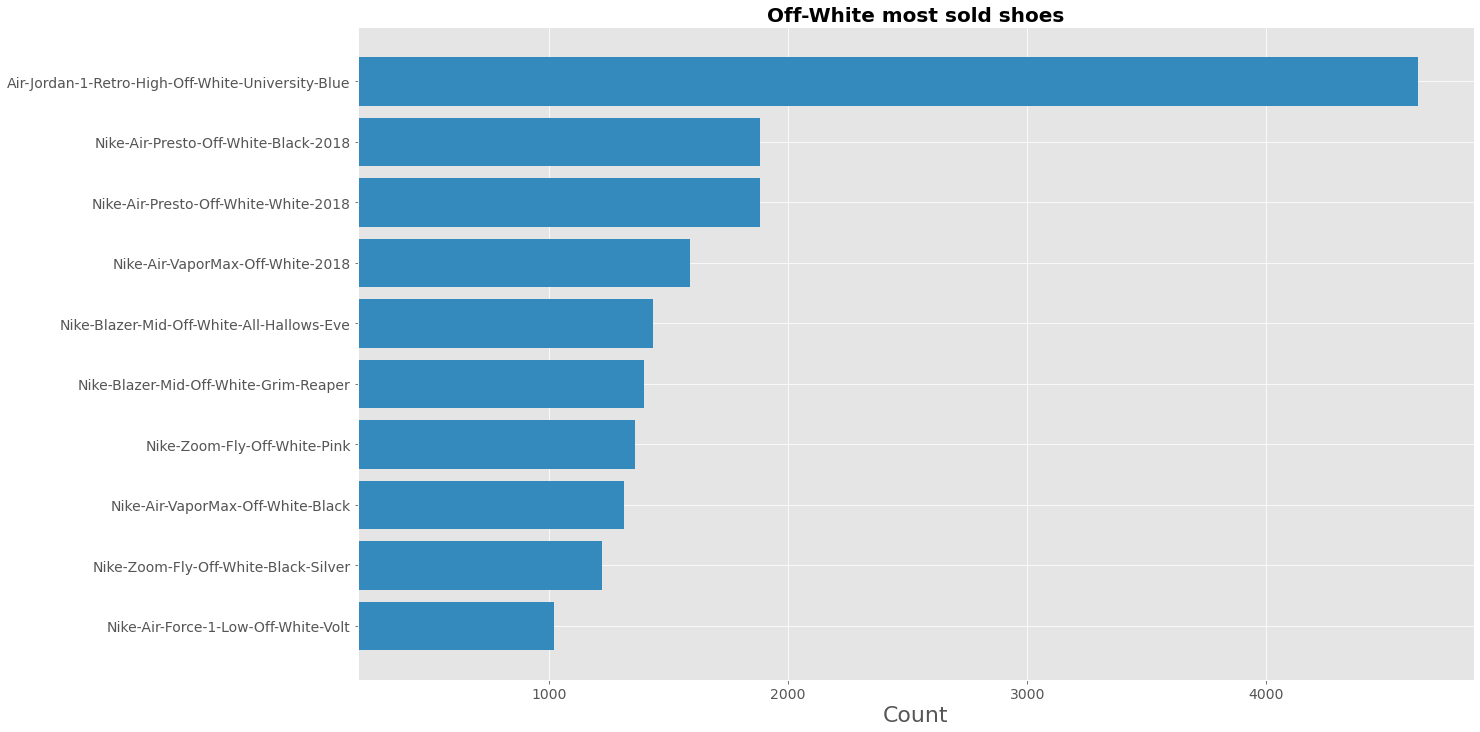

In [13]:
freq_shoes = (df.loc[df.Brand == 'Off-White'].groupby(['Sneaker Name'])
              .size().nlargest(10).reset_index().sort_values(by=0))

# freq_shoes['Variant'] = (freq_shoes['Sneaker Name'].astype(str)
#                          + '_' + freq_shoes['Shoe Size'].astype(str))
freq_shoes.sort_values(by=0, inplace=True)
plt.figure(figsize=(20, 12))
plt.barh(freq_shoes['Sneaker Name'], width=freq_shoes[0], color='#348ABD')
plt.xlabel('Count')
plt.xlim(200)
plt.title('Off-White most sold shoes')
plt.show()

In [16]:
def get_shoes(name, size=None):
    """Get data for shoes, all shoe size if size is None"""
    if size is None:
        return df.loc[df['Sneaker Name'] == name].copy()
    else:
        m1 = df['Sneaker Name'] == name
        m2 = df['Shoe Size'] == size
        return df.loc[m1 & m2].copy()

## Yeezy Beluga Size 10

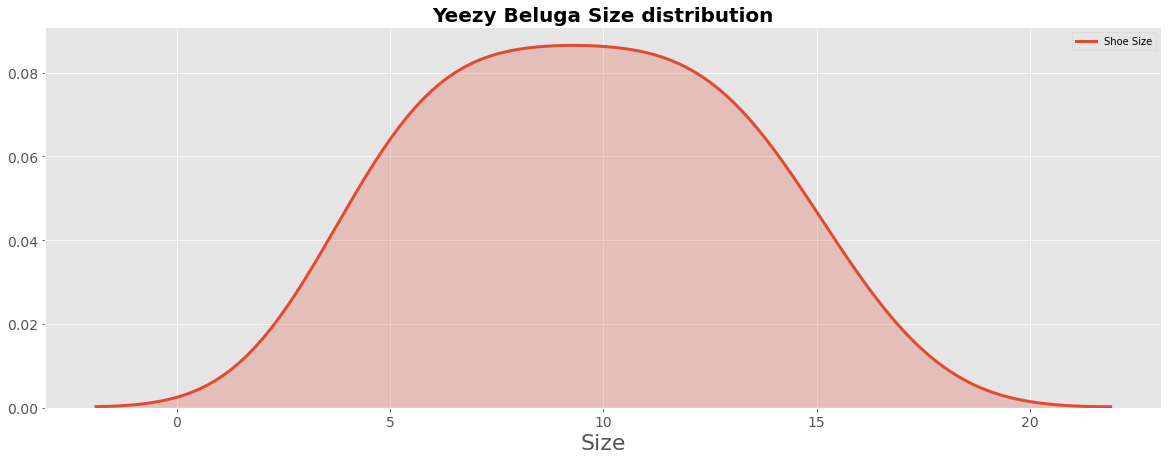

In [27]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True)

ymean = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0')['Shoe Size'].mean()
plt.title('Yeezy Beluga Size distribution')
plt.xlabel('Size');

In [29]:
yeezy_beluga_10 = get_shoes('Adidas-Yeezy-Boost-350-V2-Beluga-2pt0', 10)

Number of sold dates for size 10:  340


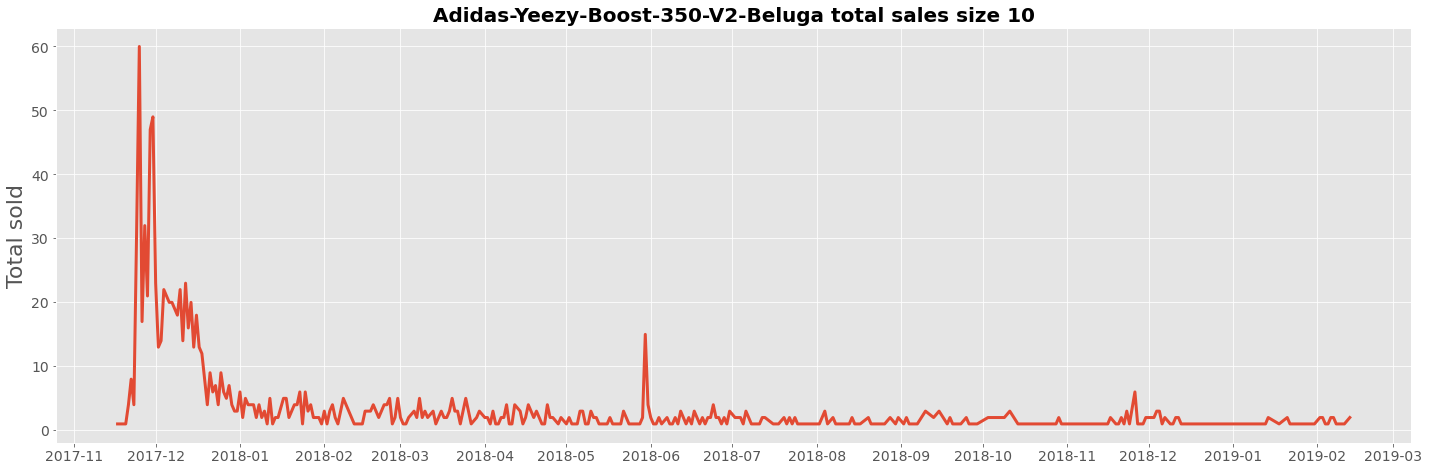

In [30]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10['Order Date'].value_counts().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga total sales size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  340


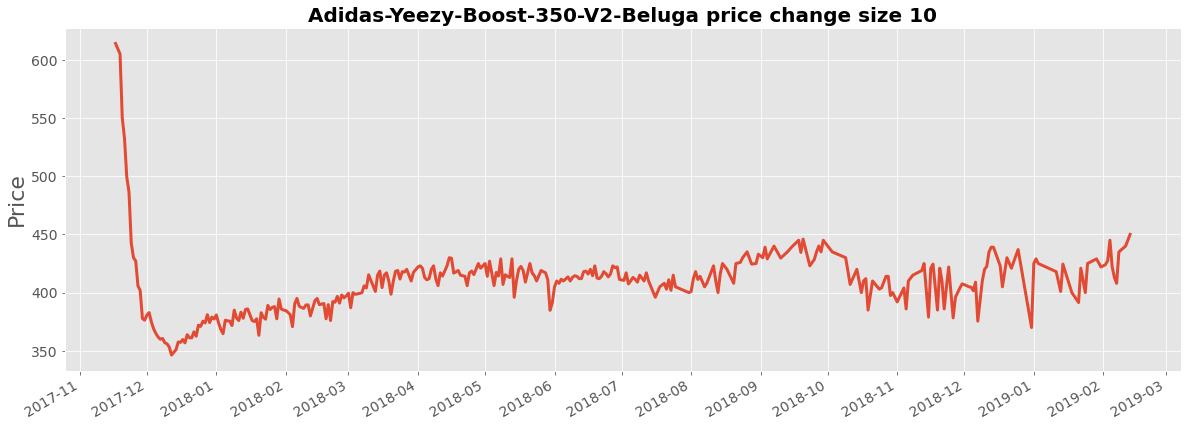

In [31]:
print('Number of sold dates for size 10: ',
      yeezy_beluga_10['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
        .mean().sort_index())
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
fig.autofmt_xdate()

plt.show()

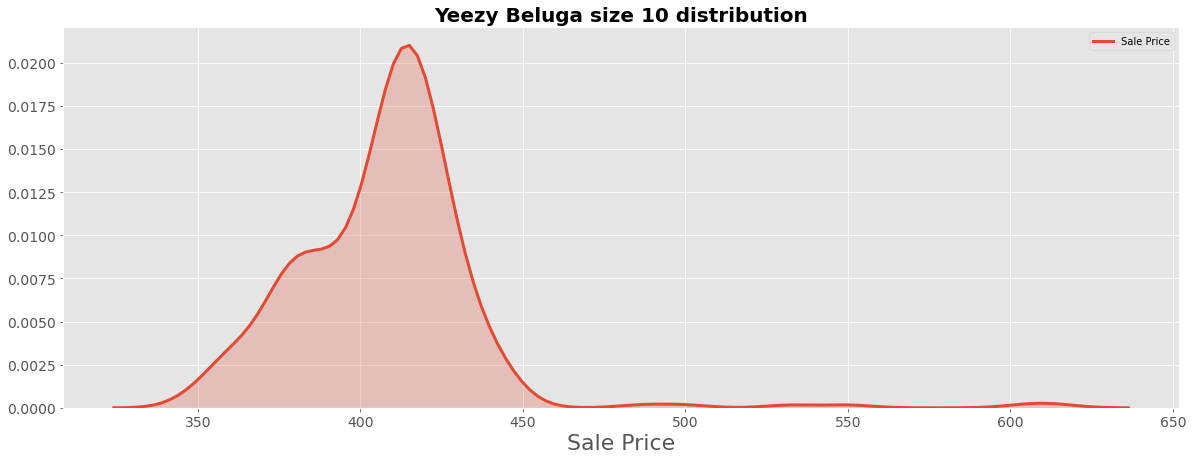

In [32]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(yeezy_beluga_10.groupby('Order Date')['Sale Price']
            .mean().sort_index(), shade=True)
plt.title('Yeezy Beluga size 10 distribution')
plt.xlabel('Sale Price');

## Jordan 1 Retro University Blue Size 9

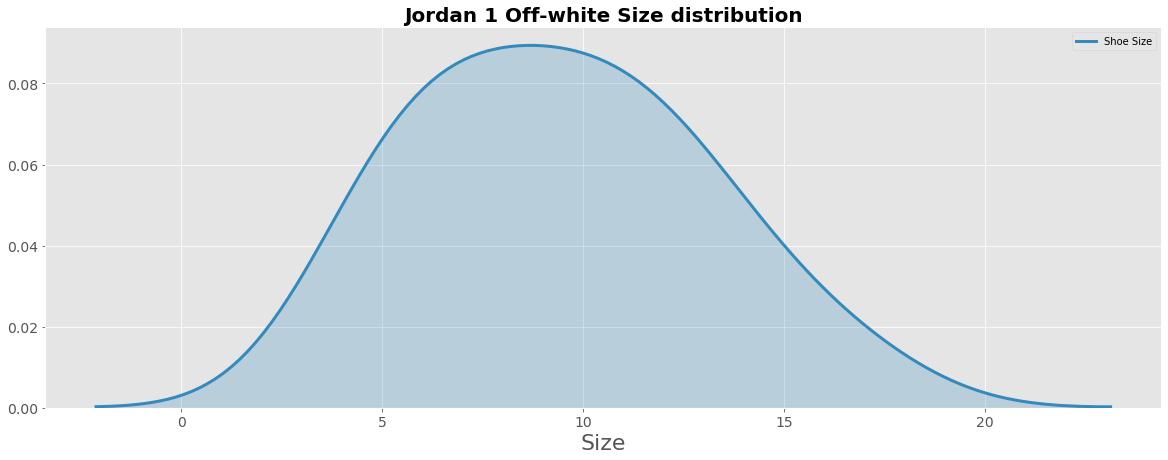

In [33]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(get_shoes('Air-Jordan-1-Retro-High-Off-White-University-Blue')
            .groupby('Shoe Size')['Shoe Size']
            .mean().sort_index(), shade=True, color='#348ABD')
plt.title('Jordan 1 Off-white Size distribution')
plt.xlabel('Size');

In [21]:
jordan1_uni_blue_9 = get_shoes(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue', 9)

Number of sold dates for size 10:  108


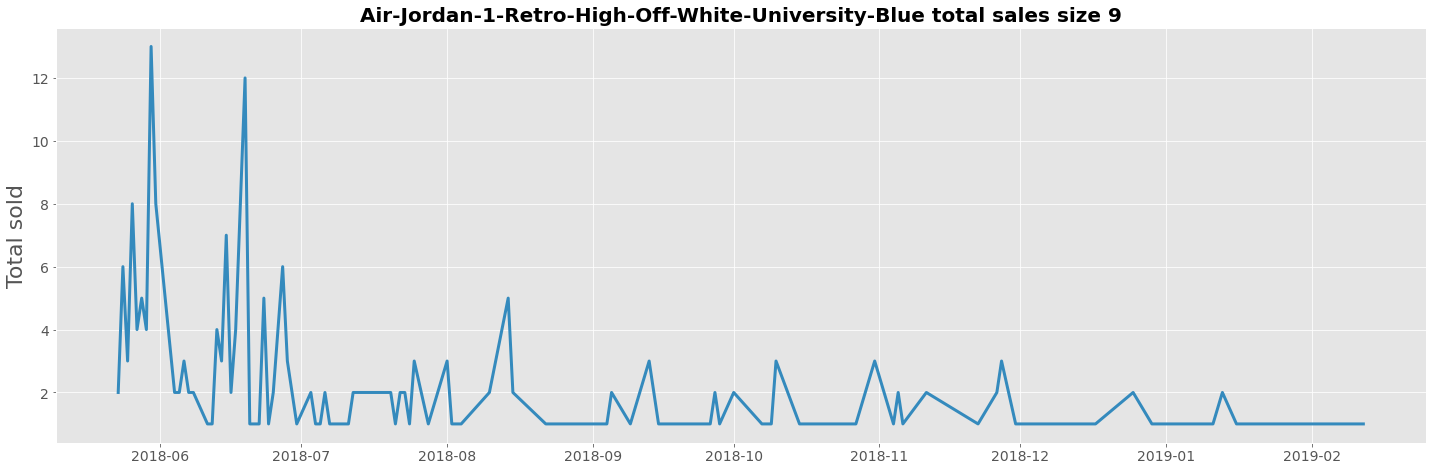

In [22]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9['Order Date'].value_counts().sort_index(),
        color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Total sold')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue total '
          'sales size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Number of sold dates for size 10:  108


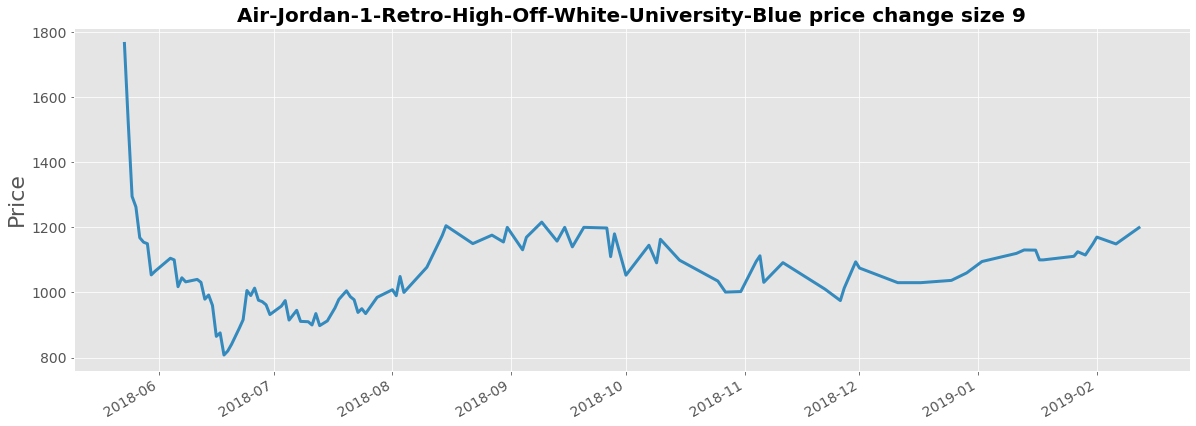

In [13]:
print('Number of sold dates for size 10: ',
      jordan1_uni_blue_9['Order Date'].nunique())

fig, ax = plt.subplots(figsize=(20, 7), sharex=True)
ax.plot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.title('Air-Jordan-1-Retro-High-Off-White-University-Blue '
          'price change size 9')
fig.autofmt_xdate()

plt.show()

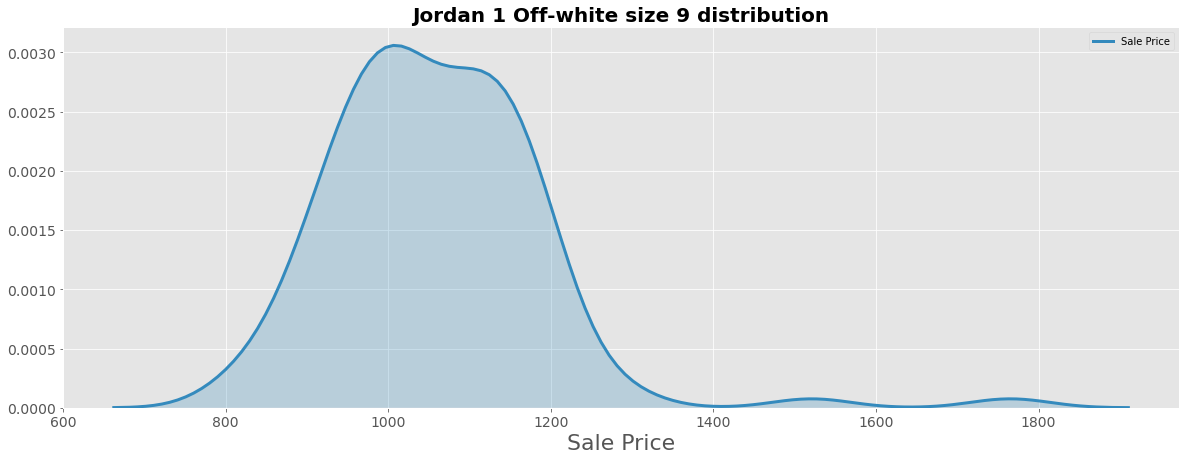

In [35]:
fig, ax1 = plt.subplots(figsize=(20, 7), sharex=True)
sns.kdeplot(jordan1_uni_blue_9.groupby('Order Date')['Sale Price']
            .mean().sort_index(),
            color='#348ABD',
            shade=True)
plt.title('Jordan 1 Off-white size 9 distribution')
plt.xlabel('Sale Price');

# REGRESSION MODELS

# Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint

Sneaker Name is ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
    - Accuracy dropped even further after limiting dataset to shoe size 10 (best R2 0.5797)
        - Previously best R2 0.8032 for dtaaset with shoe sizes 9, 10, and 11
    - Extra Trees best for 7-day prediction
    - CatBoost best for 30-day prediction
    - TheilSen Net best for 90-day prediction

## Data Processing and EDA

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from datetime import timedelta
from cycler import cycler

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [3]:
#from cycler import cycler
#plt.style.use('dark_background')
#plt.style.use('dark_background')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

In [4]:
CUTOFF_TRAINMIN = '2018-01-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


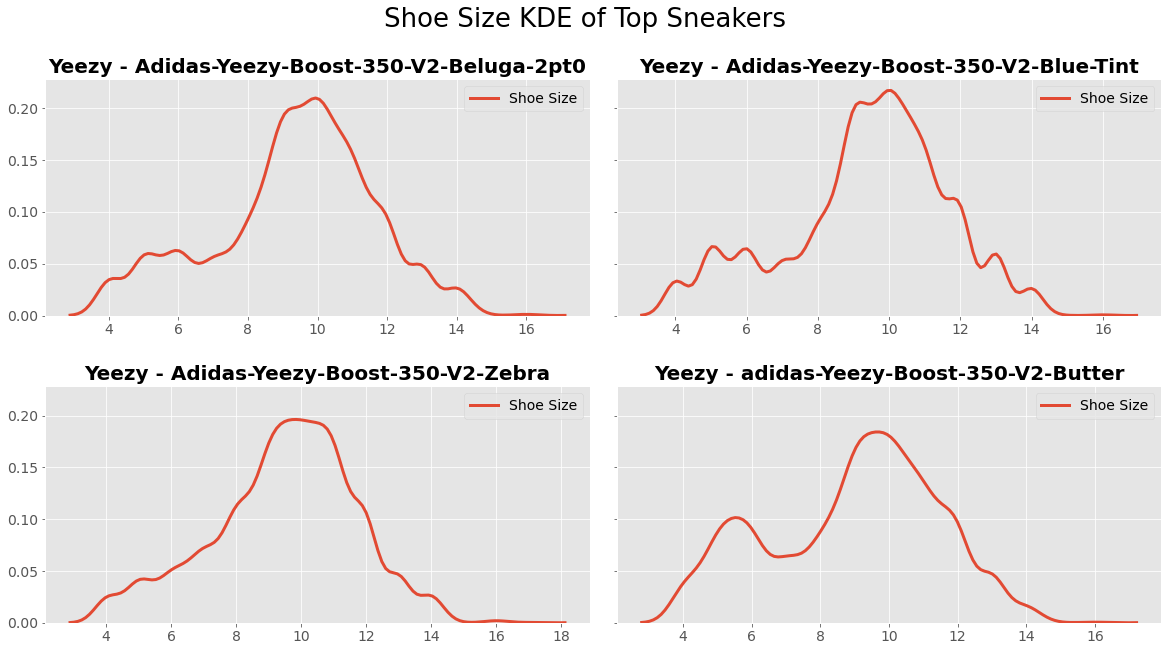

In [6]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

In [7]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [8]:
sneaker_name = ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint'
df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                  Sneaker Name  Shoe Size  \
0   2017-12-13   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
1   2017-12-14   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
2   2017-12-15   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
3   2017-12-16   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
4   2017-12-17   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
..         ...                                           ...        ...   
315 2019-02-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
316 2019-02-07   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
317 2019-02-09   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
318 2019-02-10   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   
319 2019-02-11   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint       10.0   

     Sale Price  DaysStored  
0    448.500000          -3  
1    396.000000          -2  
2    366.785714          -1  
3    379.837209           0  
4    387.578947           1  
..          ...         ...  
315  349.000000         416  
316  339.500000         418  
317  362.000000         420  
318  363.333333         421  
319  381.000000         422  

[320 rows x 5 columns]

In [9]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(407, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-01-01  2018-01-01  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1 2018-01-02  2018-01-02  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2 2018-01-03  2018-01-03  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3 2018-01-04  2018-01-04  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4 2018-01-05  2018-01-05  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb30  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb60  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...  2018-01-15  2018-01-30   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...  2018-01-16  2018-01-31   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...  2018-01-17  2018-02-01   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...  2018-01-18  2018-02-02   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...  2018-01-19  2018-02-03   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-03-01  2018-06-29  2018-01-23  2018-02-07  2018-03-09  2018-04-01   
1  2018-03-02  2018-06-30  2018-01-24  2018-02-08  2018-03-10  2018-04-02   
2  2018-03-03  2018-07-01  2018-01-25  2018-02-09  2018-03-11  2018-04-03   
3  2018-03-04  2018-07-02  2018-01-26  2018-02-10  2018-03-12  2018-04-04   
4  2018-03-05  2018-07-03  2018-01-27  2018-02-11  2018-03-13  2018-04-05   

  lb180_plus90  
0   2018-09-28  
1   2018-09-29  
2   2018-09-30  
3   2018-10-01  
4   2018-10-02

In [10]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (407, 3)
df_tmp.shape (407, 5)


dt_str                                  Sneaker Name  Shoe Size  \
0  2018-01-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
1  2018-01-02   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
2  2018-01-03   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
3  2018-01-04   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   
4  2018-01-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint         10   

   Sale Price  DaysStored  
0  353.888889        16.0  
1  351.812500        17.0  
2  348.600000        18.0  
3  348.166667        19.0  
4  348.285714        20.0

In [11]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 407)
0    10
Name: Shoe Size, dtype: int64


In [12]:
pvt_price

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10  353.888889    351.8125       348.6  348.166667  348.285714   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-02  \
0            349.0     347.625      348.25       345.8  ...       353.5   

dt_str  2019-02-03  2019-02-04  2019-02-05  2019-02-06  2019-02-07  \
0            353.5       337.5       349.0       349.0       339.5   

dt_str  2019-02-08  2019-02-09  2019-02-10  2019-02-11  
0            339.5       362.0  363.333333       381.0  

[1 rows x 408 columns]

In [13]:
pvt_price_diff

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10         NaN   -2.076389     -3.2125   -0.433333    0.119048   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-02  \
0         0.714286      -1.375       0.625       -2.45  ...         0.0   

dt_str  2019-02-03  2019-02-04  2019-02-05  2019-02-06  2019-02-07  \
0              0.0       -16.0        11.5         0.0        -9.5   

dt_str  2019-02-08  2019-02-09  2019-02-10  2019-02-11  
0              0.0        22.5    1.333333   17.666667  

[1 rows x 408 columns]

In [14]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

## Regression

In [15]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

### Models List

In [16]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [17]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(296, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1           2  \
0             1  359.875000       16.0       38.0  353.888889  351.812500   
0             1  355.000000       17.0       39.0  351.812500  348.600000   
0             1  357.909091       18.0       40.0  348.600000  348.166667   
0             1  345.000000       19.0       41.0  348.166667  348.285714   
0             1  357.250000       20.0       42.0  348.285714  349.000000   

            3           4           5        6           7           8  \
0  348.600000  348.166667  348.285714  349.000  347.625000  348.250000   
0  348.166667  348.285714  349.000000  347.625  348.250000  345.800000   
0  348.285714  349.000000  347.625000  348.250  345.800000  351.750000   
0  349.000000  347.625000  348.250000  345.800  351.750000  350.666667   
0  347.625000  348.250000  345.800000  351.750  350.666667  348.000000   

            9          10          11          12          13          14  \
0  345.800000  351.750000  350.666667  348.000000  349.000000  352.000000   
0  351.750000  350.666667  348.000000  349.000000  352.000000  349.500000   
0  350.666667  348.000000  349.000000  352.000000  349.500000  346.666667   
0  348.000000  349.000000  352.000000  349.500000  346.666667  349.571429   
0  349.000000  352.000000  349.500000  346.666667  349.571429  350.000000   

           15  
0  349.500000  
0  346.666667  
0  349.571429  
0  350.000000  
0  353.111111

In [18]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(88, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1   338.0      312.0      334.0  363.5  363.5  370.0  351.0   
0             1   338.0      313.0      335.0  363.5  370.0  351.0  351.0   
0             1   338.0      314.0      336.0  370.0  351.0  351.0  351.0   
0             1   338.0      315.0      337.0  351.0  351.0  351.0  351.0   
0             1   338.0      316.0      338.0  351.0  351.0  351.0  326.0   

       5      6      7      8      9     10     11     12     13     14     15  
0  351.0  351.0  351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  
0  351.0  351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0  
0  351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0  359.0  
0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0  359.0  364.0  
0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0  359.0  364.0  364.0

In [19]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [20]:
py15.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [21]:
py15.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 6.4392, RMSE 8.3143, R2 0.5797

In [22]:
et15 = py15.create_model('et')

In [23]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [24]:
df_val15 = py15.predict_model(et15)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  6.8189  80.6073  8.9782  0.6329  0.0243  0.0184

In [25]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10      target  store_frd  store_prd      1      2      3  \
0              1  338.000000      312.0      334.0  363.5  363.5  370.0   
1              1  338.000000      313.0      335.0  363.5  370.0  351.0   
2              1  338.000000      314.0      336.0  370.0  351.0  351.0   
3              1  338.000000      315.0      337.0  351.0  351.0  351.0   
4              1  338.000000      316.0      338.0  351.0  351.0  351.0   
..           ...         ...        ...        ...    ...    ...    ...   
83             1  349.000000      395.0      417.0  361.0  347.0  347.0   
84             1  339.500000      396.0      418.0  347.0  347.0  360.0   
85             1  339.500000      397.0      419.0  347.0  360.0  360.0   
86             1  362.000000      398.0      420.0  360.0  360.0  365.0   
87             1  363.333333      399.0      421.0  360.0  365.0  365.0   

        4      5      6      7      8      9     10     11     12     13  \
0   351.0  351.0  351.0  351.0  326.0  320.0  325.0  325.0  335.0  360.0   
1   351.0  351.0  351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0   
2   351.0  351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0   
3   351.0  326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0   
4   326.0  320.0  325.0  325.0  335.0  360.0  360.0  360.0  360.0  359.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
83  360.0  360.0  365.0  365.0  365.0  347.0  347.0  347.0  347.0  344.0   
84  360.0  365.0  365.0  365.0  347.0  347.0  347.0  347.0  344.0  344.0   
85  365.0  365.0  365.0  347.0  347.0  347.0  347.0  344.0  344.0  347.5   
86  365.0  365.0  347.0  347.0  347.0  347.0  344.0  344.0  347.5  347.5   
87  365.0  347.0  347.0  347.0  347.0  344.0  344.0  347.5  347.5  338.0   

       14     15     Label  
0   360.0  360.0  349.4619  
1   360.0  360.0  351.5723  
2   360.0  359.0  353.3360  
3   359.0  364.0  355.5970  
4   364.0  364.0  357.0308  
..    ...    ...       ...  
83  344.0  347.5  361.1791  
84  347.5  347.5  360.5100  
85  347.5  338.0  362.3788  
86  338.0  353.5  357.8075  
87  353.5  353.5  354.7338  

[88 rows x 20 columns]

##### Extra Trees - Prediction MAE 12.17

In [26]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

12.17

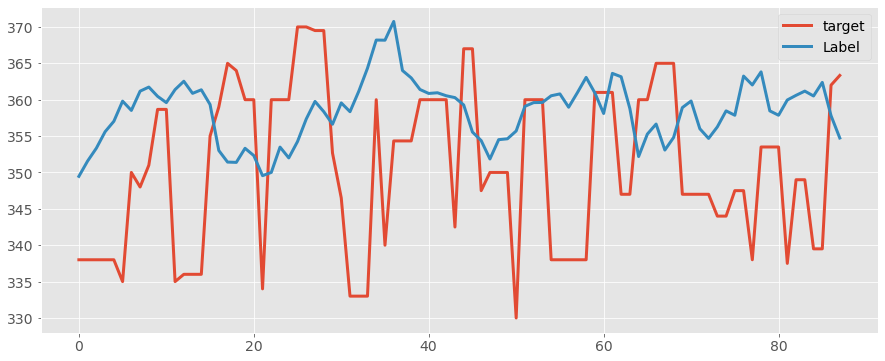

In [27]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

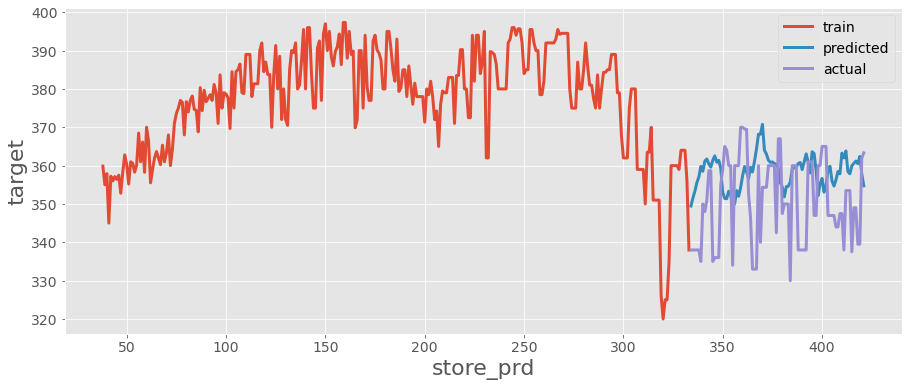

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [29]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(228, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             

shoe_size_10  target  store_frd  store_prd           1           2  \
0             1   385.0       16.0      106.0  353.888889  351.812500   
0             1   386.5       17.0      107.0  351.812500  348.600000   
0             1   379.0       18.0      108.0  348.600000  348.166667   
0             1   378.8       19.0      109.0  348.166667  348.285714   
0             1   389.0       20.0      110.0  348.285714  349.000000   

            3           4           5        6  ...          51          52  \
0  348.600000  348.166667  348.285714  349.000  ...  362.000000  360.250000   
0  348.166667  348.285714  349.000000  347.625  ...  360.250000  365.333333   
0  348.285714  349.000000  347.625000  348.250  ...  365.333333  361.000000   
0  349.000000  347.625000  348.250000  345.800  ...  361.000000  363.400000   
0  347.625000  348.250000  345.800000  351.750  ...  363.400000  368.000000   

           53     54     55     56     57     58     59     60  
0  365.333333  361.0  363.4  368.0  360.0  364.2  371.0  373.6  
0  361.000000  363.4  368.0  360.0  364.2  371.0  373.6  375.0  
0  363.400000  368.0  360.0  364.2  371.0  373.6  375.0  377.0  
0  368.000000  360.0  364.2  371.0  373.6  375.0  377.0  376.5  
0  360.000000  364.2  371.0  373.6  375.0  377.0  376.5  368.0  

[5 rows x 64 columns]

In [30]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(88, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd           1           2  \
0             1   338.0      244.0      334.0  396.000000  396.000000   
0             1   338.0      245.0      335.0  396.000000  394.000000   
0             1   338.0      246.0      336.0  394.000000  395.666667   
0             1   338.0      247.0      337.0  395.666667  395.666667   
0             1   338.0      248.0      338.0  395.666667  392.000000   

            3           4           5      6  ...     51     52     53     54  \
0  394.000000  395.666667  395.666667  392.0  ...  389.0  389.0  389.0  379.0   
0  395.666667  395.666667  392.000000  384.0  ...  389.0  389.0  379.0  379.0   
0  395.666667  392.000000  384.000000  385.0  ...  389.0  379.0  379.0  368.0   
0  392.000000  384.000000  385.000000  385.0  ...  379.0  379.0  368.0  362.0   
0  384.000000  385.000000  385.000000  395.5  ...  379.0  368.0  362.0  362.0   

      55     56     57     58     59     60  
0  379.0  368.0  362.0  362.0  362.0  375.0  
0  368.0  362.0  362.0  362.0  375.0  380.0  
0  362.0  362.0  362.0  375.0  380.0  380.0  
0  362.0  362.0  375.0  380.0  380.0  380.0  
0  362.0  375.0  380.0  380.0  380.0  359.0  

[5 rows x 64 columns]

In [31]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [32]:
py60.compare_models(sort='R2')

In [33]:
py60.compare_models(sort='RMSE')

##### CatBoost - MAE 7.1496, RMSE 9.6017, R2 0.4147

In [34]:
catb60 = py60.create_model('catboost')

In [35]:
tuned_catb60 = py60.tune_model(catb60, optimize='RMSE', choose_better=True)

In [36]:
df_val60 = py60.predict_model(tuned_catb60)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  CatBoost Regressor  7.2197  84.3721  9.1854  0.3827  0.0244  0.0191

In [37]:
df_test60 = py60.predict_model(tuned_catb60, data=test_win60)
df_test60

shoe_size_10      target  store_frd  store_prd           1           2  \
0              1  338.000000      244.0      334.0  396.000000  396.000000   
1              1  338.000000      245.0      335.0  396.000000  394.000000   
2              1  338.000000      246.0      336.0  394.000000  395.666667   
3              1  338.000000      247.0      337.0  395.666667  395.666667   
4              1  338.000000      248.0      338.0  395.666667  392.000000   
..           ...         ...        ...        ...         ...         ...   
83             1  349.000000      327.0      417.0  360.000000  359.000000   
84             1  339.500000      328.0      418.0  359.000000  364.000000   
85             1  339.500000      329.0      419.0  364.000000  364.000000   
86             1  362.000000      330.0      420.0  364.000000  364.000000   
87             1  363.333333      331.0      421.0  364.000000  356.000000   

             3           4           5      6  ...     52     53     54  \
0   394.000000  395.666667  395.666667  392.0  ...  389.0  389.0  379.0   
1   395.666667  395.666667  392.000000  384.0  ...  389.0  379.0  379.0   
2   395.666667  392.000000  384.000000  385.0  ...  379.0  379.0  368.0   
3   392.000000  384.000000  385.000000  385.0  ...  379.0  368.0  362.0   
4   384.000000  385.000000  385.000000  395.5  ...  368.0  362.0  362.0   
..         ...         ...         ...    ...  ...    ...    ...    ...   
83  364.000000  364.000000  364.000000  356.0  ...  367.0  367.0  347.5   
84  364.000000  364.000000  356.000000  338.0  ...  367.0  347.5  350.0   
85  364.000000  356.000000  338.000000  338.0  ...  347.5  350.0  350.0   
86  356.000000  338.000000  338.000000  338.0  ...  350.0  350.0  350.0   
87  338.000000  338.000000  338.000000  338.0  ...  350.0  350.0  330.0   

       55     56     57     58     59     60     Label  
0   379.0  368.0  362.0  362.0  362.0  375.0  374.4537  
1   368.0  362.0  362.0  362.0  375.0  380.0  378.3123  
2   362.0  362.0  362.0  375.0  380.0  380.0  377.7118  
3   362.0  362.0  375.0  380.0  380.0  380.0  381.0910  
4   362.0  375.0  380.0  380.0  380.0  359.0  379.3156  
..    ...    ...    ...    ...    ...    ...       ...  
83  350.0  350.0  350.0  330.0  360.0  360.0  383.4517  
84  350.0  350.0  330.0  360.0  360.0  360.0  383.4302  
85  350.0  330.0  360.0  360.0  360.0  338.0  383.8531  
86  330.0  360.0  360.0  360.0  338.0  338.0  384.0205  
87  360.0  360.0  360.0  338.0  338.0  338.0  383.4565  

[88 rows x 65 columns]

##### CatBoost - Prediction MAE 33.5024

In [38]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

33.5024

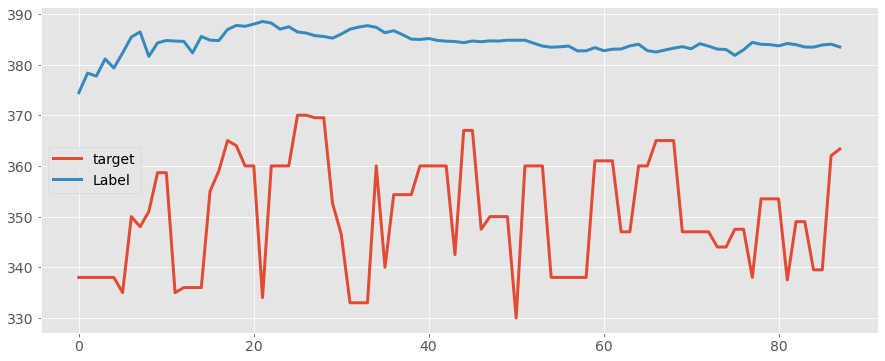

In [39]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

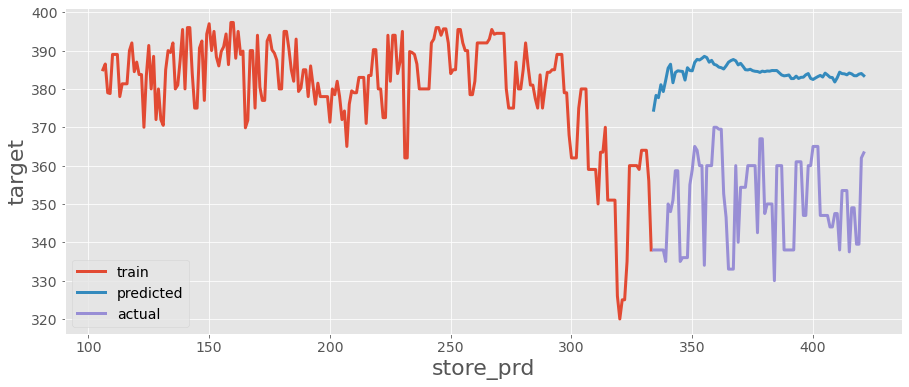

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 7.4734,  RMSE 9.7409, R2 0.4028

In [41]:
et60 = py60.create_model('et')

In [42]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [43]:
df_val60 = py60.predict_model(et60)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  7.6636  90.8264  9.5303  0.3355  0.0253  0.0202

In [44]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

shoe_size_10      target  store_frd  store_prd           1           2  \
0              1  338.000000      244.0      334.0  396.000000  396.000000   
1              1  338.000000      245.0      335.0  396.000000  394.000000   
2              1  338.000000      246.0      336.0  394.000000  395.666667   
3              1  338.000000      247.0      337.0  395.666667  395.666667   
4              1  338.000000      248.0      338.0  395.666667  392.000000   
..           ...         ...        ...        ...         ...         ...   
83             1  349.000000      327.0      417.0  360.000000  359.000000   
84             1  339.500000      328.0      418.0  359.000000  364.000000   
85             1  339.500000      329.0      419.0  364.000000  364.000000   
86             1  362.000000      330.0      420.0  364.000000  364.000000   
87             1  363.333333      331.0      421.0  364.000000  356.000000   

             3           4           5      6  ...     52     53     54  \
0   394.000000  395.666667  395.666667  392.0  ...  389.0  389.0  379.0   
1   395.666667  395.666667  392.000000  384.0  ...  389.0  379.0  379.0   
2   395.666667  392.000000  384.000000  385.0  ...  379.0  379.0  368.0   
3   392.000000  384.000000  385.000000  385.0  ...  379.0  368.0  362.0   
4   384.000000  385.000000  385.000000  395.5  ...  368.0  362.0  362.0   
..         ...         ...         ...    ...  ...    ...    ...    ...   
83  364.000000  364.000000  364.000000  356.0  ...  367.0  367.0  347.5   
84  364.000000  364.000000  356.000000  338.0  ...  367.0  347.5  350.0   
85  364.000000  356.000000  338.000000  338.0  ...  347.5  350.0  350.0   
86  356.000000  338.000000  338.000000  338.0  ...  350.0  350.0  350.0   
87  338.000000  338.000000  338.000000  338.0  ...  350.0  350.0  330.0   

       55     56     57     58     59     60     Label  
0   379.0  368.0  362.0  362.0  362.0  375.0  374.3771  
1   368.0  362.0  362.0  362.0  375.0  380.0  378.3232  
2   362.0  362.0  362.0  375.0  380.0  380.0  382.3263  
3   362.0  362.0  375.0  380.0  380.0  380.0  379.9883  
4   362.0  375.0  380.0  380.0  380.0  359.0  376.0812  
..    ...    ...    ...    ...    ...    ...       ...  
83  350.0  350.0  350.0  330.0  360.0  360.0  378.8814  
84  350.0  350.0  330.0  360.0  360.0  360.0  379.0937  
85  350.0  330.0  360.0  360.0  360.0  338.0  379.0627  
86  330.0  360.0  360.0  360.0  338.0  338.0  379.1946  
87  360.0  360.0  360.0  338.0  338.0  338.0  379.1329  

[88 rows x 65 columns]

##### Extra Trees - Prediction MAE 28.3236

In [45]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

28.3236

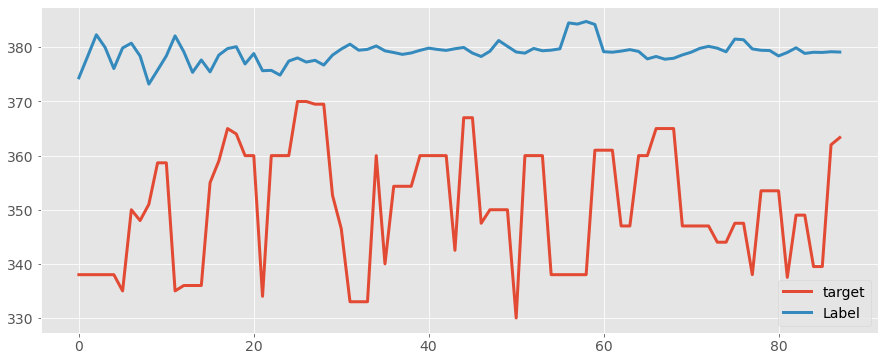

In [46]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

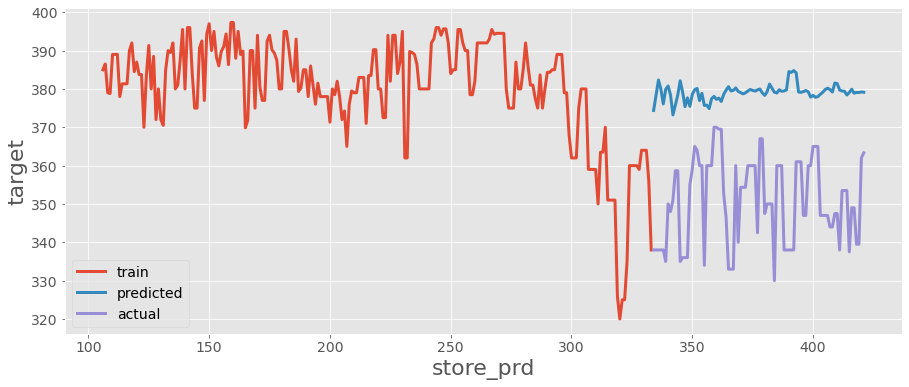

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax)

#### 90-Day Prediction

##### Load Train and Test Data

In [48]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


(48, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10      target  store_frd  store_prd           1           2  \
0             1  375.000000       16.0      286.0  353.888889  351.812500   
0             1  383.666667       17.0      287.0  351.812500  348.600000   
0             1  375.000000       18.0      288.0  348.600000  348.166667   
0             1  380.000000       19.0      289.0  348.166667  348.285714   
0             1  384.333333       20.0      290.0  348.285714  349.000000   

            3           4           5        6  ...         171         172  \
0  348.600000  348.166667  348.285714  349.000  ...  393.000000  379.333333   
0  348.166667  348.285714  349.000000  347.625  ...  379.333333  380.250000   
0  348.285714  349.000000  347.625000  348.250  ...  380.250000  385.000000   
0  349.000000  347.625000  348.250000  345.800  ...  385.000000  385.000000   
0  347.625000  348.250000  345.800000  351.750  ...  385.000000  378.000000   

      173    174    175    176    177    178    179    180  
0  380.25  385.0  385.0  378.0  386.0  381.0  376.0  381.5  
0  385.00  385.0  378.0  386.0  381.0  376.0  381.5  378.0  
0  385.00  378.0  386.0  381.0  376.0  381.5  378.0  378.0  
0  378.00  386.0  381.0  376.0  381.5  378.0  378.0  378.0  
0  386.00  381.0  376.0  381.5  378.0  378.0  378.0  378.0  

[5 rows x 184 columns]

In [49]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


(88, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10  target  store_frd  store_prd           1           2  \
0             1   338.0       64.0      334.0  362.000000  363.666667   
0             1   338.0       65.0      335.0  363.666667  362.000000   
0             1   338.0       66.0      336.0  362.000000  360.250000   
0             1   338.0       67.0      337.0  360.250000  365.333333   
0             1   338.0       68.0      338.0  365.333333  361.000000   

            3           4           5      6  ...    171    172    173    174  \
0  362.000000  360.250000  365.333333  361.0  ...  389.5  389.0  386.5  380.0   
0  360.250000  365.333333  361.000000  363.4  ...  389.0  386.5  380.0  380.0   
0  365.333333  361.000000  363.400000  368.0  ...  386.5  380.0  380.0  380.0   
0  361.000000  363.400000  368.000000  360.0  ...  380.0  380.0  380.0  380.0   
0  363.400000  368.000000  360.000000  364.2  ...  380.0  380.0  380.0  380.0   

     175    176    177    178    179         180  
0  380.0  380.0  380.0  380.0  392.0  393.000000  
0  380.0  380.0  380.0  392.0  393.0  396.000000  
0  380.0  380.0  392.0  393.0  396.0  396.000000  
0  380.0  392.0  393.0  396.0  396.0  394.000000  
0  392.0  393.0  396.0  396.0  394.0  395.666667  

[5 rows x 184 columns]

In [50]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [51]:
py180.compare_models(sort='R2')

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
py180.compare_models(blacklist=['lar'], sort='RMSE')

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

##### TheilSen - MAE 9.1905, RMSE 10.6782, R2 -0.1870

In [53]:
tr180 = py180.create_model('tr')

In [54]:
tuned_tr180 = py180.tune_model(tr180, optimize='RMSE', choose_better=True)

In [55]:
df_val180 = py180.predict_model(tr180)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Theil Sen Regressor  7.7416  84.7306  9.2049  0.4892  0.0251  0.0208

In [56]:
df_test180 = py180.predict_model(tr180, data=test_win180)
df_test180

shoe_size_10      target  store_frd  store_prd           1           2  \
0              1  338.000000       64.0      334.0  362.000000  363.666667   
1              1  338.000000       65.0      335.0  363.666667  362.000000   
2              1  338.000000       66.0      336.0  362.000000  360.250000   
3              1  338.000000       67.0      337.0  360.250000  365.333333   
4              1  338.000000       68.0      338.0  365.333333  361.000000   
..           ...         ...        ...        ...         ...         ...   
83             1  349.000000      147.0      417.0  392.500000  377.000000   
84             1  339.500000      148.0      418.0  377.000000  394.333333   
85             1  339.500000      149.0      419.0  394.333333  397.000000   
86             1  362.000000      150.0      420.0  397.000000  390.000000   
87             1  363.333333      151.0      421.0  390.000000  395.000000   

             3           4           5           6  ...    172    173    174  \
0   362.000000  360.250000  365.333333  361.000000  ...  389.0  386.5  380.0   
1   360.250000  365.333333  361.000000  363.400000  ...  386.5  380.0  380.0   
2   365.333333  361.000000  363.400000  368.000000  ...  380.0  380.0  380.0   
3   361.000000  363.400000  368.000000  360.000000  ...  380.0  380.0  380.0   
4   363.400000  368.000000  360.000000  364.200000  ...  380.0  380.0  380.0   
..         ...         ...         ...         ...  ...    ...    ...    ...   
83  394.333333  397.000000  390.000000  395.000000  ...  351.0  326.0  320.0   
84  397.000000  390.000000  395.000000  388.333333  ...  326.0  320.0  325.0   
85  390.000000  395.000000  388.333333  386.000000  ...  320.0  325.0  325.0   
86  395.000000  388.333333  386.000000  389.750000  ...  325.0  325.0  335.0   
87  388.333333  386.000000  389.750000  391.000000  ...  325.0  335.0  360.0   

      175    176    177    178    179         180     Label  
0   380.0  380.0  380.0  380.0  392.0  393.000000  351.3286  
1   380.0  380.0  380.0  392.0  393.0  396.000000  352.2882  
2   380.0  380.0  392.0  393.0  396.0  396.000000  344.2519  
3   380.0  392.0  393.0  396.0  396.0  394.000000  342.8955  
4   392.0  393.0  396.0  396.0  394.0  395.666667  346.5100  
..    ...    ...    ...    ...    ...         ...       ...  
83  325.0  325.0  335.0  360.0  360.0  360.000000  343.5176  
84  325.0  335.0  360.0  360.0  360.0  360.000000  348.3833  
85  335.0  360.0  360.0  360.0  360.0  359.000000  336.6527  
86  360.0  360.0  360.0  360.0  359.0  364.000000  327.6210  
87  360.0  360.0  360.0  359.0  364.0  364.000000  319.1845  

[88 rows x 185 columns]

##### TheilSen - Prediction MAE 12.7128

In [57]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

12.7128

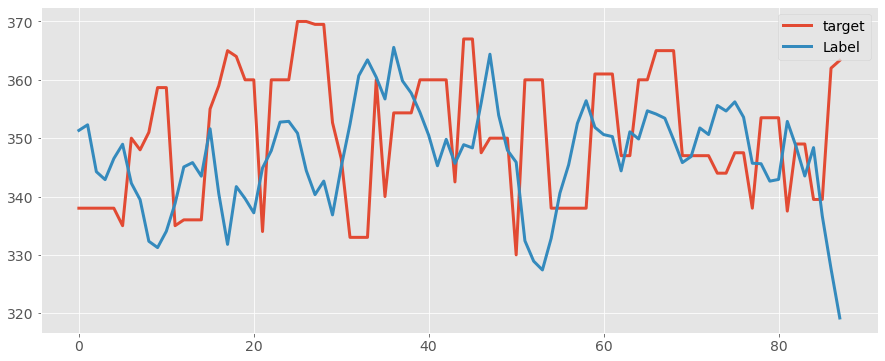

In [58]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

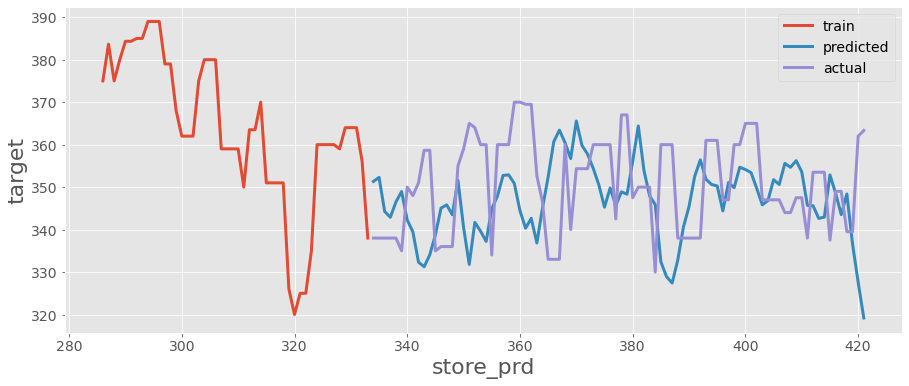

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 11.1079, RMSE 13.5491, R2 -0.4017

In [60]:
et180 = py180.create_model('et')

In [61]:
tuned_et180 = py180.tune_model(et180, optimize='RMSE', choose_better=True)

In [62]:
df_val180 = py180.predict_model(et180)

Model     MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  8.9812  105.8933  10.2904  0.3617  0.0281  0.0241

In [63]:
df_test180 = py180.predict_model(et180, data=test_win180)
df_test180

shoe_size_10      target  store_frd  store_prd           1           2  \
0              1  338.000000       64.0      334.0  362.000000  363.666667   
1              1  338.000000       65.0      335.0  363.666667  362.000000   
2              1  338.000000       66.0      336.0  362.000000  360.250000   
3              1  338.000000       67.0      337.0  360.250000  365.333333   
4              1  338.000000       68.0      338.0  365.333333  361.000000   
..           ...         ...        ...        ...         ...         ...   
83             1  349.000000      147.0      417.0  392.500000  377.000000   
84             1  339.500000      148.0      418.0  377.000000  394.333333   
85             1  339.500000      149.0      419.0  394.333333  397.000000   
86             1  362.000000      150.0      420.0  397.000000  390.000000   
87             1  363.333333      151.0      421.0  390.000000  395.000000   

             3           4           5           6  ...    172    173    174  \
0   362.000000  360.250000  365.333333  361.000000  ...  389.0  386.5  380.0   
1   360.250000  365.333333  361.000000  363.400000  ...  386.5  380.0  380.0   
2   365.333333  361.000000  363.400000  368.000000  ...  380.0  380.0  380.0   
3   361.000000  363.400000  368.000000  360.000000  ...  380.0  380.0  380.0   
4   363.400000  368.000000  360.000000  364.200000  ...  380.0  380.0  380.0   
..         ...         ...         ...         ...  ...    ...    ...    ...   
83  394.333333  397.000000  390.000000  395.000000  ...  351.0  326.0  320.0   
84  397.000000  390.000000  395.000000  388.333333  ...  326.0  320.0  325.0   
85  390.000000  395.000000  388.333333  386.000000  ...  320.0  325.0  325.0   
86  395.000000  388.333333  386.000000  389.750000  ...  325.0  325.0  335.0   
87  388.333333  386.000000  389.750000  391.000000  ...  325.0  335.0  360.0   

      175    176    177    178    179         180    Label  
0   380.0  380.0  380.0  380.0  392.0  393.000000  346.290  
1   380.0  380.0  380.0  392.0  393.0  396.000000  347.605  
2   380.0  380.0  392.0  393.0  396.0  396.000000  343.890  
3   380.0  392.0  393.0  396.0  396.0  394.000000  347.155  
4   392.0  393.0  396.0  396.0  394.0  395.666667  347.675  
..    ...    ...    ...    ...    ...         ...      ...  
83  325.0  325.0  335.0  360.0  360.0  360.000000  348.975  
84  325.0  335.0  360.0  360.0  360.0  360.000000  349.740  
85  335.0  360.0  360.0  360.0  360.0  359.000000  348.705  
86  360.0  360.0  360.0  360.0  359.0  364.000000  342.700  
87  360.0  360.0  360.0  359.0  364.0  364.000000  345.670  

[88 rows x 185 columns]

##### Extra Trees - Prediction MAE 10.8647

In [64]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

10.8647

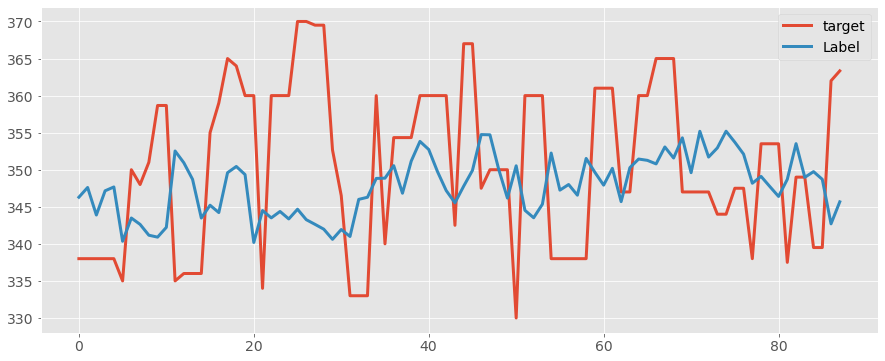

In [65]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

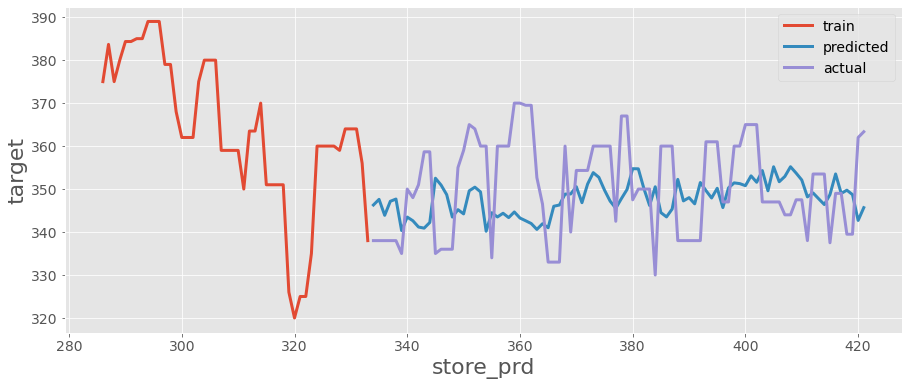

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

# Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0

Sneaker Name is ' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'
    - Accuracy dropped even further after limiting dataset to shoe size 10 (best R2 0.5834)
        - Previously best R2 ~0.80 for dtaaset with shoe sizes 9, 10, and 11
    - Extra Trees best for 7-day prediction
    - CatBoost best for 30-day prediction
    - Elastic Net best for 90-day prediction


## Data Processing and EDA

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from datetime import timedelta
from cycler import cycler

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [3]:
#from cycler import cycler
#plt.style.use('dark_background')
#plt.style.use('dark_background')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

In [4]:
CUTOFF_TRAINMIN = '2018-01-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


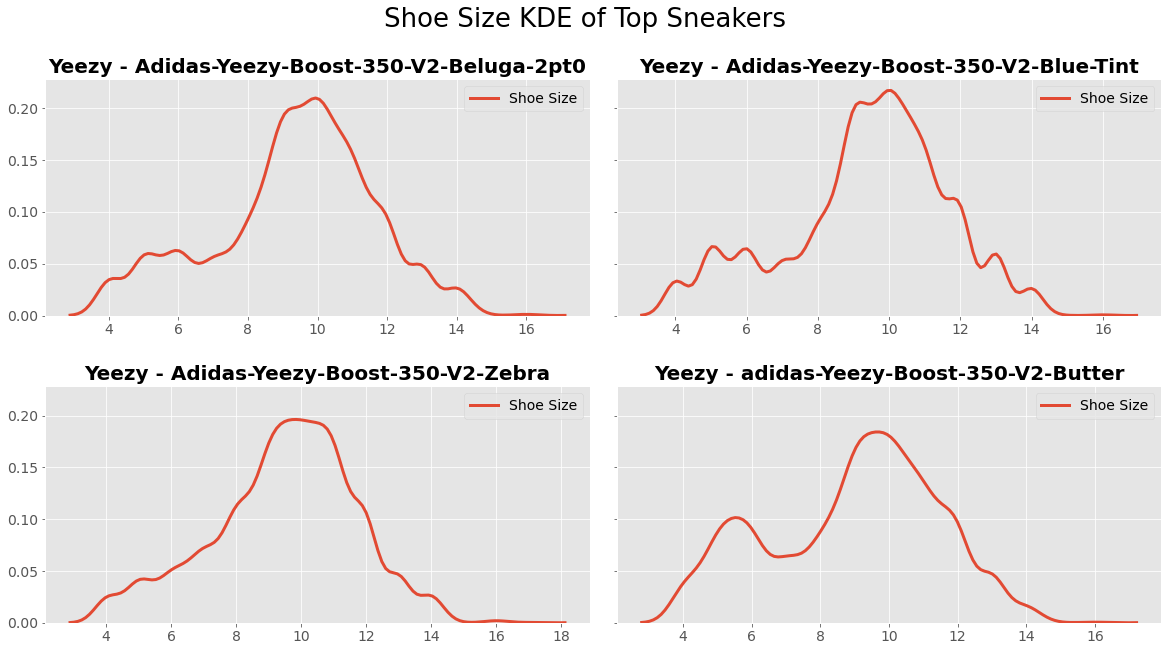

In [6]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

In [7]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [8]:
sneaker_name = ' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'
df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                    Sneaker Name  Shoe Size  \
0   2017-11-17   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
1   2017-11-19   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
2   2017-11-20   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
3   2017-11-21   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
4   2017-11-22   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
..         ...                                             ...        ...   
335 2019-02-06   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
336 2019-02-07   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
337 2019-02-08   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
338 2019-02-11   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   
339 2019-02-13   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0       10.0   

     Sale Price  DaysStored  
0         614.0          -8  
1         605.0          -6  
2         550.0          -5  
3         532.5          -4  
4         499.5          -3  
..          ...         ...  
335       413.0         438  
336       408.0         439  
337       435.0         440  
338       440.0         443  
339       450.0         445  

[340 rows x 5 columns]

In [9]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(409, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-01-01  2018-01-01  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1 2018-01-02  2018-01-02  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2 2018-01-03  2018-01-03  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3 2018-01-04  2018-01-04  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4 2018-01-05  2018-01-05  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb30  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                            lst_lb60  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-01-01, 2018-01-02, 2018-01-03, 2018-01-0...  2018-01-15  2018-01-30   
1  [2018-01-02, 2018-01-03, 2018-01-04, 2018-01-0...  2018-01-16  2018-01-31   
2  [2018-01-03, 2018-01-04, 2018-01-05, 2018-01-0...  2018-01-17  2018-02-01   
3  [2018-01-04, 2018-01-05, 2018-01-06, 2018-01-0...  2018-01-18  2018-02-02   
4  [2018-01-05, 2018-01-06, 2018-01-07, 2018-01-0...  2018-01-19  2018-02-03   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-03-01  2018-06-29  2018-01-23  2018-02-07  2018-03-09  2018-04-01   
1  2018-03-02  2018-06-30  2018-01-24  2018-02-08  2018-03-10  2018-04-02   
2  2018-03-03  2018-07-01  2018-01-25  2018-02-09  2018-03-11  2018-04-03   
3  2018-03-04  2018-07-02  2018-01-26  2018-02-10  2018-03-12  2018-04-04   
4  2018-03-05  2018-07-03  2018-01-27  2018-02-11  2018-03-13  2018-04-05   

  lb180_plus90  
0   2018-09-28  
1   2018-09-29  
2   2018-09-30  
3   2018-10-01  
4   2018-10-02

In [10]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (409, 3)
df_tmp.shape (409, 5)


dt_str                                    Sneaker Name  Shoe Size  \
0  2018-01-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
1  2018-01-02   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
2  2018-01-03   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
3  2018-01-04   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   
4  2018-01-05   Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0         10   

   Sale Price  DaysStored  
0  380.833333        37.0  
1  374.000000        38.0  
2  368.400000        39.0  
3  364.750000        40.0  
4  376.250000        41.0

In [11]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 409)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 409)
0    10
Name: Shoe Size, dtype: int64


In [12]:
pvt_price

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10  380.833333       374.0       368.4      364.75      376.25   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-04  \
0           375.75       375.5      371.75       385.0  ...       445.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0            422.0       413.0       408.0       435.0       435.0   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0            435.0       440.0       440.0       450.0  

[1 rows x 410 columns]

In [13]:
pvt_price_diff

dt_str  Shoe Size  2018-01-01  2018-01-02  2018-01-03  2018-01-04  2018-01-05  \
0              10         NaN   -6.833333        -5.6       -3.65        11.5   

dt_str  2018-01-06  2018-01-07  2018-01-08  2018-01-09  ...  2019-02-04  \
0             -0.5       -0.25       -3.75       13.25  ...        17.5   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0            -23.0        -9.0        -5.0        27.0         0.0   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0              0.0         5.0         0.0        10.0  

[1 rows x 410 columns]

In [14]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

## Regression

In [15]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

### Models List

In [16]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [17]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(296, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1       2       3  \
0             1  377.166667       37.0       59.0  380.833333  374.00  368.40   
0             1  389.000000       38.0       60.0  374.000000  368.40  364.75   
0             1  385.500000       39.0       61.0  368.400000  364.75  376.25   
0             1  387.333333       40.0       62.0  364.750000  376.25  375.75   
0             1  388.000000       41.0       63.0  376.250000  375.75  375.50   

        4       5           6           7           8           9          10  \
0  364.75  376.25  375.750000  375.500000  371.750000  385.000000  378.333333   
0  376.25  375.75  375.500000  371.750000  385.000000  378.333333  376.000000   
0  375.75  375.50  371.750000  385.000000  378.333333  376.000000  383.200000   
0  375.50  371.75  385.000000  378.333333  376.000000  383.200000  378.000000   
0  371.75  385.00  378.333333  376.000000  383.200000  378.000000  385.500000   

      11     12     13     14     15  
0  376.0  383.2  378.0  385.5  386.0  
0  383.2  378.0  385.5  386.0  386.0  
0  378.0  385.5  386.0  386.0  376.0  
0  385.5  386.0  386.0  376.0  375.2  
0  386.0  386.0  376.0  375.2  377.5

In [18]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(90, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1   379.0      333.0      355.0  403.0  404.0  404.0  414.0   
0             1   421.0      334.0      356.0  404.0  404.0  414.0  414.0   
0             1   424.5      335.0      357.0  404.0  414.0  414.0  397.5   
0             1   424.5      336.0      358.0  414.0  414.0  397.5  400.0   
0             1   385.0      337.0      359.0  414.0  397.5  400.0  400.0   

       5      6      7      8      9     10     11     12     13     14     15  
0  414.0  397.5  400.0  400.0  392.0  392.0  392.0  404.0  386.0  410.0  410.0  
0  397.5  400.0  400.0  392.0  392.0  392.0  404.0  386.0  410.0  410.0  415.0  
0  400.0  400.0  392.0  392.0  392.0  404.0  386.0  410.0  410.0  415.0  415.0  
0  400.0  392.0  392.0  392.0  404.0  386.0  410.0  410.0  415.0  415.0  415.0  
0  392.0  392.0  392.0  404.0  386.0  410.0  410.0  415.0  415.0  415.0  415.0

In [19]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [20]:
py15.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [21]:
py15.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 6.5568, RMSE 8.4976, R2 0.5834

In [22]:
et15 = py15.create_model('et')

In [23]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [24]:
df_val15 = py15.predict_model(et15)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  6.3324  69.6738  8.3471  0.7123  0.0203  0.0154

In [25]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      333.0      355.0  403.0  404.0  404.0  414.0   
1              1   421.0      334.0      356.0  404.0  404.0  414.0  414.0   
2              1   424.5      335.0      357.0  404.0  414.0  414.0  397.5   
3              1   424.5      336.0      358.0  414.0  414.0  397.5  400.0   
4              1   385.0      337.0      359.0  414.0  397.5  400.0  400.0   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      418.0      440.0  424.5  400.0  400.0  400.0   
86             1   435.0      419.0      441.0  400.0  400.0  400.0  391.5   
87             1   435.0      420.0      442.0  400.0  400.0  391.5  421.0   
88             1   440.0      421.0      443.0  400.0  391.5  421.0  421.0   
89             1   440.0      422.0      444.0  391.5  421.0  421.0  400.0   

        5      6      7      8      9     10        11        12        13  \
0   414.0  397.5  400.0  400.0  392.0  392.0  392.0000  404.0000  386.0000   
1   397.5  400.0  400.0  392.0  392.0  392.0  404.0000  386.0000  410.0000   
2   400.0  400.0  392.0  392.0  392.0  404.0  386.0000  410.0000  410.0000   
3   400.0  392.0  392.0  392.0  404.0  386.0  410.0000  410.0000  415.0000   
4   392.0  392.0  392.0  404.0  386.0  410.0  410.0000  415.0000  415.0000   
..    ...    ...    ...    ...    ...    ...       ...       ...       ...   
85  391.5  421.0  421.0  400.0  425.0  425.0  425.0000  425.0000  429.0000   
86  421.0  421.0  400.0  425.0  425.0  425.0  425.0000  429.0000  429.0000   
87  421.0  400.0  425.0  425.0  425.0  425.0  429.0000  429.0000  422.0149   
88  400.0  425.0  425.0  425.0  425.0  429.0  429.0000  422.0149  422.0149   
89  425.0  425.0  425.0  425.0  429.0  429.0  422.0149  422.0149  424.0000   

          14        15     Label  
0   410.0000  410.0000  407.6645  
1   410.0000  415.0000  409.2485  
2   415.0000  415.0000  410.5593  
3   415.0000  415.0000  409.6048  
4   415.0000  415.0000  410.5933  
..       ...       ...       ...  
85  429.0000  422.0149  425.6450  
86  422.0149  422.0149  424.7608  
87  422.0149  424.0000  424.9125  
88  424.0000  427.5000  429.2692  
89  427.5000  445.0000  435.0000  

[90 rows x 20 columns]

##### Extra Trees - Prediction MAE 12.872

In [26]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

12.872

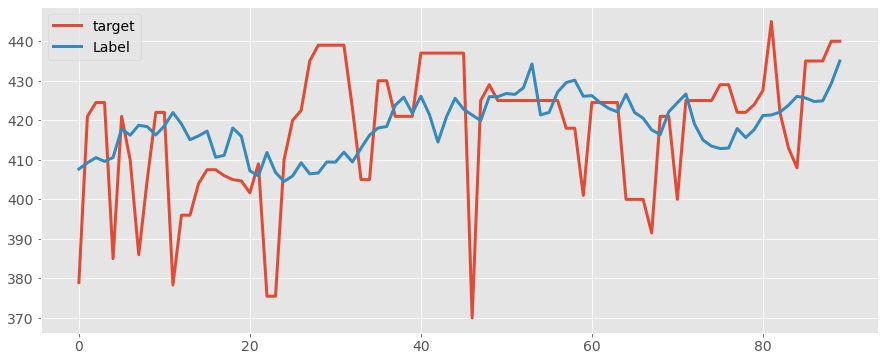

In [27]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

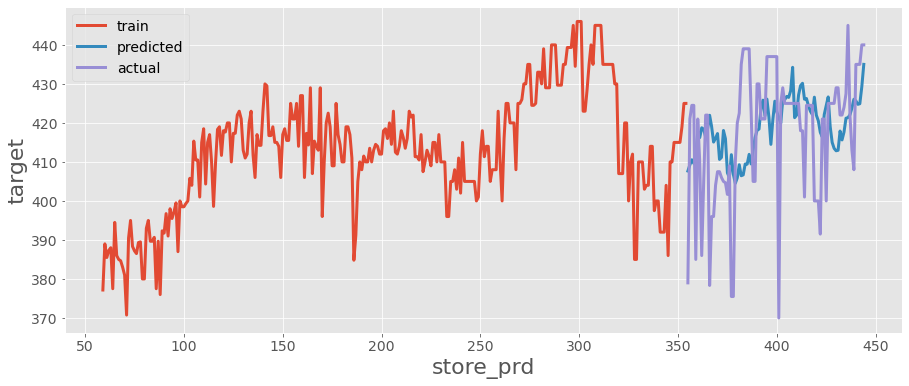

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [29]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(228, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             

shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   422.0       37.0      127.0  380.833333  374.00  368.40   
0             1   423.0       38.0      128.0  374.000000  368.40  364.75   
0             1   421.0       39.0      129.0  368.400000  364.75  376.25   
0             1   413.0       40.0      130.0  364.750000  376.25  375.75   
0             1   411.0       41.0      131.0  376.250000  375.75  375.50   

        4       5           6  ...          51          52          53  \
0  364.75  376.25  375.750000  ...  389.666667  376.000000  392.333333   
0  376.25  375.75  375.500000  ...  376.000000  392.333333  391.750000   
0  375.75  375.50  371.750000  ...  392.333333  391.750000  396.750000   
0  375.50  371.75  385.000000  ...  391.750000  396.750000  391.000000   
0  371.75  385.00  378.333333  ...  396.750000  391.000000  398.000000   

       54      55     56     57     58     59     60  
0  391.75  396.75  391.0  398.0  395.5  397.2  399.5  
0  396.75  391.00  398.0  395.5  397.2  399.5  387.0  
0  391.00  398.00  395.5  397.2  399.5  387.0  400.0  
0  398.00  395.50  397.2  399.5  387.0  400.0  398.5  
0  395.50  397.20  399.5  387.0  400.0  398.5  398.5  

[5 rows x 64 columns]

In [30]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(90, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0             1   379.0      265.0      355.0  420.0  420.0  420.0  408.0   
0             1   421.0      266.0      356.0  420.0  420.0  408.0  425.0   
0             1   424.5      267.0      357.0  420.0  408.0  425.0  425.0   
0             1   424.5      268.0      358.0  408.0  425.0  425.0  426.0   
0             1   385.0      269.0      359.0  425.0  425.0  426.0  430.0   

       5      6  ...     51     52     53     54     55     56     57     58  \
0  425.0  425.0  ...  435.0  435.0  435.0  430.0  430.0  407.0  407.0  407.0   
0  425.0  426.0  ...  435.0  435.0  430.0  430.0  407.0  407.0  407.0  420.0   
0  426.0  430.0  ...  435.0  430.0  430.0  407.0  407.0  407.0  420.0  420.0   
0  430.0  430.0  ...  430.0  430.0  407.0  407.0  407.0  420.0  420.0  400.0   
0  430.0  435.0  ...  430.0  407.0  407.0  407.0  420.0  420.0  400.0  410.0   

      59     60  
0  420.0  420.0  
0  420.0  400.0  
0  400.0  410.0  
0  410.0  412.0  
0  412.0  385.0  

[5 rows x 64 columns]

In [31]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [32]:
py60.compare_models(sort='R2')

In [33]:
py60.compare_models(sort='RMSE')

##### CatBoost - MAE 6.6469, RMSE 8.4495, R2 0.4780

In [34]:
catb60 = py60.create_model('catboost')

In [35]:
tuned_catb60 = py60.tune_model(catb60, optimize='RMSE', choose_better=True)

In [36]:
df_val60 = py60.predict_model(catb60)

Model    MAE      MSE  RMSE     R2   RMSLE    MAPE
0  CatBoost Regressor  6.879  76.7374  8.76  0.577  0.0209  0.0164

In [37]:
df_test60 = py60.predict_model(catb60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      265.0      355.0  420.0  420.0  420.0  408.0   
1              1   421.0      266.0      356.0  420.0  420.0  408.0  425.0   
2              1   424.5      267.0      357.0  420.0  408.0  425.0  425.0   
3              1   424.5      268.0      358.0  408.0  425.0  425.0  426.0   
4              1   385.0      269.0      359.0  425.0  425.0  426.0  430.0   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      350.0      440.0  415.0  415.0  419.0  425.0   
86             1   435.0      351.0      441.0  415.0  419.0  425.0  425.0   
87             1   435.0      352.0      442.0  419.0  425.0  425.0  379.0   
88             1   440.0      353.0      443.0  425.0  425.0  379.0  421.0   
89             1   440.0      354.0      444.0  425.0  379.0  421.0  424.5   

        5      6  ...     52     53     54     55     56     57     58     59  \
0   425.0  425.0  ...  435.0  435.0  430.0  430.0  407.0  407.0  407.0  420.0   
1   425.0  426.0  ...  435.0  430.0  430.0  407.0  407.0  407.0  420.0  420.0   
2   426.0  430.0  ...  430.0  430.0  407.0  407.0  407.0  420.0  420.0  400.0   
3   430.0  430.0  ...  430.0  407.0  407.0  407.0  420.0  420.0  400.0  410.0   
4   430.0  435.0  ...  407.0  407.0  407.0  420.0  420.0  400.0  410.0  412.0   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85  425.0  379.0  ...  370.0  425.0  429.0  425.0  425.0  425.0  425.0  425.0   
86  379.0  421.0  ...  425.0  429.0  425.0  425.0  425.0  425.0  425.0  425.0   
87  421.0  424.5  ...  429.0  425.0  425.0  425.0  425.0  425.0  425.0  425.0   
88  424.5  424.5  ...  425.0  425.0  425.0  425.0  425.0  425.0  425.0  425.0   
89  424.5  385.0  ...  425.0  425.0  425.0  425.0  425.0  425.0  425.0  418.0   

       60     Label  
0   420.0  420.7848  
1   400.0  417.6020  
2   410.0  415.3349  
3   412.0  415.7013  
4   385.0  416.3109  
..    ...       ...  
85  425.0  420.6410  
86  425.0  419.4426  
87  425.0  417.8205  
88  418.0  415.9303  
89  418.0  414.9588  

[90 rows x 65 columns]

##### CatBoost - Prediction MAE 13.3504

In [38]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

13.3504

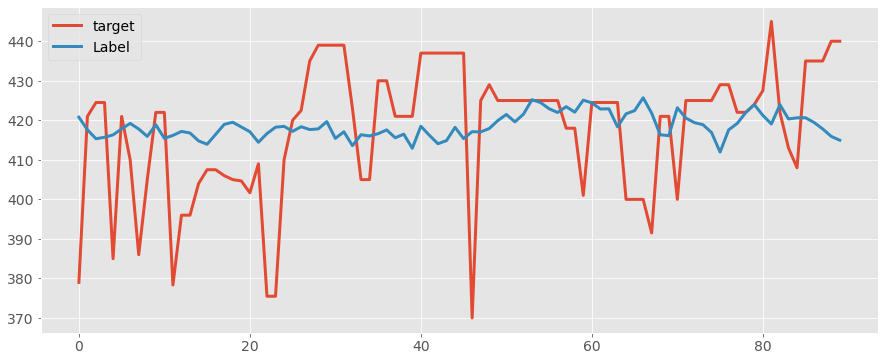

In [39]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

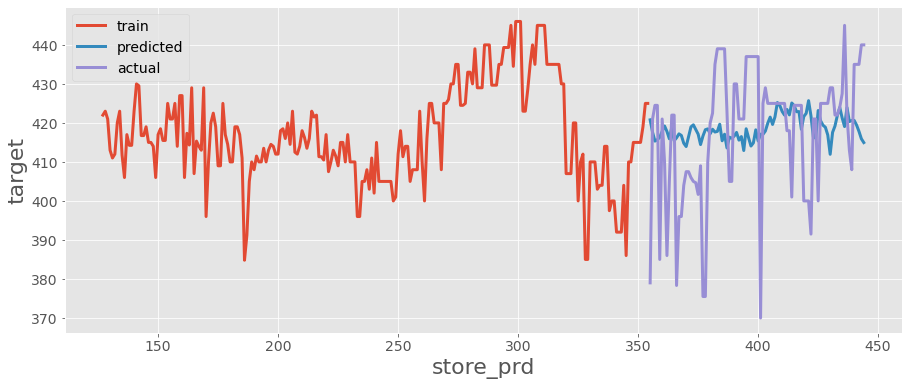

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 6.8542,  RMSE 8.7397, R2 0.4416

In [41]:
et60 = py60.create_model('et')

In [42]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [43]:
df_val60 = py60.predict_model(et60)

Model     MAE      MSE    RMSE     R2   RMSLE    MAPE
0  Extra Trees Regressor  7.2753  86.7146  9.3121  0.522  0.0222  0.0173

In [44]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd      1      2      3      4  \
0              1   379.0      265.0      355.0  420.0  420.0  420.0  408.0   
1              1   421.0      266.0      356.0  420.0  420.0  408.0  425.0   
2              1   424.5      267.0      357.0  420.0  408.0  425.0  425.0   
3              1   424.5      268.0      358.0  408.0  425.0  425.0  426.0   
4              1   385.0      269.0      359.0  425.0  425.0  426.0  430.0   
..           ...     ...        ...        ...    ...    ...    ...    ...   
85             1   435.0      350.0      440.0  415.0  415.0  419.0  425.0   
86             1   435.0      351.0      441.0  415.0  419.0  425.0  425.0   
87             1   435.0      352.0      442.0  419.0  425.0  425.0  379.0   
88             1   440.0      353.0      443.0  425.0  425.0  379.0  421.0   
89             1   440.0      354.0      444.0  425.0  379.0  421.0  424.5   

        5      6  ...     52     53     54     55     56     57     58     59  \
0   425.0  425.0  ...  435.0  435.0  430.0  430.0  407.0  407.0  407.0  420.0   
1   425.0  426.0  ...  435.0  430.0  430.0  407.0  407.0  407.0  420.0  420.0   
2   426.0  430.0  ...  430.0  430.0  407.0  407.0  407.0  420.0  420.0  400.0   
3   430.0  430.0  ...  430.0  407.0  407.0  407.0  420.0  420.0  400.0  410.0   
4   430.0  435.0  ...  407.0  407.0  407.0  420.0  420.0  400.0  410.0  412.0   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85  425.0  379.0  ...  370.0  425.0  429.0  425.0  425.0  425.0  425.0  425.0   
86  379.0  421.0  ...  425.0  429.0  425.0  425.0  425.0  425.0  425.0  425.0   
87  421.0  424.5  ...  429.0  425.0  425.0  425.0  425.0  425.0  425.0  425.0   
88  424.5  424.5  ...  425.0  425.0  425.0  425.0  425.0  425.0  425.0  425.0   
89  424.5  385.0  ...  425.0  425.0  425.0  425.0  425.0  425.0  425.0  418.0   

       60     Label  
0   420.0  414.0458  
1   400.0  414.9225  
2   410.0  413.6280  
3   412.0  415.0722  
4   385.0  417.0067  
..    ...       ...  
85  425.0  420.6312  
86  425.0  421.9075  
87  425.0  417.5800  
88  418.0  414.1330  
89  418.0  411.0108  

[90 rows x 65 columns]

##### Extra Trees - Prediction MAE 13.0608

In [45]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

13.0608

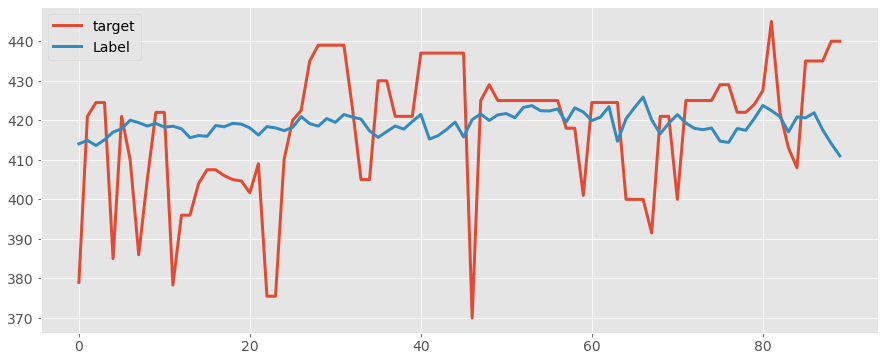

In [46]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

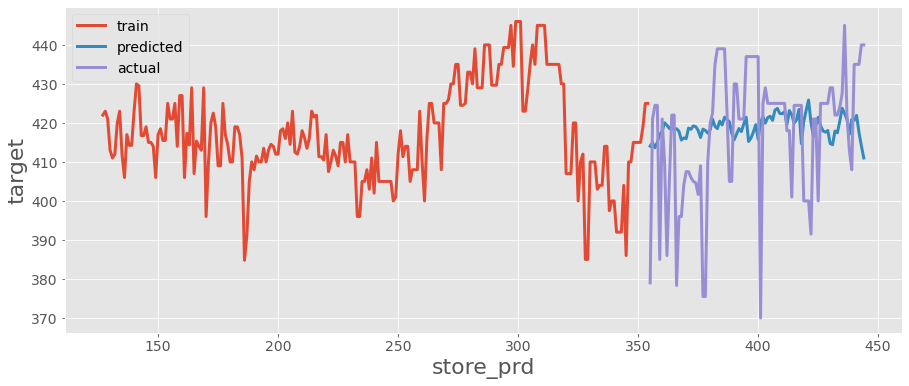

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 90-Day Prediction

##### Load Train and Test Data

In [48]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


(48, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   435.0       37.0      307.0  380.833333  374.00  368.40   
0             1   445.0       38.0      308.0  374.000000  368.40  364.75   
0             1   445.0       39.0      309.0  368.400000  364.75  376.25   
0             1   445.0       40.0      310.0  364.750000  376.25  375.75   
0             1   445.0       41.0      311.0  376.250000  375.75  375.50   

        4       5           6  ...     171     172     173     174     175  \
0  364.75  376.25  375.750000  ...  412.50  412.00  414.00  418.00  416.25   
0  376.25  375.75  375.500000  ...  412.00  414.00  418.00  416.25  413.50   
0  375.75  375.50  371.750000  ...  414.00  418.00  416.25  413.50  416.00   
0  375.50  371.75  385.000000  ...  418.00  416.25  413.50  416.00  423.00   
0  371.75  385.00  378.333333  ...  416.25  413.50  416.00  423.00  421.50   

     176         177         178         179         180  
0  413.5  416.000000  423.000000  421.500000  422.000000  
0  416.0  423.000000  421.500000  422.000000  411.333333  
0  423.0  421.500000  422.000000  411.333333  411.333333  
0  421.5  422.000000  411.333333  411.333333  410.500000  
0  422.0  411.333333  411.333333  410.500000  417.000000  

[5 rows x 184 columns]

In [49]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


(90, 184) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,
       ...
                  171,            172,            173,            174,
                  175,            176,            177,            178,
                  179,            180],
      dtype='object', length=184)


shoe_size_10  target  store_frd  store_prd           1           2  \
0             1   379.0       85.0      355.0  390.666667  377.500000   
0             1   421.0       86.0      356.0  377.500000  389.666667   
0             1   424.5       87.0      357.0  389.666667  376.000000   
0             1   424.5       88.0      358.0  376.000000  392.333333   
0             1   385.0       89.0      359.0  392.333333  391.750000   

            3           4           5       6  ...    171    172    173  \
0  389.666667  376.000000  392.333333  391.75  ...  405.0  408.0  408.0   
0  376.000000  392.333333  391.750000  396.75  ...  408.0  408.0  408.0   
0  392.333333  391.750000  396.750000  391.00  ...  408.0  408.0  423.0   
0  391.750000  396.750000  391.000000  398.00  ...  408.0  423.0  410.0   
0  396.750000  391.000000  398.000000  395.50  ...  423.0  410.0  400.0   

     174    175    176    177    178    179    180  
0  408.0  423.0  410.0  400.0  416.0  425.0  425.0  
0  423.0  410.0  400.0  416.0  425.0  425.0  420.0  
0  410.0  400.0  416.0  425.0  425.0  420.0  420.0  
0  400.0  416.0  425.0  425.0  420.0  420.0  420.0  
0  416.0  425.0  425.0  420.0  420.0  420.0  408.0  

[5 rows x 184 columns]

In [50]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [51]:
py180.compare_models(sort='R2')

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
                  random_state=123, tol=0.001, verbose=False)

In [52]:
py180.compare_models(sort='RMSE')

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=123, selection='cyclic', tol=0.0001, warm_start=False)

##### Elastic Net - MAE 6.5723, RMSE 8.1809, R2 0.4865

In [53]:
en180 = py180.create_model('en')

In [54]:
tuned_en180 = py180.tune_model(en180, optimize='RMSE', choose_better=True)

In [55]:
df_val180 = py180.predict_model(en180)

Model     MAE      MSE    RMSE      R2   RMSLE    MAPE
0  Elastic Net  6.7651  55.9263  7.4784  0.7456  0.0181  0.0164

In [56]:
df_test180 = py180.predict_model(en180, data=test_win180)
df_test180

shoe_size_10  target  store_frd  store_prd           1           2  \
0              1   379.0       85.0      355.0  390.666667  377.500000   
1              1   421.0       86.0      356.0  377.500000  389.666667   
2              1   424.5       87.0      357.0  389.666667  376.000000   
3              1   424.5       88.0      358.0  376.000000  392.333333   
4              1   385.0       89.0      359.0  392.333333  391.750000   
..           ...     ...        ...        ...         ...         ...   
85             1   435.0      170.0      440.0  396.000000  410.000000   
86             1   435.0      171.0      441.0  410.000000  420.000000   
87             1   435.0      172.0      442.0  420.000000  422.500000   
88             1   440.0      173.0      443.0  422.500000  419.000000   
89             1   440.0      174.0      444.0  419.000000  409.000000   

             3           4           5       6  ...    172    173    174  \
0   389.666667  376.000000  392.333333  391.75  ...  408.0  408.0  408.0   
1   376.000000  392.333333  391.750000  396.75  ...  408.0  408.0  423.0   
2   392.333333  391.750000  396.750000  391.00  ...  408.0  423.0  410.0   
3   391.750000  396.750000  391.000000  398.00  ...  423.0  410.0  400.0   
4   396.750000  391.000000  398.000000  395.50  ...  410.0  400.0  416.0   
..         ...         ...         ...     ...  ...    ...    ...    ...   
85  420.000000  422.500000  419.000000  409.00  ...  392.0  392.0  392.0   
86  422.500000  419.000000  409.000000  409.00  ...  392.0  392.0  404.0   
87  419.000000  409.000000  409.000000  425.00  ...  392.0  404.0  386.0   
88  409.000000  409.000000  425.000000  417.00  ...  404.0  386.0  410.0   
89  409.000000  425.000000  417.000000  414.50  ...  386.0  410.0  410.0   

      175    176    177    178    179    180     Label  
0   423.0  410.0  400.0  416.0  425.0  425.0  412.7760  
1   410.0  400.0  416.0  425.0  425.0  420.0  405.7488  
2   400.0  416.0  425.0  425.0  420.0  420.0  404.6573  
3   416.0  425.0  425.0  420.0  420.0  420.0  417.8493  
4   425.0  425.0  420.0  420.0  420.0  408.0  413.4263  
..    ...    ...    ...    ...    ...    ...       ...  
85  404.0  386.0  410.0  410.0  415.0  415.0  418.2610  
86  386.0  410.0  410.0  415.0  415.0  415.0  433.4202  
87  410.0  410.0  415.0  415.0  415.0  415.0  425.8043  
88  410.0  415.0  415.0  415.0  415.0  419.0  430.8399  
89  415.0  415.0  415.0  415.0  419.0  425.0  426.1851  

[90 rows x 185 columns]

##### Elastic Net - Predict MAE 14.9353

In [57]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

14.9353

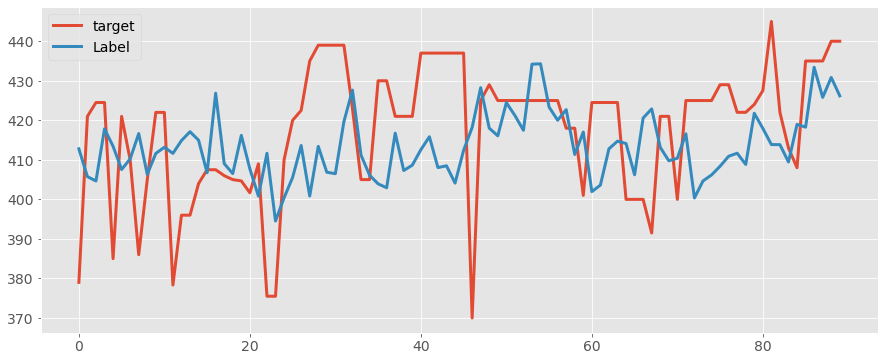

In [58]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

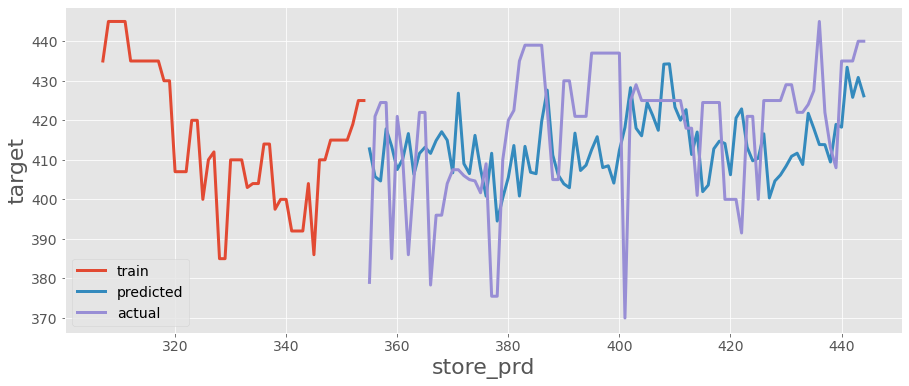

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

##### Extra Trees - MAE 8.4127, RMSE 9.8022, R2 0.3291

In [60]:
et180 = py180.create_model('et')

In [61]:
tuned_et180 = py180.tune_model(et180, optimize='RMSE', choose_better=True)

In [62]:
df_val180 = py180.predict_model(et180)

Model    MAE      MSE    RMSE     R2  RMSLE    MAPE
0  Extra Trees Regressor  5.832  48.8123  6.9866  0.778  0.017  0.0142

In [63]:
df_test180 = py180.predict_model(et180, data=test_win180)
df_test180

shoe_size_10  target  store_frd  store_prd           1           2  \
0              1   379.0       85.0      355.0  390.666667  377.500000   
1              1   421.0       86.0      356.0  377.500000  389.666667   
2              1   424.5       87.0      357.0  389.666667  376.000000   
3              1   424.5       88.0      358.0  376.000000  392.333333   
4              1   385.0       89.0      359.0  392.333333  391.750000   
..           ...     ...        ...        ...         ...         ...   
85             1   435.0      170.0      440.0  396.000000  410.000000   
86             1   435.0      171.0      441.0  410.000000  420.000000   
87             1   435.0      172.0      442.0  420.000000  422.500000   
88             1   440.0      173.0      443.0  422.500000  419.000000   
89             1   440.0      174.0      444.0  419.000000  409.000000   

             3           4           5       6  ...    172    173    174  \
0   389.666667  376.000000  392.333333  391.75  ...  408.0  408.0  408.0   
1   376.000000  392.333333  391.750000  396.75  ...  408.0  408.0  423.0   
2   392.333333  391.750000  396.750000  391.00  ...  408.0  423.0  410.0   
3   391.750000  396.750000  391.000000  398.00  ...  423.0  410.0  400.0   
4   396.750000  391.000000  398.000000  395.50  ...  410.0  400.0  416.0   
..         ...         ...         ...     ...  ...    ...    ...    ...   
85  420.000000  422.500000  419.000000  409.00  ...  392.0  392.0  392.0   
86  422.500000  419.000000  409.000000  409.00  ...  392.0  392.0  404.0   
87  419.000000  409.000000  409.000000  425.00  ...  392.0  404.0  386.0   
88  409.000000  409.000000  425.000000  417.00  ...  404.0  386.0  410.0   
89  409.000000  425.000000  417.000000  414.50  ...  386.0  410.0  410.0   

      175    176    177    178    179    180   Label  
0   423.0  410.0  400.0  416.0  425.0  425.0  414.00  
1   410.0  400.0  416.0  425.0  425.0  420.0  410.10  
2   400.0  416.0  425.0  425.0  420.0  420.0  413.24  
3   416.0  425.0  425.0  420.0  420.0  420.0  411.20  
4   425.0  425.0  420.0  420.0  420.0  408.0  413.70  
..    ...    ...    ...    ...    ...    ...     ...  
85  404.0  386.0  410.0  410.0  415.0  415.0  405.58  
86  386.0  410.0  410.0  415.0  415.0  415.0  407.63  
87  410.0  410.0  415.0  415.0  415.0  415.0  409.68  
88  410.0  415.0  415.0  415.0  415.0  419.0  411.12  
89  415.0  415.0  415.0  415.0  419.0  425.0  411.11  

[90 rows x 185 columns]

##### Extra Trees - Prediction MAE 16.574

In [64]:
check_metric(df_test180.target, df_test180.Label, 'MAE')

16.574

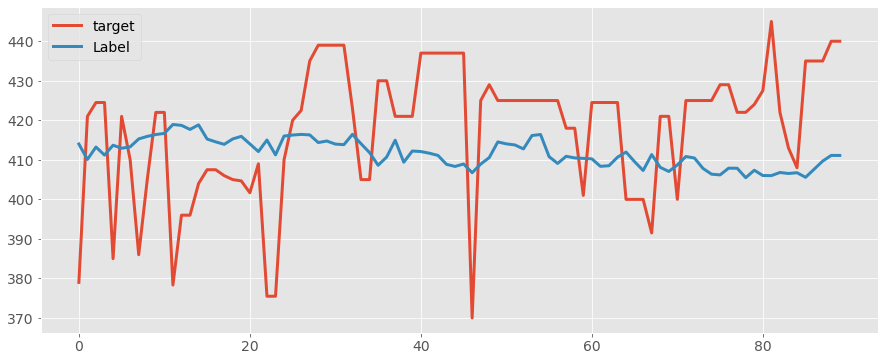

In [65]:
df_test180[df_test180['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

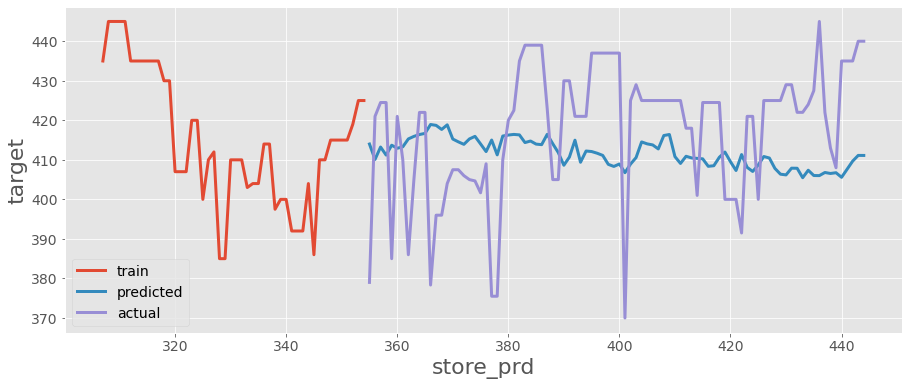

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win180[train_win180['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test180[df_test180['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

# Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue

Sneaker Name is 'Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue'
    - Didn't know reason for more than 1 month gap between end of trainin data and start of hidden test data.
        - Decided to retain Nov 15, 2018 cutoff used in Yeezy regressions
    - Best R2 is 0.7193 with 60-day lookbehind and 30-day lookahead
    - Extra Trees best for both 7-day and 30-day prediction
    - 90-Day prediction not possible, not enough data points for 180-day lookbehind


## Data Processing and EDA

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
from datetime import timedelta
from cycler import cycler

In [2]:
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
#mpl.rcParams['axes.prop_cycle'] = color=['#CF353C', 'FFE3A6', '#727272']

In [3]:
#from cycler import cycler
#plt.style.use('dark_background')
#plt.style.use('dark_background')
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'magenta', 'yellow'])

In [4]:
CUTOFF_TRAINMIN = '2018-06-01'
CUTOFF_TRAINVAL = '2018-11-15'
#yeezy Jan 1, 2018
#john jun 1, 2018

df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx', sheet_name='Raw Data')
df['Sneaker Name'] = df['Brand'] + ' - ' + df['Sneaker Name']
df['DaysStored'] = pd.Series(df['Order Date'] - df['Release Date']).apply(lambda x: x.days)
df = df[['Order Date', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
df

Order Date                                       Sneaker Name  \
0     2017-09-01       Yeezy - Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
2     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
3     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     2017-09-01   Yeezy - Adidas-Yeezy-Boost-350-V2-Core-Black-...   
...          ...                                                ...   
99951 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99952 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99953 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99954 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   
99955 2019-02-13   Yeezy - adidas-Yeezy-Boost-350-V2-Static-Refl...   

       Shoe Size  Sale Price  DaysStored  
0           11.0      1097.0         342  
1           11.0       685.0         282  
2           11.0       690.0         282  
3           11.5      1075.0         282  
4           11.0       828.0         202  
...          ...         ...         ...  
99951        8.0       565.0          49  
99952        8.5       598.0          49  
99953        5.5       605.0          49  
99954       11.0       650.0          49  
99955       11.5       640.0          49  

[99956 rows x 5 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Sneaker Name  99956 non-null  object        
 2   Shoe Size     99956 non-null  float64       
 3   Sale Price    99956 non-null  float64       
 4   DaysStored    99956 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 3.8+ MB


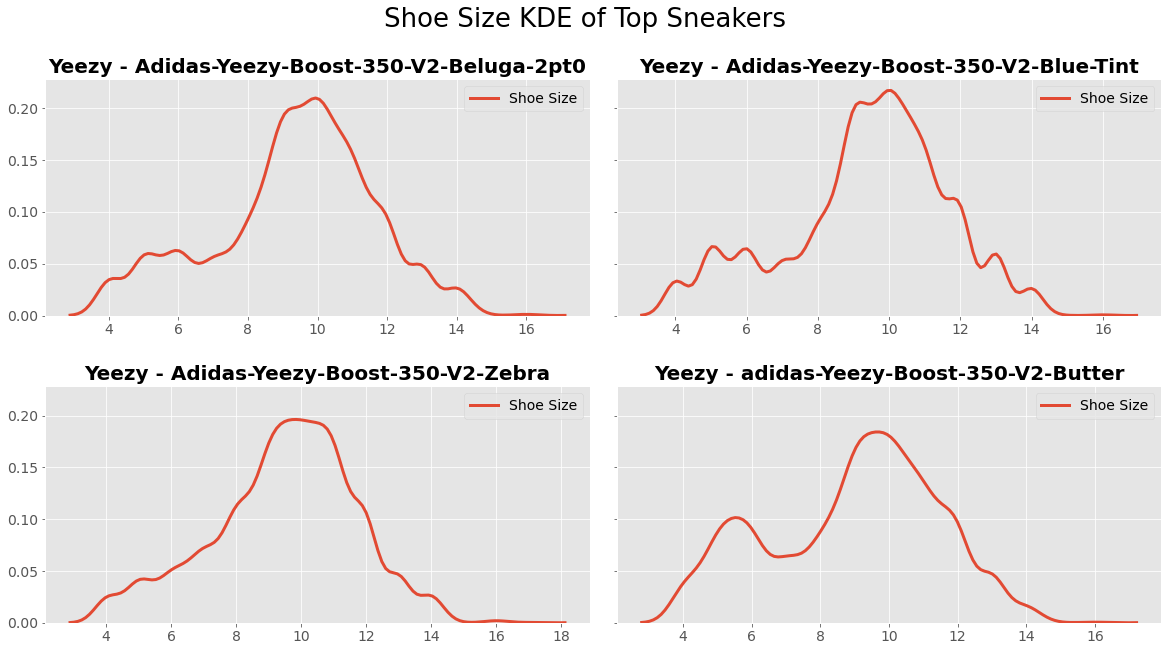

In [6]:
top_sneakers = df.groupby(['Sneaker Name', 'Shoe Size']).size().reset_index().nlargest(9, 0)['Sneaker Name'].to_list()
top_sneakers = sorted(list(set(top_sneakers)))

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharey = True)
fig.subplots_adjust(hspace=0.3, wspace=0.05)
fig.suptitle('Shoe Size KDE of Top Sneakers')

x, y = 0, 0
for i in range(0, len(top_sneakers)):
    x, y = int(i/2), i % 2
    sns.kdeplot(data=df[df['Sneaker Name']==top_sneakers[i]]['Shoe Size'], ax=ax[x][y])
    ax[x][y].set_title(top_sneakers[i].strip(), fontsize=20)

### Filter to single Sneaker Name

In [7]:
top_sneakers

[' Yeezy - Adidas-Yeezy-Boost-350-V2-Beluga-2pt0',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Blue-Tint',
 ' Yeezy - Adidas-Yeezy-Boost-350-V2-Zebra',
 ' Yeezy - adidas-Yeezy-Boost-350-V2-Butter']

In [8]:
sneaker_name = 'Off-White - Air-Jordan-1-Retro-High-Off-White-University-Blue'

df_agg = df[(df['Sneaker Name']==sneaker_name) & \
            (df['Shoe Size'].isin([10]))].copy()
df_agg = df_agg.groupby(['Order Date', 'Sneaker Name', 'Shoe Size']).mean().reset_index()
df_agg

Order Date                                       Sneaker Name  Shoe Size  \
0   2018-05-23  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
1   2018-05-24  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
2   2018-05-25  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
3   2018-05-26  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
4   2018-05-27  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
..         ...                                                ...        ...   
158 2019-02-07  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
159 2019-02-08  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
160 2019-02-10  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
161 2019-02-11  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   
162 2019-02-13  Off-White - Air-Jordan-1-Retro-High-Off-White-...       10.0   

      Sale Price  DaysStored  
0    1480.800000         -31  
1    1317.222222         -30  
2    1191.176471         -29  
3    1071.666667         -28  
4    1009.571429         -27  
..           ...         ...  
158   941.333333         229  
159   935.000000         230  
160   970.000000         232  
161   955.000000         233  
162  1010.000000         235  

[163 rows x 5 columns]

In [9]:
#start_dt = df_agg['Order Date'].min()
start_dt = datetime.strptime(CUTOFF_TRAINMIN, '%Y-%m-%d')
end_dt = df_agg['Order Date'].max()

df_cal = pd.DataFrame({'dt': pd.date_range(start_dt, end_dt)})
df_cal['dt_str'] = df_cal['dt'].apply(lambda x: x.strftime('%Y-%m-%d'))

df_cal['lst_lb15'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(15 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb30'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(30 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb60'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(60 - 1)).strftime('%Y-%m-%d').to_list())
df_cal['lst_lb180'] = df_cal['dt'].apply(lambda x: pd.date_range(x, x + timedelta(180 - 1)).strftime('%Y-%m-%d').to_list())

df_cal['lb15_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(15 - 1)).strftime('%Y-%m-%d'))
df_cal['lb30_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(30 - 1)).strftime('%Y-%m-%d'))
df_cal['lb60_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(60 - 1)).strftime('%Y-%m-%d'))
df_cal['lb180_last'] = df_cal['dt'].apply(lambda x: (x + timedelta(180 - 1)).strftime('%Y-%m-%d'))

df_cal['lb15_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(22)).strftime('%Y-%m-%d'))
df_cal['lb30_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(37)).strftime('%Y-%m-%d'))
df_cal['lb60_plus7'] = df_cal['dt'].apply(lambda x: (x + timedelta(67)).strftime('%Y-%m-%d'))

df_cal['lb60_plus30'] = df_cal['dt'].apply(lambda x: (x + timedelta(90)).strftime('%Y-%m-%d'))
df_cal['lb180_plus90'] = df_cal['dt'].apply(lambda x: (x + timedelta(270)).strftime('%Y-%m-%d'))


print(df_cal.shape, df_cal.columns)
df_cal.head(5)

(258, 15) Index(['dt', 'dt_str', 'lst_lb15', 'lst_lb30', 'lst_lb60', 'lst_lb180',
       'lb15_last', 'lb30_last', 'lb60_last', 'lb180_last', 'lb15_plus7',
       'lb30_plus7', 'lb60_plus7', 'lb60_plus30', 'lb180_plus90'],
      dtype='object')


dt      dt_str                                           lst_lb15  \
0 2018-06-01  2018-06-01  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1 2018-06-02  2018-06-02  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2 2018-06-03  2018-06-03  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3 2018-06-04  2018-06-04  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4 2018-06-05  2018-06-05  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                            lst_lb30  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                            lst_lb60  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...   

                                           lst_lb180   lb15_last   lb30_last  \
0  [2018-06-01, 2018-06-02, 2018-06-03, 2018-06-0...  2018-06-15  2018-06-30   
1  [2018-06-02, 2018-06-03, 2018-06-04, 2018-06-0...  2018-06-16  2018-07-01   
2  [2018-06-03, 2018-06-04, 2018-06-05, 2018-06-0...  2018-06-17  2018-07-02   
3  [2018-06-04, 2018-06-05, 2018-06-06, 2018-06-0...  2018-06-18  2018-07-03   
4  [2018-06-05, 2018-06-06, 2018-06-07, 2018-06-0...  2018-06-19  2018-07-04   

    lb60_last  lb180_last  lb15_plus7  lb30_plus7  lb60_plus7 lb60_plus30  \
0  2018-07-30  2018-11-27  2018-06-23  2018-07-08  2018-08-07  2018-08-30   
1  2018-07-31  2018-11-28  2018-06-24  2018-07-09  2018-08-08  2018-08-31   
2  2018-08-01  2018-11-29  2018-06-25  2018-07-10  2018-08-09  2018-09-01   
3  2018-08-02  2018-11-30  2018-06-26  2018-07-11  2018-08-10  2018-09-02   
4  2018-08-03  2018-12-01  2018-06-27  2018-07-12  2018-08-11  2018-09-03   

  lb180_plus90  
0   2019-02-26  
1   2019-02-27  
2   2019-02-28  
3   2019-03-01  
4   2019-03-02

In [10]:
df_tmp = df_cal[['dt', 'dt_str']].copy()
df_tmp['key'] = 0
print('df_tmp.shape', df_tmp.shape)

df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Sneaker Name': [sneaker_name]}), how='outer')
df_tmp = df_tmp.merge(pd.DataFrame({'key': [0], 'Shoe Size': [10]}), how='outer')
df_tmp = df_tmp.merge(df_agg, how='left', left_on=['dt', 'Sneaker Name', 'Shoe Size'], right_on=['Order Date', 'Sneaker Name', 'Shoe Size'])
df_tmp = df_tmp[['dt_str', 'Sneaker Name', 'Shoe Size', 'Sale Price', 'DaysStored']]
print('df_tmp.shape', df_tmp.shape)
df_tmp.head(5)

df_tmp.shape (258, 3)
df_tmp.shape (258, 5)


dt_str                                       Sneaker Name  Shoe Size  \
0  2018-06-01  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
1  2018-06-02  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
2  2018-06-03  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
3  2018-06-04  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   
4  2018-06-05  Off-White - Air-Jordan-1-Retro-High-Off-White-...         10   

   Sale Price  DaysStored  
0  916.666667       -22.0  
1  908.250000       -21.0  
2  891.750000       -20.0  
3  895.000000       -19.0  
4  890.250000       -18.0

In [11]:
pvt_price = df_tmp[['dt_str', 'Shoe Size', 'Sale Price']].copy()
pvt_price = pvt_price.pivot(index='Shoe Size', columns='dt_str', values='Sale Price')
pvt_price = pvt_price.interpolate(method='pad', axis=0, limit_direction='forward')
print('pvt_price.shape', pvt_price.shape)

pvt_price_diff = pvt_price.diff(axis=1)
pvt_price_diff = pvt_price_diff.reset_index()
pvt_price = pvt_price.reset_index()
print(pvt_price['Shoe Size'])

pvt_store = df_tmp[['dt_str', 'Shoe Size', 'DaysStored']].copy()
pvt_store = pvt_store.pivot(index='Shoe Size', columns='dt_str', values='DaysStored')
pvt_store = pvt_store.interpolate(method='linear', axis=0, limit_direction='both')
pvt_store = pvt_store.interpolate(method='linear', axis=1, limit_direction='both')  # fill remaining nulls
print('pvt_store.shape', pvt_store.shape)
pvt_store = pvt_store.reset_index()
print(pvt_store['Shoe Size'])

pvt_price.shape (1, 258)
0    10
Name: Shoe Size, dtype: int64
pvt_store.shape (1, 258)
0    10
Name: Shoe Size, dtype: int64


In [12]:
pvt_price

dt_str  Shoe Size  2018-06-01  2018-06-02  2018-06-03  2018-06-04  2018-06-05  \
0              10  916.666667      908.25      891.75       895.0      890.25   

dt_str  2018-06-06  2018-06-07  2018-06-08  2018-06-09  ...  2019-02-04  \
0            895.0       873.4       850.0       898.5  ...       986.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0            986.0       937.0  941.333333       935.0       935.0   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0            970.0       955.0       955.0      1010.0  

[1 rows x 259 columns]

In [13]:
pvt_price_diff

dt_str  Shoe Size  2018-06-01  2018-06-02  2018-06-03  2018-06-04  2018-06-05  \
0              10         NaN   -8.416667       -16.5        3.25       -4.75   

dt_str  2018-06-06  2018-06-07  2018-06-08  2018-06-09  ...  2019-02-04  \
0             4.75       -21.6       -23.4        48.5  ...        -9.0   

dt_str  2019-02-05  2019-02-06  2019-02-07  2019-02-08  2019-02-09  \
0              0.0       -49.0    4.333333   -6.333333         0.0   

dt_str  2019-02-10  2019-02-11  2019-02-12  2019-02-13  
0             35.0       -15.0         0.0        55.0  

[1 rows x 259 columns]

In [14]:
df_results = pd.DataFrame({'scenario': pd.Series([], dtype=str),
                           'model': pd.Series([], dtype=str),
                           'MAE': pd.Series([], dtype=np.half),
                           'MSE': pd.Series([], dtype=np.half),
                           'RMSE': pd.Series([], dtype=np.half),
                           'R2': pd.Series([], dtype=np.half),
                           'RMSLE': pd.Series([], dtype=np.half),
                           'MAPE': pd.Series([], dtype=np.half)})
df_results

Empty DataFrame
Columns: [scenario, model, MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

## Regression

In [15]:
import pycaret.regression as py15
import pycaret.regression as py60
import pycaret.regression as py180
from pycaret.utils import check_metric

### Models List

In [16]:
py15.models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm                  Support Vector Machine   
knn                   K Neighbors Regressor   
dt                            Decision Tree   
rf                            Random Forest   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                  Multi Level Perceptron   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                           Reference  Turbo  
ID                                                           
lr             sklearn.linear_model.LinearRegression   True  
lasso                     sklearn.linear_model.Lasso   True  
ridge                     sklearn.linear_model.Ridge   True  
en                   sklearn.linear_model.ElasticNet   True  
lar                        sklearn.linear_model.Lars   True  
llar                  sklearn.linear_model.LassoLars   True  
omp                         sklearn.linear_model.OMP   True  
br                sklearn.linear_model.BayesianRidge   True  
ard               sklearn.linear_model.ARDRegression  False  
par                         sklearn.linear_model.PAR   True  
ransac          sklearn.linear_model.RANSACRegressor   True  
tr            sklearn.linear_model.TheilSenRegressor   True  
huber            sklearn.linear_model.HuberRegressor   True  
kr                  sklearn.kernel_ridge.KernelRidge  False  
svm                                  sklearn.svm.SVR   True  
knn            sklearn.neighbors.KNeighborsRegressor   True  
dt                sklearn.tree.DecisionTreeRegressor   True  
rf            sklearn.ensemble.RandomForestRegressor   True  
et              sklearn.ensemble.ExtraTreesRegressor   True  
ada               sklearn.ensemble.AdaBoostRegressor   True  
gbr       sklearn.ensemble.GradientBoostingRegressor   True  
mlp              sklearn.neural_network.MLPRegressor  False  
xgboost                       xgboost.readthedocs.io   True  
lightgbm               github.com/microsoft/LightGBM   True  
catboost                         https://catboost.ai   True

### Price (As Is), Days Stored (First Order, Predict)

#### 7-Day Prediction

##### Load Train and Test Data

In [17]:
train_win15 = df_cal[(df_cal['lb15_plus7'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb15', 'lb15_plus7']]
train_win15['label'] = train_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
train_win15['target'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win15['store_frd'] = train_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win15['store_prd'] = train_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win15['feature'] = train_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in train_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(train_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(train_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(train_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(train_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(train_win15['feature'].to_list(), axis=0)

train_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(train_win15.shape, train_win15.columns)
train_win15.head(5)

(145, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10      target  store_frd  store_prd           1       2       3  \
0             1  834.714286      -22.0        0.0  916.666667  908.25  891.75   
0             1  880.250000      -21.0        1.0  908.250000  891.75  895.00   
0             1  888.000000      -20.0        2.0  891.750000  895.00  890.25   
0             1  888.000000      -19.0        3.0  895.000000  890.25  895.00   
0             1  809.500000      -18.0        4.0  890.250000  895.00  873.40   

        4       5      6      7           8           9          10  \
0  895.00  890.25  895.0  873.4  850.000000  898.500000  879.500000   
0  890.25  895.00  873.4  850.0  898.500000  879.500000  895.000000   
0  895.00  873.40  850.0  898.5  879.500000  895.000000  835.666667   
0  873.40  850.00  898.5  879.5  895.000000  835.666667  801.000000   
0  850.00  898.50  879.5  895.0  835.666667  801.000000  835.000000   

           11          12          13          14          15  
0  895.000000  835.666667  801.000000  835.000000  809.363636  
0  835.666667  801.000000  835.000000  809.363636  781.000000  
0  801.000000  835.000000  809.363636  781.000000  750.400000  
0  835.000000  809.363636  781.000000  750.400000  708.466667  
0  809.363636  781.000000  750.400000  708.466667  694.357143

In [18]:
test_win15 = df_cal[(df_cal['lb15_plus7'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb15_plus7'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb15', 'lb15_plus7']]
test_win15['label'] = test_win15['lb15_plus7'].apply(lambda x: pvt_price[['Shoe Size']])
test_win15['target'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win15['store_frd'] = test_win15['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win15['store_prd'] = test_win15['lb15_plus7'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win15['feature'] = test_win15['lst_lb15'].apply(lambda x: pvt_price[x])
for row in test_win15['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label15 = pd.concat(test_win15['label'].to_list(), axis=0)
label15 = pd.get_dummies(label15['Shoe Size'], prefix='shoe_size')
target15 = pd.concat(test_win15['target'].to_list(), axis=0)
store15_frd = pd.concat(test_win15['store_frd'].to_list(), axis=0)
store15_prd = pd.concat(test_win15['store_prd'].to_list(), axis=0)
feature15 = pd.concat(test_win15['feature'].to_list(), axis=0)

test_win15 = pd.concat([label15, target15, store15_frd, store15_prd, feature15], axis=1)
print(test_win15.shape, test_win15.columns)
test_win15.head(5)

(90, 19) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15],
      dtype='object')


shoe_size_10  target  store_frd  store_prd      1      2      3       4  \
0             1   892.5      123.0      145.0  920.0  935.0  935.0  935.00   
0             1   891.5      124.0      146.0  935.0  935.0  935.0  935.00   
0             1   891.5      125.0      147.0  935.0  935.0  935.0  911.00   
0             1   840.0      126.0      148.0  935.0  935.0  911.0  911.00   
0             1   867.5      127.0      149.0  935.0  911.0  911.0  861.25   

        5       6       7       8       9      10      11      12     13  \
0  935.00  911.00  911.00  861.25  861.25  861.25  861.25  861.25  885.0   
0  911.00  911.00  861.25  861.25  861.25  861.25  861.25  885.00  890.0   
0  911.00  861.25  861.25  861.25  861.25  861.25  885.00  890.00  900.0   
0  861.25  861.25  861.25  861.25  861.25  885.00  890.00  900.00  900.0   
0  861.25  861.25  861.25  861.25  885.00  890.00  900.00  900.00  904.0   

      14     15  
0  890.0  900.0  
0  900.0  900.0  
0  900.0  904.0  
0  904.0  904.0  
0  904.0  895.0

In [19]:
ret = py15.setup(data=train_win15, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [20]:
py15.compare_models(sort='R2')

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=123)

In [21]:
py15.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 25.5672, RMSE 37.9280, R2 0.6746

In [22]:
et15 = py15.create_model('et')

In [23]:
tuned_et15 = py15.tune_model(et15, optimize='RMSE', choose_better=True)

In [24]:
df_val15 = py15.predict_model(et15)

Model      MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  17.1772  552.0487  23.4957  0.8647  0.0275  0.0203

In [25]:
df_test15 = py15.predict_model(et15, data=test_win15)
df_test15

shoe_size_10  target  store_frd  store_prd      1      2      3       4  \
0              1   892.5      123.0      145.0  920.0  935.0  935.0  935.00   
1              1   891.5      124.0      146.0  935.0  935.0  935.0  935.00   
2              1   891.5      125.0      147.0  935.0  935.0  935.0  911.00   
3              1   840.0      126.0      148.0  935.0  935.0  911.0  911.00   
4              1   867.5      127.0      149.0  935.0  911.0  911.0  861.25   
..           ...     ...        ...        ...    ...    ...    ...     ...   
85             1   935.0      208.0      230.0  905.0  905.0  905.0  905.00   
86             1   935.0      209.0      231.0  905.0  905.0  905.0  905.00   
87             1   970.0      210.0      232.0  905.0  905.0  905.0  905.00   
88             1   955.0      211.0      233.0  905.0  905.0  905.0  905.00   
89             1   955.0      212.0      234.0  905.0  905.0  905.0  905.00   

         5       6       7       8       9      10      11      12     13  \
0   935.00  911.00  911.00  861.25  861.25  861.25  861.25  861.25  885.0   
1   911.00  911.00  861.25  861.25  861.25  861.25  861.25  885.00  890.0   
2   911.00  861.25  861.25  861.25  861.25  861.25  885.00  890.00  900.0   
3   861.25  861.25  861.25  861.25  861.25  885.00  890.00  900.00  900.0   
4   861.25  861.25  861.25  861.25  885.00  890.00  900.00  900.00  904.0   
..     ...     ...     ...     ...     ...     ...     ...     ...    ...   
85  905.00  905.00  905.00  905.00  962.50  962.50  962.50  977.00  975.0   
86  905.00  905.00  905.00  962.50  962.50  962.50  977.00  975.00  975.0   
87  905.00  905.00  962.50  962.50  962.50  977.00  975.00  975.00  975.0   
88  905.00  962.50  962.50  962.50  977.00  975.00  975.00  975.00  975.0   
89  962.50  962.50  962.50  977.00  975.00  975.00  975.00  975.00  975.0   

       14     15     Label  
0   890.0  900.0  880.5175  
1   900.0  900.0  902.3050  
2   900.0  904.0  907.4350  
3   904.0  904.0  910.6825  
4   904.0  895.0  912.0375  
..    ...    ...       ...  
85  975.0  975.0  921.7158  
86  975.0  975.0  926.0700  
87  975.0  975.0  924.7958  
88  975.0  995.0  925.2492  
89  995.0  986.0  926.1217  

[90 rows x 20 columns]

##### Extra Trees - Prediction MAE 32.462

In [26]:
check_metric(df_test15.target, df_test15.Label, 'MAE')

32.462

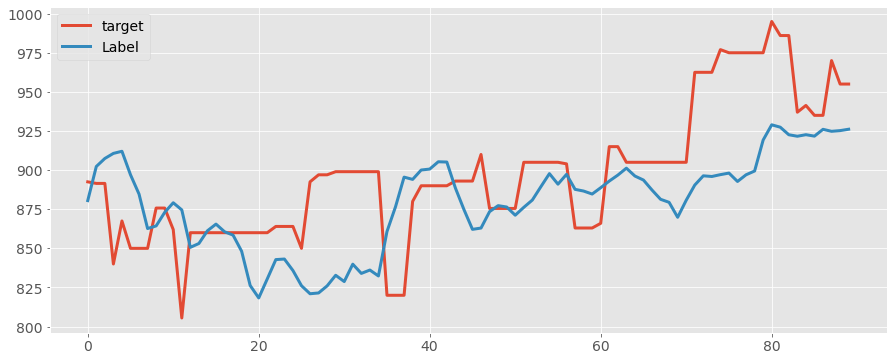

In [27]:
df_test15[df_test15['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

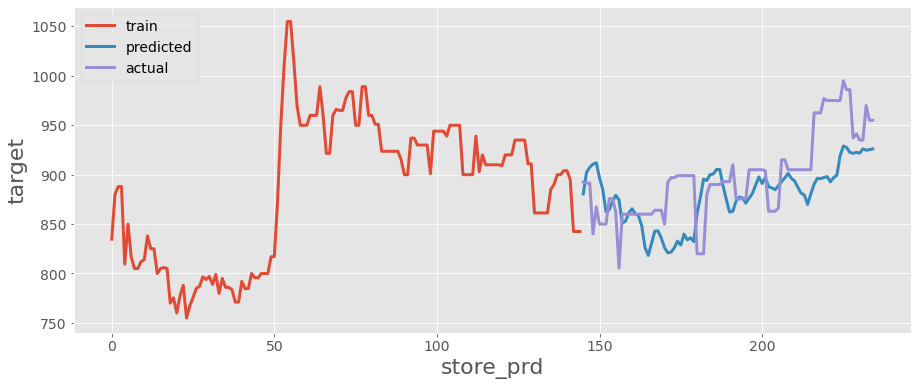

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win15[train_win15['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test15[df_test15['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 30-Day Prediction

##### Load Train and Test Data

In [29]:
train_win60 = df_cal[(df_cal['lb60_plus30'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb60', 'lb60_plus30']]
train_win60['label'] = train_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
train_win60['target'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win60['store_frd'] = train_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win60['store_prd'] = train_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win60['feature'] = train_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in train_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(train_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(train_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(train_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(train_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(train_win60['feature'].to_list(), axis=0)

train_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(train_win60.shape, train_win60.columns)
train_win60.head(5)

(77, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd           1       2       3  \
0             1   960.0      -22.0       68.0  916.666667  908.25  891.75   
0             1   966.0      -21.0       69.0  908.250000  891.75  895.00   
0             1   965.0      -20.0       70.0  891.750000  895.00  890.25   
0             1   965.0      -19.0       71.0  895.000000  890.25  895.00   
0             1   977.5      -18.0       72.0  890.250000  895.00  873.40   

        4       5      6  ...          51      52      53      54      55  \
0  895.00  890.25  895.0  ...  796.666667  794.00  797.00  789.00  799.00   
0  890.25  895.00  873.4  ...  794.000000  797.00  789.00  799.00  779.75   
0  895.00  873.40  850.0  ...  797.000000  789.00  799.00  779.75  795.00   
0  873.40  850.00  898.5  ...  789.000000  799.00  779.75  795.00  786.00   
0  850.00  898.50  879.5  ...  799.000000  779.75  795.00  786.00  786.00   

       56     57     58     59          60  
0  779.75  795.0  786.0  786.0  783.500000  
0  795.00  786.0  786.0  783.5  771.000000  
0  786.00  786.0  783.5  771.0  771.000000  
0  786.00  783.5  771.0  771.0  792.000000  
0  783.50  771.0  771.0  792.0  784.666667  

[5 rows x 64 columns]

In [30]:
test_win60 = df_cal[(df_cal['lb60_plus30'] >= CUTOFF_TRAINVAL) & (df_cal['lb60_plus30'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb60', 'lb60_plus30']]
test_win60['label'] = test_win60['lb60_plus30'].apply(lambda x: pvt_price[['Shoe Size']])
test_win60['target'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win60['store_frd'] = test_win60['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win60['store_prd'] = test_win60['lb60_plus30'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win60['feature'] = test_win60['lst_lb60'].apply(lambda x: pvt_price[x])
for row in test_win60['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label60 = pd.concat(test_win60['label'].to_list(), axis=0)
label60 = pd.get_dummies(label60['Shoe Size'], prefix='shoe_size')
target60 = pd.concat(test_win60['target'].to_list(), axis=0)
store60_frd = pd.concat(test_win60['store_frd'].to_list(), axis=0)
store60_prd = pd.concat(test_win60['store_prd'].to_list(), axis=0)
feature60 = pd.concat(test_win60['feature'].to_list(), axis=0)

test_win60 = pd.concat([label60, target60, store60_frd, store60_prd, feature60], axis=1)
print(test_win60.shape, test_win60.columns)
test_win60.head(5)

(90, 64) Index(['shoe_size_10',       'target',    'store_frd',    'store_prd',
                    1,              2,              3,              4,
                    5,              6,              7,              8,
                    9,             10,             11,             12,
                   13,             14,             15,             16,
                   17,             18,             19,             20,
                   21,             22,             23,             24,
                   25,             26,             27,             28,
                   29,             30,             31,             32,
                   33,             34,             35,             36,
                   37,             38,             39,             40,
                   41,             42,             43,             44,
                   45,             46,             47,             48,
                   49,             50,             51,             5

shoe_size_10  target  store_frd  store_prd       1       2      3      4  \
0             1   892.5       55.0      145.0  1055.0  1014.5  969.0  950.0   
0             1   891.5       56.0      146.0  1014.5   969.0  950.0  950.0   
0             1   891.5       57.0      147.0   969.0   950.0  950.0  950.0   
0             1   840.0       58.0      148.0   950.0   950.0  950.0  960.0   
0             1   867.5       59.0      149.0   950.0   950.0  960.0  960.0   

       5      6  ...     51     52     53     54     55     56     57     58  \
0  950.0  950.0  ...  950.0  950.0  950.0  900.0  900.0  900.0  900.0  939.0   
0  950.0  960.0  ...  950.0  950.0  900.0  900.0  900.0  900.0  939.0  903.0   
0  960.0  960.0  ...  950.0  900.0  900.0  900.0  900.0  939.0  903.0  920.0   
0  960.0  960.0  ...  900.0  900.0  900.0  900.0  939.0  903.0  920.0  910.0   
0  960.0  989.0  ...  900.0  900.0  900.0  939.0  903.0  920.0  910.0  910.0   

      59     60  
0  903.0  920.0  
0  920.0  910.0  
0  910.0  910.0  
0  910.0  910.0  
0  910.0  910.0  

[5 rows x 64 columns]

In [31]:
ret = py60.setup(data=train_win60, target='target', train_size=0.80, session_id=123, silent=True)

 
Setup Succesfully Completed.


##### Compare Models

In [32]:
py60.compare_models(sort='R2')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

In [33]:
py60.compare_models(sort='RMSE')

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)

##### Extra Trees - MAE 7.9989,  RMSE 11.5214, R2 0.7193

In [34]:
et60 = py60.create_model('et')

In [35]:
tuned_et60 = py60.tune_model(et60, optimize='RMSE', choose_better=True)

In [36]:
df_val60 = py60.predict_model(et60)

Model      MAE       MSE     RMSE      R2   RMSLE    MAPE
0  Extra Trees Regressor  21.6568  811.8383  28.4928  0.6059  0.0322  0.0245

In [37]:
df_test60 = py60.predict_model(et60, data=test_win60)
df_test60

shoe_size_10  target  store_frd  store_prd       1       2      3      4  \
0              1   892.5       55.0      145.0  1055.0  1014.5  969.0  950.0   
1              1   891.5       56.0      146.0  1014.5   969.0  950.0  950.0   
2              1   891.5       57.0      147.0   969.0   950.0  950.0  950.0   
3              1   840.0       58.0      148.0   950.0   950.0  950.0  960.0   
4              1   867.5       59.0      149.0   950.0   950.0  960.0  960.0   
..           ...     ...        ...        ...     ...     ...    ...    ...   
85             1   935.0      140.0      230.0   904.0   895.0  842.5  842.5   
86             1   935.0      141.0      231.0   895.0   842.5  842.5  842.5   
87             1   970.0      142.0      232.0   842.5   842.5  842.5  892.5   
88             1   955.0      143.0      233.0   842.5   842.5  892.5  891.5   
89             1   955.0      144.0      234.0   842.5   892.5  891.5  891.5   

        5      6  ...     52     53     54     55     56     57     58     59  \
0   950.0  950.0  ...  950.0  950.0  900.0  900.0  900.0  900.0  939.0  903.0   
1   950.0  960.0  ...  950.0  900.0  900.0  900.0  900.0  939.0  903.0  920.0   
2   960.0  960.0  ...  900.0  900.0  900.0  900.0  939.0  903.0  920.0  910.0   
3   960.0  960.0  ...  900.0  900.0  900.0  939.0  903.0  920.0  910.0  910.0   
4   960.0  989.0  ...  900.0  900.0  939.0  903.0  920.0  910.0  910.0  910.0   
..    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
85  842.5  892.5  ...  910.0  875.5  875.5  875.5  875.5  905.0  905.0  905.0   
86  892.5  891.5  ...  875.5  875.5  875.5  875.5  905.0  905.0  905.0  905.0   
87  891.5  891.5  ...  875.5  875.5  875.5  905.0  905.0  905.0  905.0  905.0   
88  891.5  840.0  ...  875.5  875.5  905.0  905.0  905.0  905.0  905.0  904.0   
89  840.0  867.5  ...  875.5  905.0  905.0  905.0  905.0  905.0  904.0  863.0   

       60     Label  
0   920.0  895.2000  
1   910.0  896.7508  
2   910.0  896.4083  
3   910.0  898.5342  
4   910.0  892.4200  
..    ...       ...  
85  905.0  912.5067  
86  905.0  910.9575  
87  904.0  911.7858  
88  863.0  920.6500  
89  863.0  929.6500  

[90 rows x 65 columns]

##### Extra Trees - Prediction MAE 33.7633

In [38]:
check_metric(df_test60.target, df_test60.Label, 'MAE')

33.7633

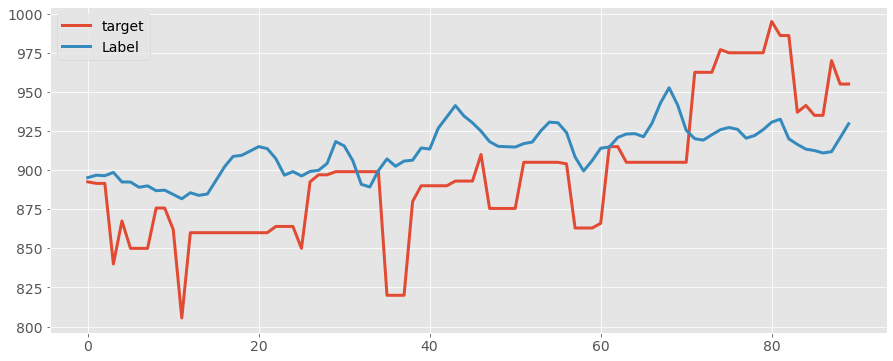

In [39]:
df_test60[df_test60['shoe_size_10']==1][['target','Label']].plot(figsize=(15,6));

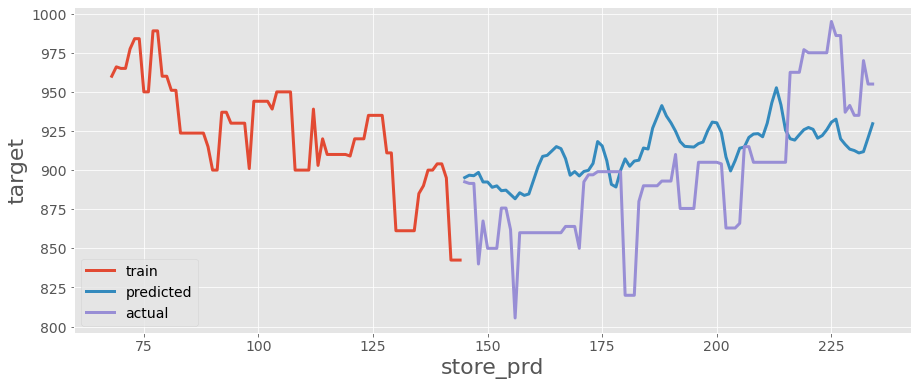

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = sns.lineplot(data=train_win60[train_win60['shoe_size_10']==1], x='store_prd', y='target', label='train', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='Label', label='predicted', ax=ax)
ax = sns.lineplot(data=df_test60[df_test60['shoe_size_10']==1], x='store_prd', y='target', label='actual', ax=ax);

#### 90-Day Prediction

##### Load Train and Test Data

ValueError encountered.  Not enough data data points for 180-day lookback window

In [41]:
train_win180 = df_cal[(df_cal['lb180_plus90'] < CUTOFF_TRAINVAL)][['dt_str', 'lst_lb180', 'lb180_plus90']]
train_win180['label'] = train_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
train_win180['target'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
train_win180['store_frd'] = train_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
train_win180['store_prd'] = train_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
train_win180['feature'] = train_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in train_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(train_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(train_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(train_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(train_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(train_win180['feature'].to_list(), axis=0)

train_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(train_win180.shape, train_win180.columns)
train_win180.head(5)


ValueError: No objects to concatenate

In [ ]:
test_win180 = df_cal[(df_cal['lb180_plus90'] >= CUTOFF_TRAINVAL) &
                    (df_cal['lb180_plus90'] < end_dt.strftime('%Y-%m-%d')) ][['dt_str', 'lst_lb180', 'lb180_plus90']]
test_win180['label'] = test_win180['lb180_plus90'].apply(lambda x: pvt_price[['Shoe Size']])
test_win180['target'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'target': pvt_price[x]}))
test_win180['store_frd'] = test_win180['dt_str'].apply(lambda x: pd.DataFrame({'store_frd': pvt_store[x]}))
test_win180['store_prd'] = test_win180['lb180_plus90'].apply(lambda x: pd.DataFrame({'store_prd': pvt_store[x]}))
test_win180['feature'] = test_win180['lst_lb180'].apply(lambda x: pvt_price[x])
for row in test_win180['feature']:
    row.columns = np.arange(1, len(row.columns) + 1)

label180 = pd.concat(test_win180['label'].to_list(), axis=0)
label180 = pd.get_dummies(label180['Shoe Size'], prefix='shoe_size')
target180 = pd.concat(test_win180['target'].to_list(), axis=0)
store180_frd = pd.concat(test_win180['store_frd'].to_list(), axis=0)
store180_prd = pd.concat(test_win180['store_prd'].to_list(), axis=0)
feature180 = pd.concat(test_win180['feature'].to_list(), axis=0)

test_win180 = pd.concat([label180, target180, store180_frd, store180_prd, feature180], axis=1)
print(test_win180.shape, test_win180.columns)
test_win180.head(5)


In [ ]:
ret = py180.setup(data=train_win180, target='target', train_size=0.80, session_id=123, silent=True)

##### Compare Models

In [ ]:
py180.compare_models(sort='R2')

In [ ]:
py180.compare_models(sort='RMSE')

# ARIMA

# DATA PROCESSING

## Interpolation

In [15]:
def fill_dates(df, start, end):
    """Fill the dates of the data frame from start to end"""
    df_new = pd.DataFrame(columns=['Order Date'])
    df_new['Order Date'] = pd.date_range(start=start, end=end)
    df_new = pd.merge(df_new, df, on='Order Date', how='left')

    # Impute missing values
    brand = df['Brand'].values[0]
    sneaker_name = df['Sneaker Name'].values[0]
    retail_price = df['Retail Price'].values[0]
    shoe_size = df['Shoe Size'].values[0]

    df_new['Brand'] = df_new['Brand'].fillna(brand)
    df_new['Sneaker Name'] = (df_new['Sneaker Name'].fillna(sneaker_name))
    df_new['Retail Price'] = (df_new['Retail Price'].fillna(retail_price))
    df_new['Shoe Size'] = (df_new['Shoe Size'].fillna(shoe_size))
    df_new['Sale Price'] = (df_new['Sale Price'].interpolate(method='ffill'))
    return df_new

### Yeezy Beluga

In [16]:
start_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                                 > '2018-01-01', 'Order Date'].min()
end_date = yeezy_beluga_10.loc[yeezy_beluga_10['Order Date']
                               > '2018-01-01', 'Order Date'].max()
yeezy_beluga_10_new = fill_dates(yeezy_beluga_10, start_date, end_date)

Highest price is 450.00 USD
Lowest price is 358.00 USD


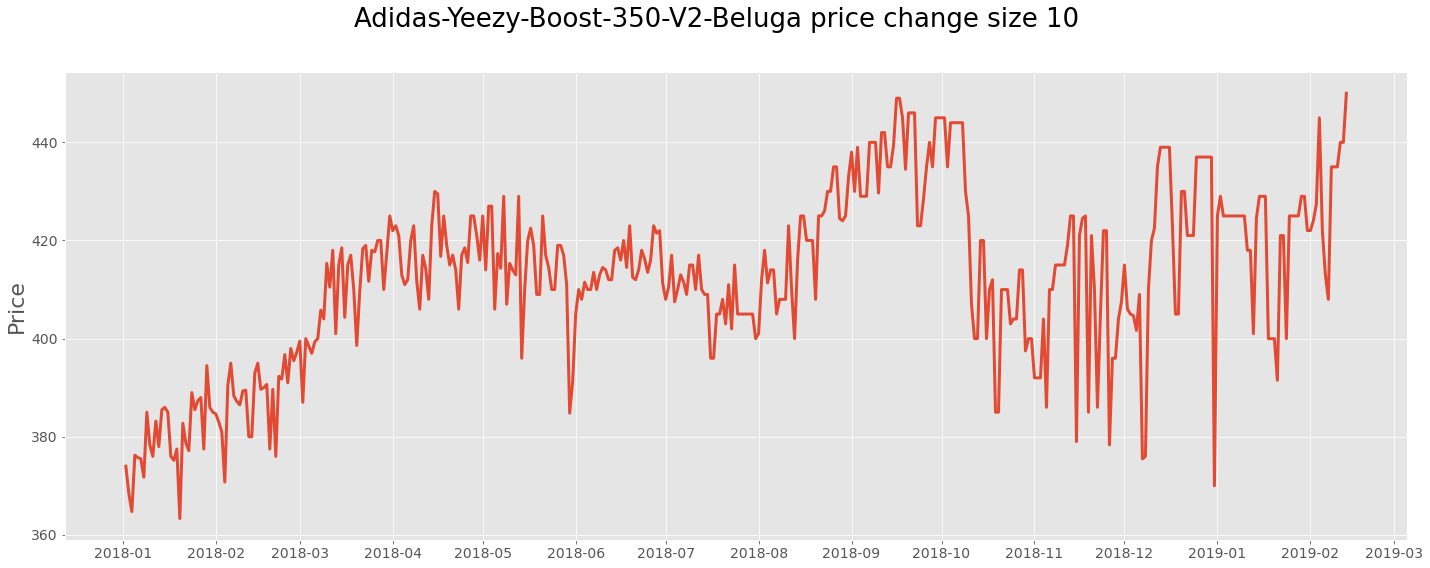

In [17]:
print('Highest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].max())
print('Lowest price is %.2f USD' % yeezy_beluga_10_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
        .mean().sort_index())

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle('Adidas-Yeezy-Boost-350-V2-Beluga price change size 10')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

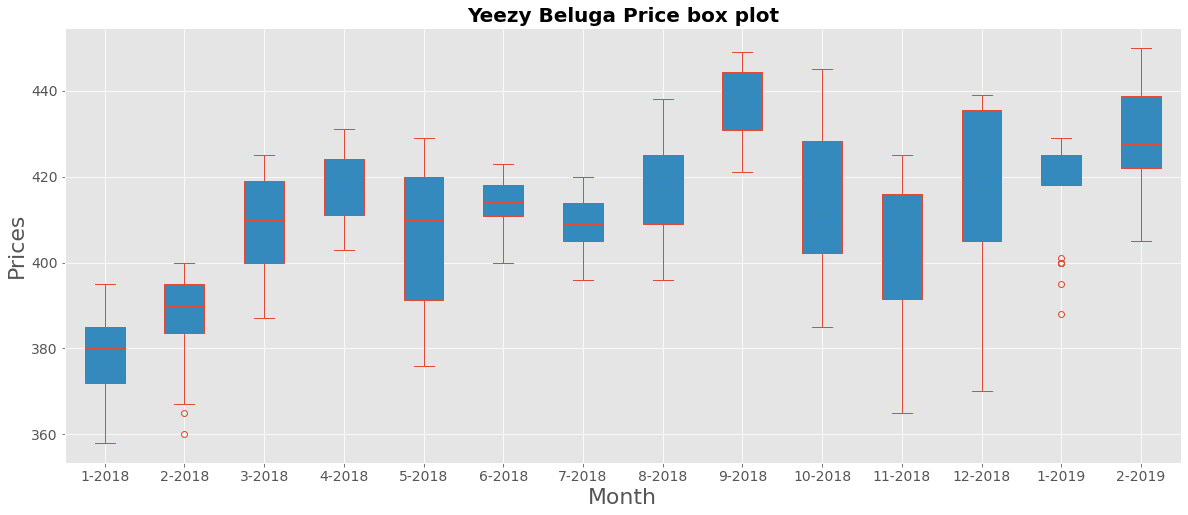

In [18]:
groups = yeezy_beluga_10_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Yeezy Beluga Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

### Jordan 1 Off-white

In [19]:
start_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                    > '2018-06-01', 'Order Date'].min()
end_date = jordan1_uni_blue_9.loc[jordan1_uni_blue_9['Order Date']
                                  > '2018-01-01', 'Order Date'].max()
jordan1_uni_blue_9_new = fill_dates(jordan1_uni_blue_9, start_date, end_date)

Highest price is 1216.00 USD
Lowest price is 790.00 USD


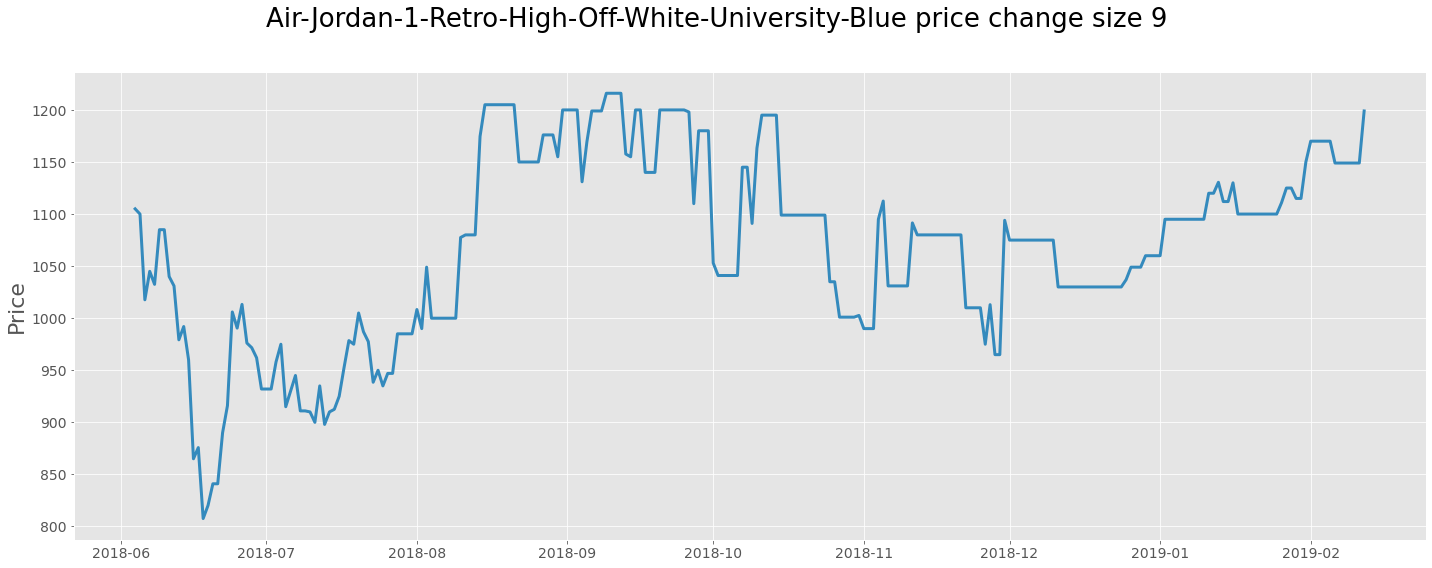

In [20]:
print('Highest price is %.2f USD' %
      jordan1_uni_blue_9_new['Sale Price'].max())
print('Lowest price is %.2f USD' % jordan1_uni_blue_9_new['Sale Price'].min())


fig, ax = plt.subplots(figsize=(20, 8), sharex=True)
ax.plot(jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
        .mean().sort_index(), color='#348ABD')

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%m-%y')

# # format the ticks
ax.xaxis.set_major_locator(months)
ax.set_ylabel('Price')

plt.suptitle(
    'Air-Jordan-1-Retro-High-Off-White-University-Blue price change size 9')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

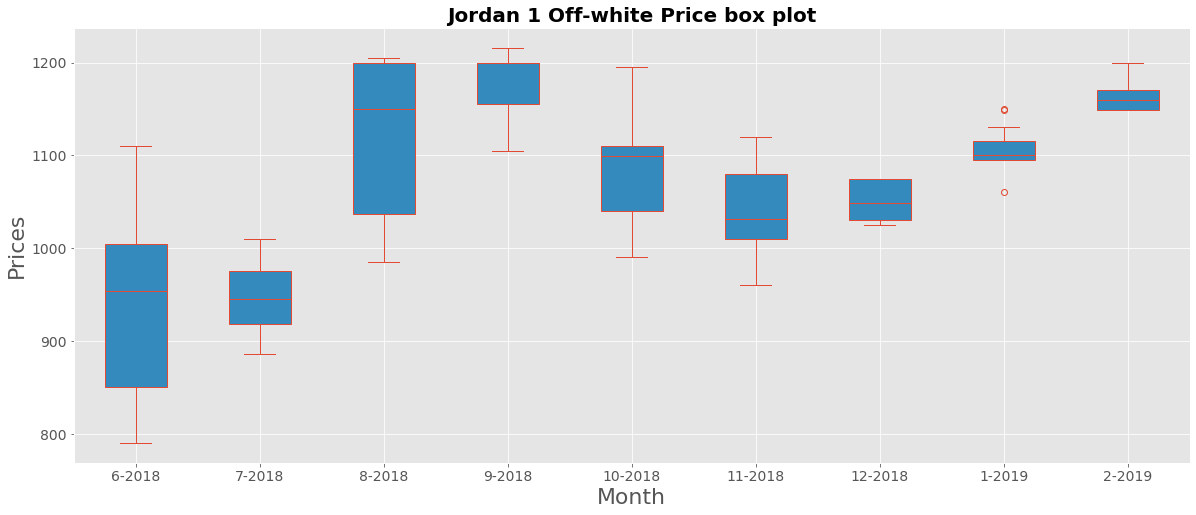

In [21]:
groups = jordan1_uni_blue_9_new.groupby(pd.Grouper(key='Order Date', freq='MS',
                                                   label='left'))['Sale Price']

months = dict()
for name, group in groups:
    months[f'{name.month}-{name.year}'] = list(group.values)

plt.figure(figsize=(20, 8))
plt.boxplot(months.values(), patch_artist=True,
            boxprops=dict(color='#E24A33'),
            whiskerprops=dict(color='#E24A33'),
            flierprops=dict(color='#E24A33', markeredgecolor='#E24A33'),
            medianprops=dict(color='#E24A33'),
            capprops=dict(color='#E24A33'))

plt.title('Jordan 1 Off-white Price box plot')
plt.xlabel('Month')
plt.ylabel('Prices')
plt.xticks(range(1, len(months.keys()) + 1), months.keys())


del months
del groups

# Grid Search ARIMA Yeezy Beluga

In [22]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=7).mean()
    rolling_std = timeseries.rolling(window=7).std()

    # rolling statistics plot
    fig = plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    fig.autofmt_xdate()

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, predictions)
    return mae, rmse, r2, test, predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(1, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, predictions)
    mae = mean_absolute_error(y, predictions)
    return mae, rmse, r2, y, predictions

In [23]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

## Raw Data

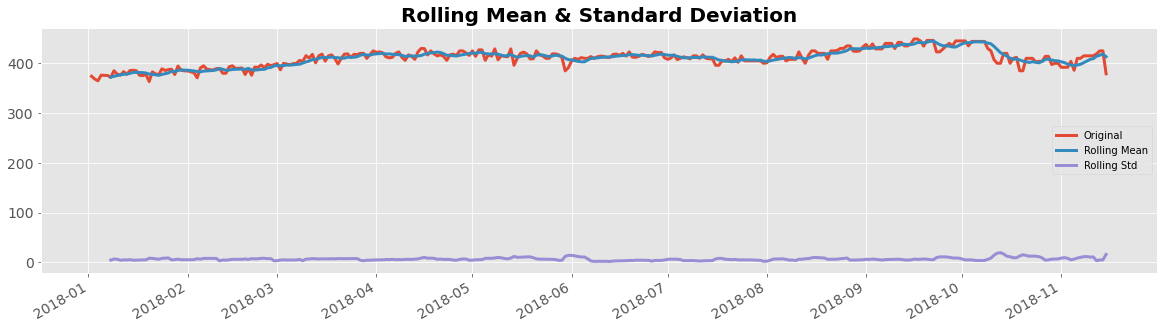

ADF Statistic: -2.6115298788689048
p-value: 0.09063761391742214
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


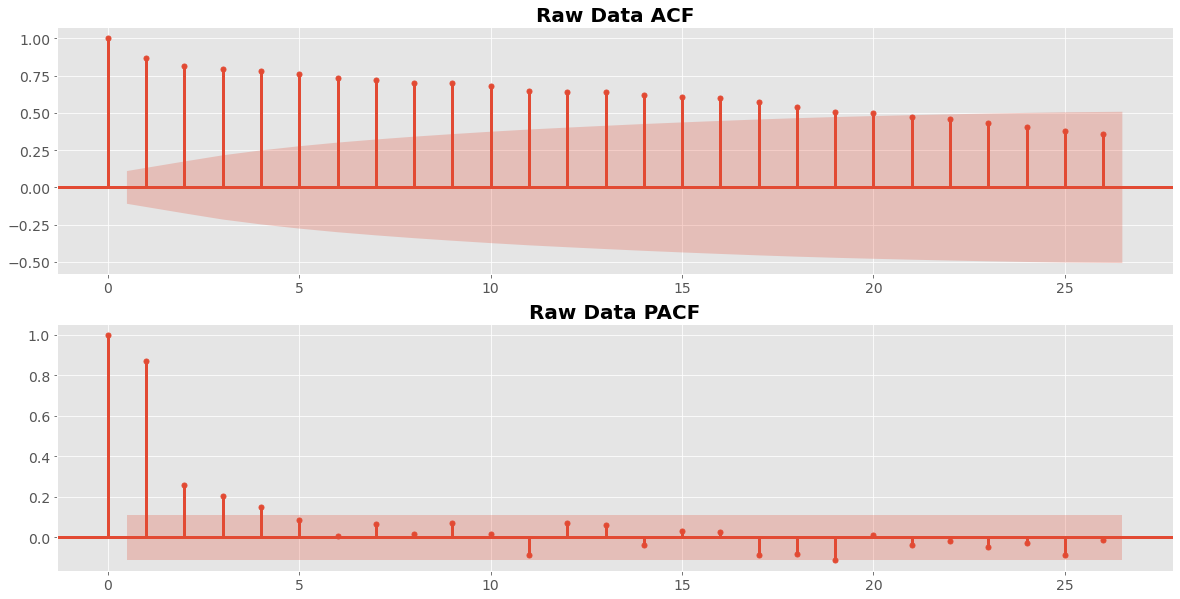

In [24]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

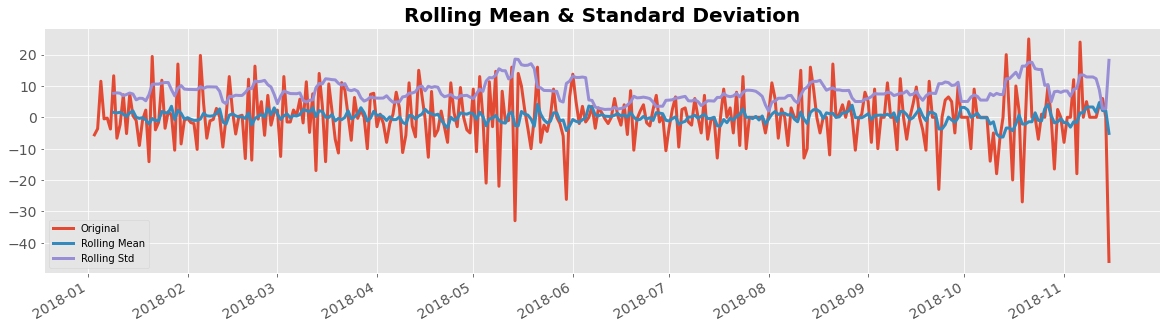

ADF Statistic: -12.47302067209256
p-value: 3.213459931884452e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


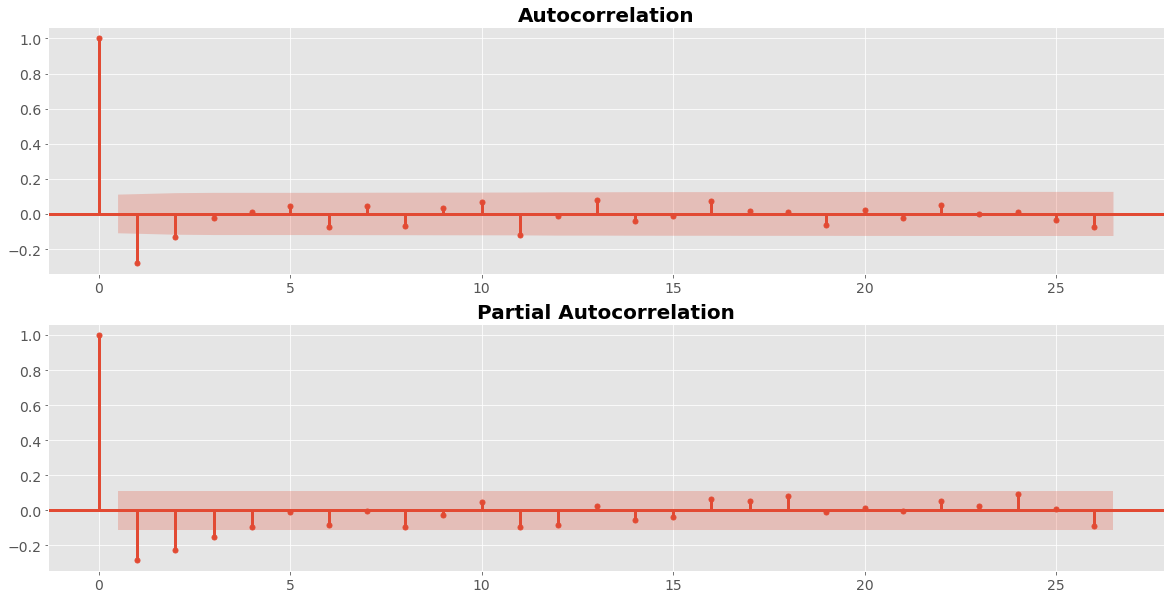

In [25]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

## LOCF Difference + Window 7

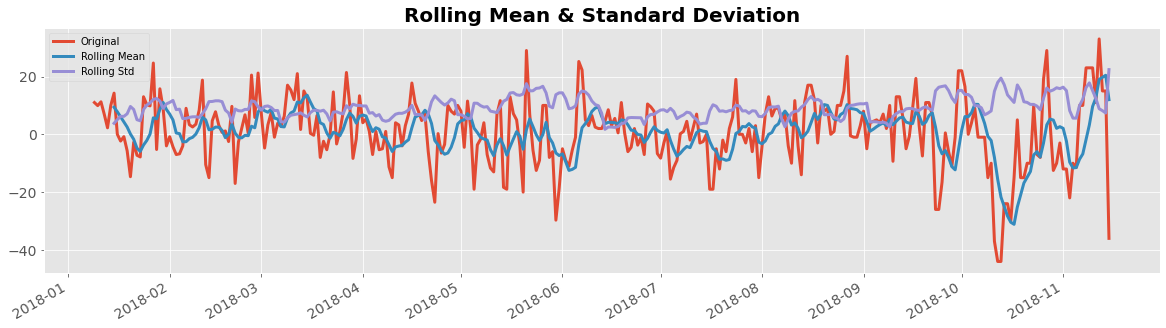

ADF Statistic: -3.169655151564709
p-value: 0.021809730019075612
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


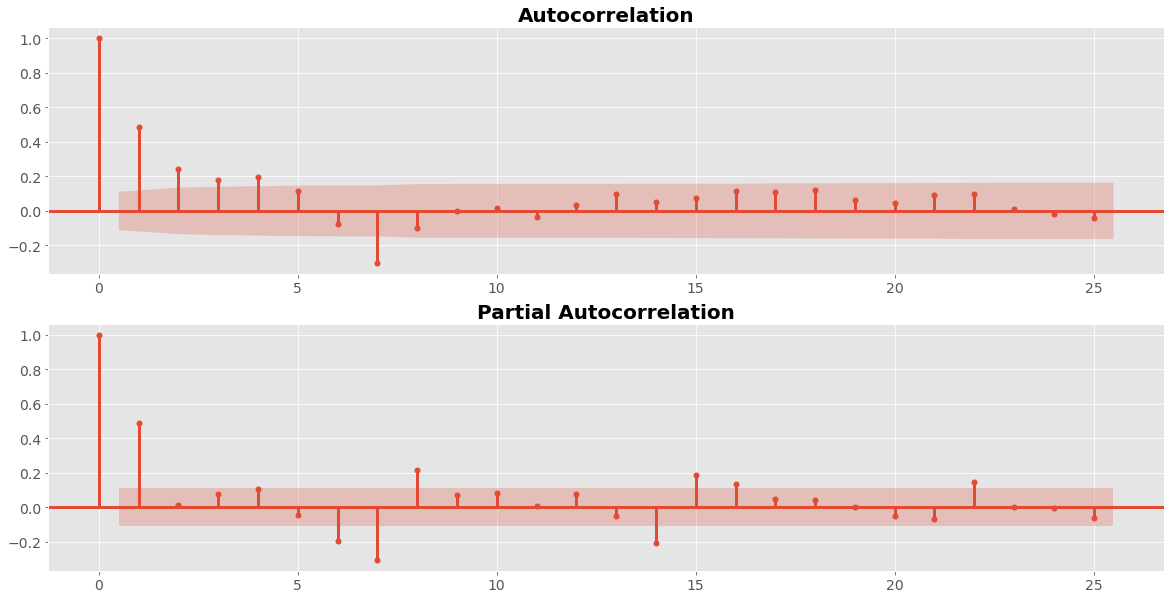

In [26]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [26]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 7.899 RMSE = 10.600 R2 = 0.673
ARIMA (0, 0, 2) MAE = 7.589 RMSE = 10.348 R2 = 0.688
ARIMA (0, 1, 1) MAE = 6.453 RMSE = 10.484 R2 = 0.680
ARIMA (0, 1, 2) MAE = 7.808 RMSE = 10.747 R2 = 0.664
ARIMA (1, 0, 0) MAE = 7.305 RMSE = 10.513 R2 = 0.678
ARIMA (1, 0, 1) MAE = 7.584 RMSE = 10.368 R2 = 0.687
ARIMA (1, 0, 2) MAE = 7.634 RMSE = 10.390 R2 = 0.686
ARIMA (1, 1, 0) MAE = 9.804 RMSE = 13.422 R2 = 0.476
ARIMA (2, 0, 0) MAE = 7.534 RMSE = 10.371 R2 = 0.687
ARIMA (2, 0, 1) MAE = 7.602 RMSE = 10.385 R2 = 0.686
ARIMA (2, 0, 2) MAE = 7.646 RMSE = 10.439 R2 = 0.683
ARIMA (2, 1, 0) MAE = 8.925 RMSE = 12.708 R2 = 0.530
ARIMA (3, 0, 0) MAE = 7.497 RMSE = 10.268 R2 = 0.693
ARIMA (3, 0, 1) MAE = 7.604 RMSE = 10.405 R2 = 0.685
ARIMA (3, 1, 0) MAE = 8.319 RMSE = 11.821 R2 = 0.593

Best ARIMA (0, 1, 1) MAE=6.453 RMSE= 10.484


## Inspect best result

               0
count  79.000000
mean   -0.760458
std    10.522793
min   -46.161887
25%    -2.524455
50%    -0.132249
75%     4.440340
max    24.962078
MAE=6.453 RMSE=10.484 R2=0.680


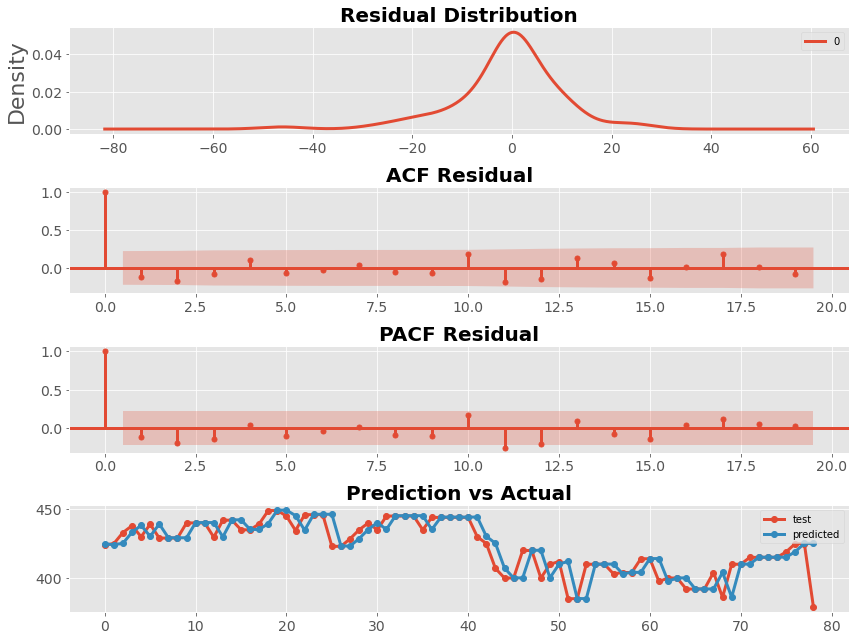

In [28]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Add bias based on residual error

                  0
count  7.900000e+01
mean  -1.439074e-14
std    1.052279e+01
min   -4.540143e+01
25%   -1.763997e+00
50%    6.282091e-01
75%    5.200798e+00
max    2.572254e+01
MAE=6.664 RMSE=10.456 R2=0.682


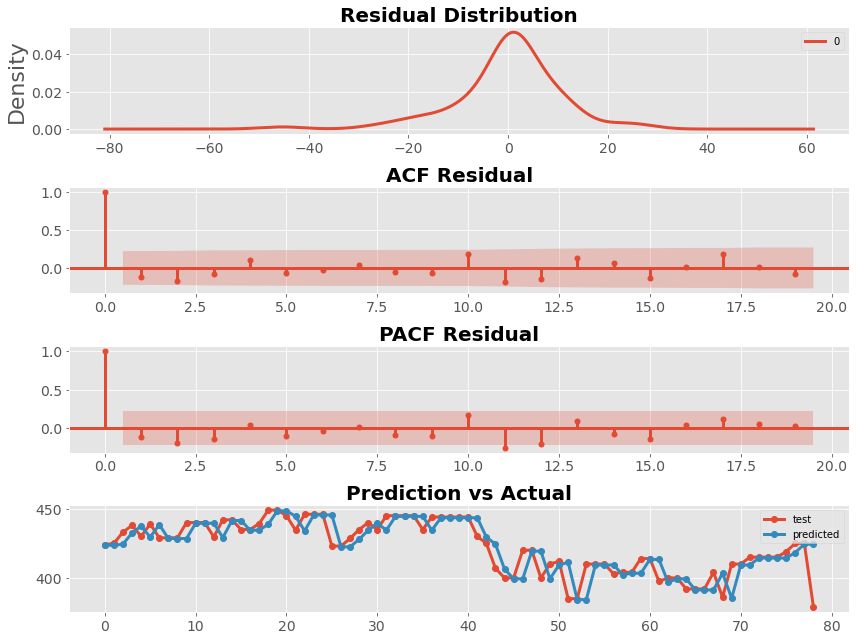

In [26]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Validate Result

In [29]:
bias = 0

### Forecast 1 week

MAE=22.408 RMSE=27.684 R2=-1.858


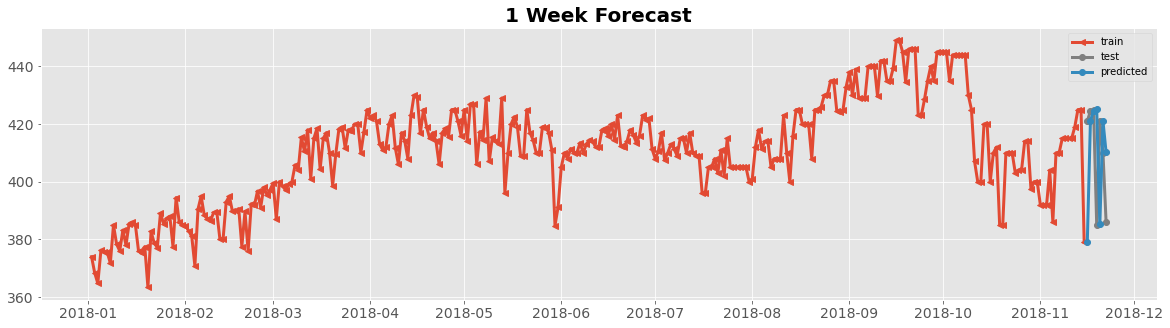

In [30]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().dropna()

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y1week.index, y, marker='o', color='gray', label='test')
plt.plot(y1week.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 2 months

MAE=10.855 RMSE=18.978 R2=-0.151


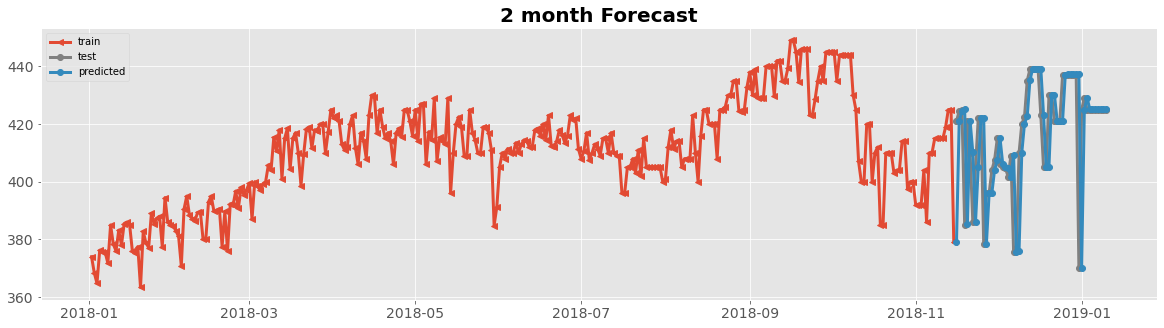

In [31]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y2mos.index, y, marker='o', color='gray', label='test')
plt.plot(y2mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 3 months

MAE=10.064 RMSE=17.239 R2=-0.147


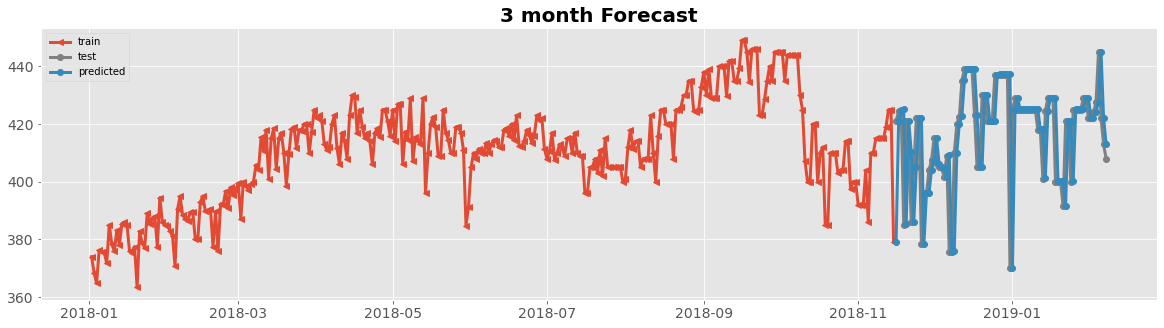

In [32]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index, train_price.values,
         marker='<', label='train')
# Test set
plt.plot(y3mos.index, y, marker='o', color='gray', label='test')
plt.plot(y3mos.index, ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

# Grid Search ARIMA Jordan 1

In [37]:
sale_price = (jordan1_uni_blue_9_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
m1 = sale_price.index >= '2018-06-01'
m2 = sale_price.index <= '2018-10-15'
train_price = sale_price.loc[m1 & m2].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-10-15'].copy()

## Raw Data

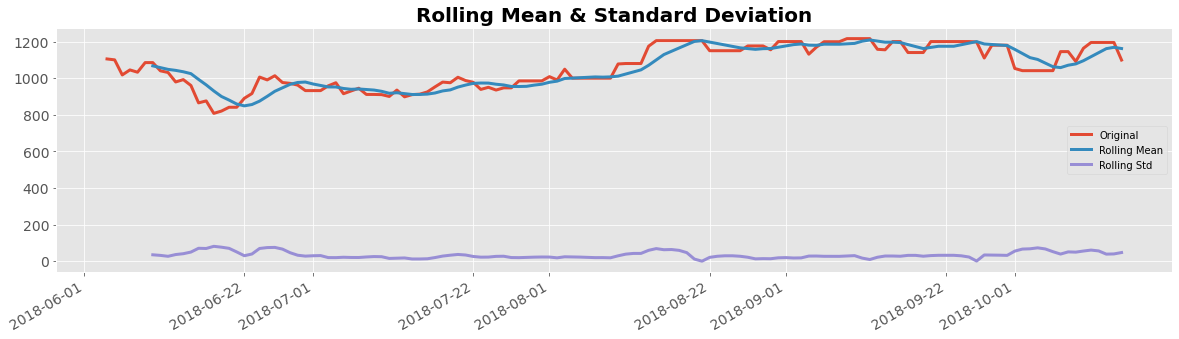

ADF Statistic: -1.8023186474728143
p-value: 0.37931115864251963
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


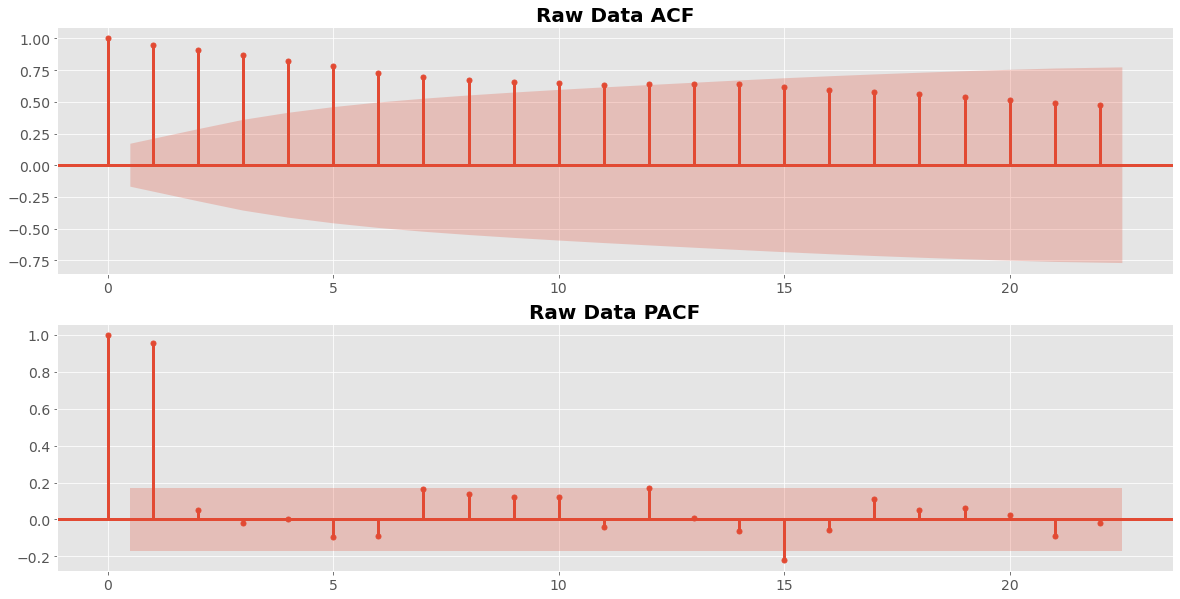

In [38]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

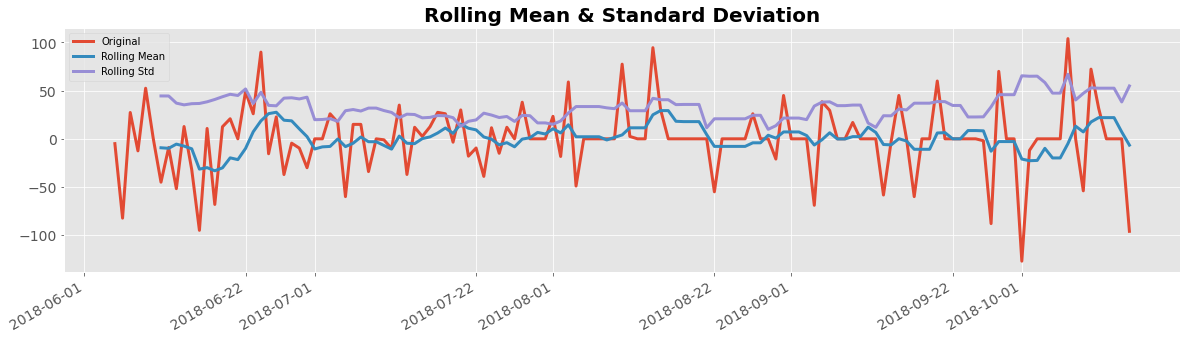

ADF Statistic: -12.136346632492122
p-value: 1.6901011266382825e-22
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


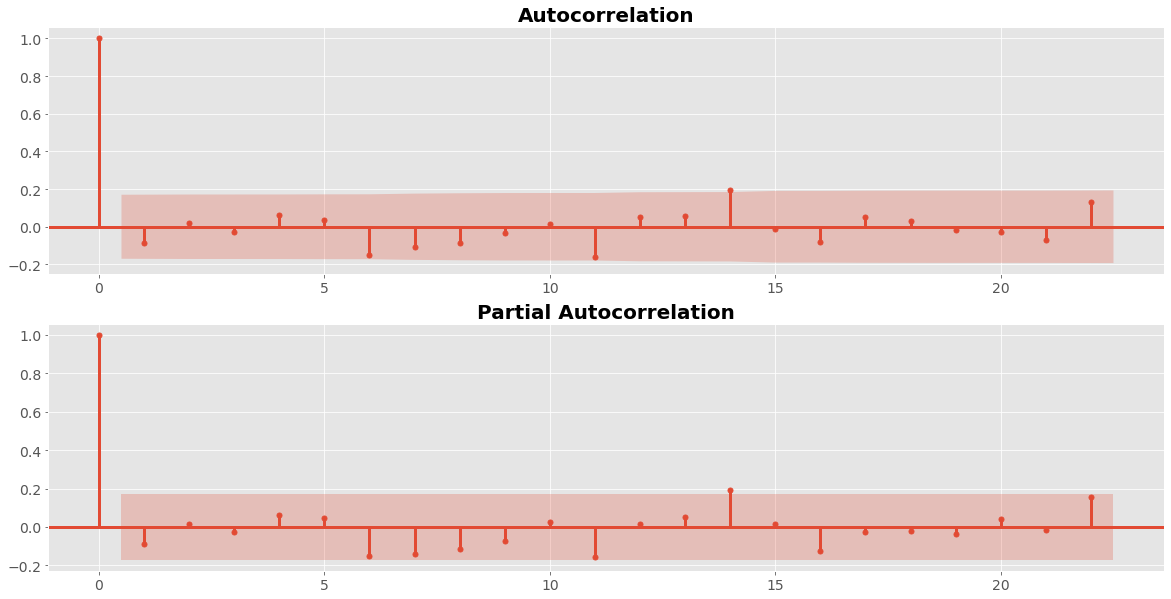

In [43]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

## LOCF Difference + Window 7

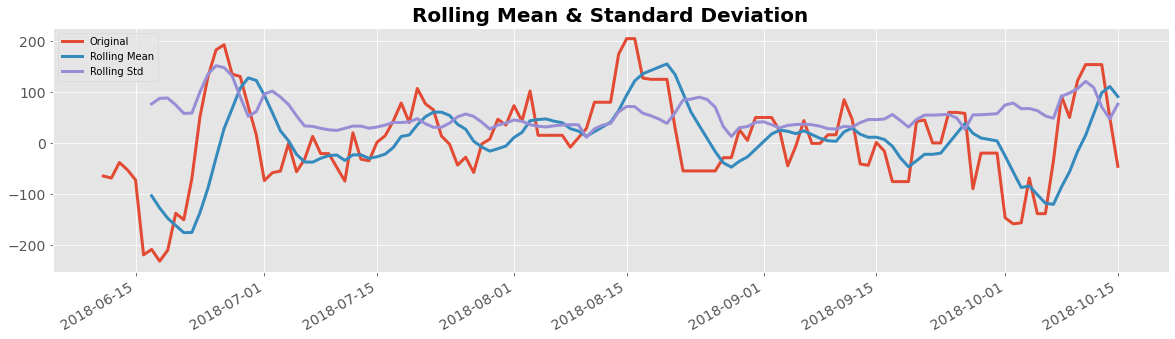

ADF Statistic: -4.106000043312957
p-value: 0.0009466419061043156
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


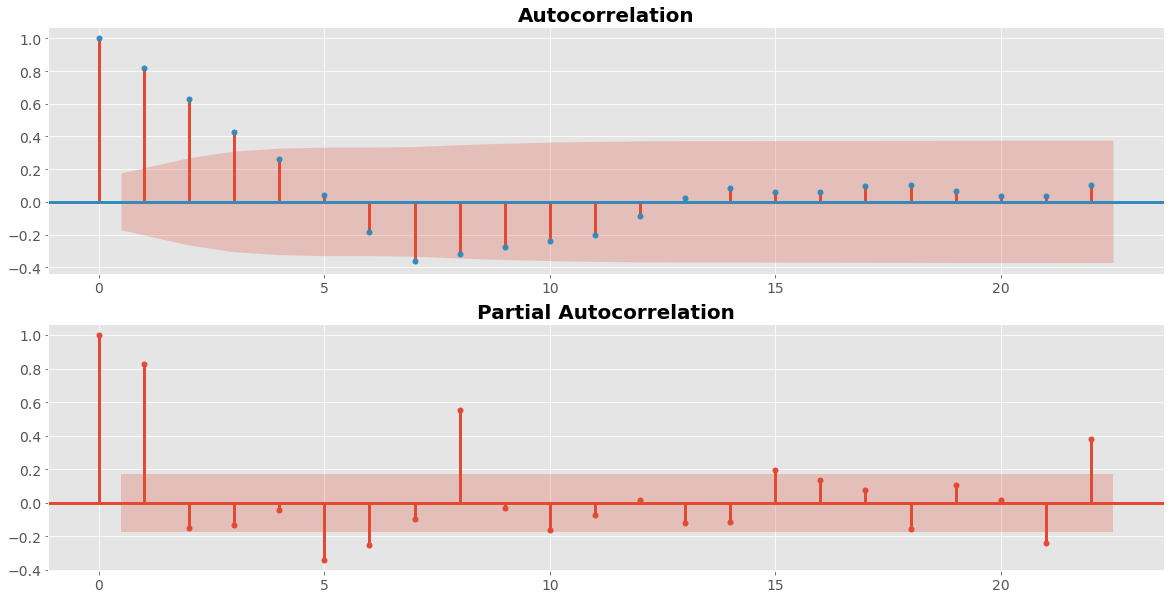

In [40]:
warnings.filterwarnings("ignore")
window = 7
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1, color='#348ABD')
plot_pacf(stationary, ax=ax2)
plt.show()

## Inspect best result

                0
count   33.000000
mean    -4.217443
std     47.142086
min   -127.641007
25%     -3.192911
50%     -0.692276
75%      0.524565
max    104.520299
MAE=27.469 RMSE=46.613 R2=0.348


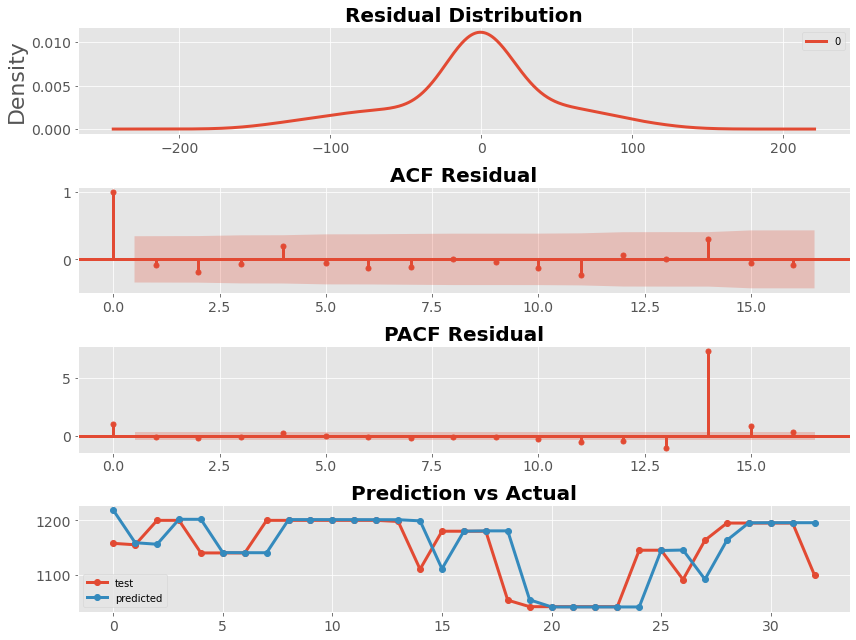

In [44]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

# Grid Search ARIMA Shifted

In [78]:
def is_stationary(timeseries, window=7):
    """Plot timeseries with rolling mean and std, cacl ADF stat"""
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # rolling statistics plot
    plt.figure(figsize=(20, 5))
    original = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolling_mean, label='Rolling Mean')
    std = plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))


# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog), (self.k_lags, self.k_diff, self.k_ma))


ARIMA.__getnewargs__ = __getnewargs__


def difference(dataset, interval=1):
    """Creates a differenced series"""
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def inverse_difference(history, yhat, interval=1):
    """Inverse Difference of yhat"""
    return yhat + history[-interval]


def evaluate_arima_model(X, arima_order, window, bias=None):
    """Evaluate ARIMA model"""
    X = X.astype('float32')
    test_size = int(len(X) * 0.25)
    train, test = X.iloc[0:-test_size], X.iloc[-test_size:]
    history = [x for x in train]
    predictions = list()
    for i in range(1, len(test)):
        diff = difference(history, window)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat += bias
        predictions.append(yhat)
        history.append(test[i])
    # Calculate out of sample error
    mae = mean_absolute_error(test[:-1], predictions)
    mse = mean_squared_error(test[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[:-1], predictions)
    return mae, rmse, r2, test[:-1], predictions


def evaluate_models(dataset, p_values, d_values, q_values, window):
    dataset = dataset.astype('float32')
    best_mae, best_rmse, best_cfg = float('inf'), float('inf'), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mae, mse, r2, test, pred = evaluate_arima_model(dataset,
                                                                    order,
                                                                    window)
                    print('ARIMA %s MAE = %.3f RMSE = %.3f R2 = %.3f' %
                          (order, mae, mse, r2))
                    if mae < best_mae:
                        best_mae, best_rmse, best_cfg = mae, mse, order
                except:
                    continue
    print('Best ARIMA %s MAE=%.3f RMSE= %.3f' % (best_cfg,
                                                 best_mae,
                                                 best_rmse))
    return best_cfg


def validate_model(test, train, model_fit, bias, arima_order, window):
    """Validate test using the fitted model of ARIMA"""
    # Make first prediction
    predictions = list()
    history = list(train.values.astype('float32'))
    y = test.values.astype('float32')
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, window)
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecast
    for i in range(2, len(y)):
        # Difference data
        diff = difference(history, window)
        # Predict
        model = ARIMA(diff, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
#         yhat = model_fit.predict(0)[0]
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, window)
        if bias is not None:
            yhat = yhat + bias
        predictions.append(yhat)
        # Observation
        history.append(y[i])
#         print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[i]))

    # Report performance
    mse = mean_squared_error(y[:-1], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y[:-1], predictions)
    mae = mean_absolute_error(y[:-1], predictions)
    return mae, rmse, r2, y[:-1], predictions

In [79]:
sale_price = (yeezy_beluga_10_new.groupby('Order Date')['Sale Price']
              .mean().sort_index())

# Train price = Jan to 1st Half Nov 2018
train_price = sale_price.loc[sale_price.index <= '2018-11-15'].copy()

# Test price = 2nd Half Nov 2018 to 1st Half Feb 2019
test_price = sale_price.loc[sale_price.index > '2018-11-15'].copy()

## Raw Data

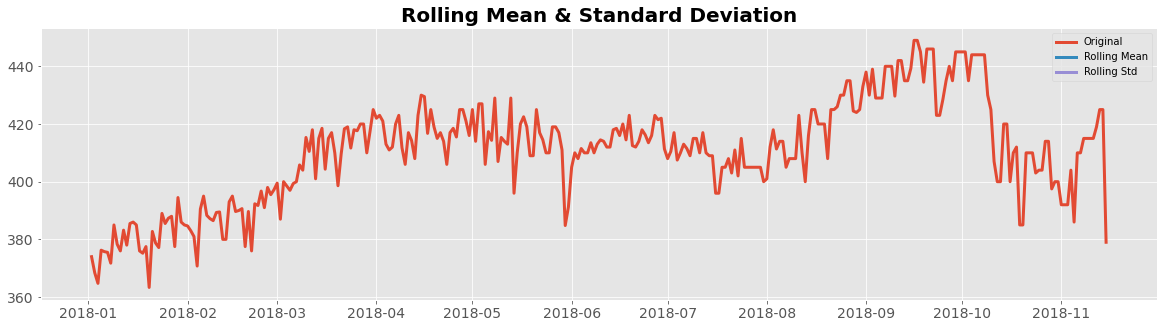

ADF Statistic: -2.6115298788689048
p-value: 0.09063761391742214
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


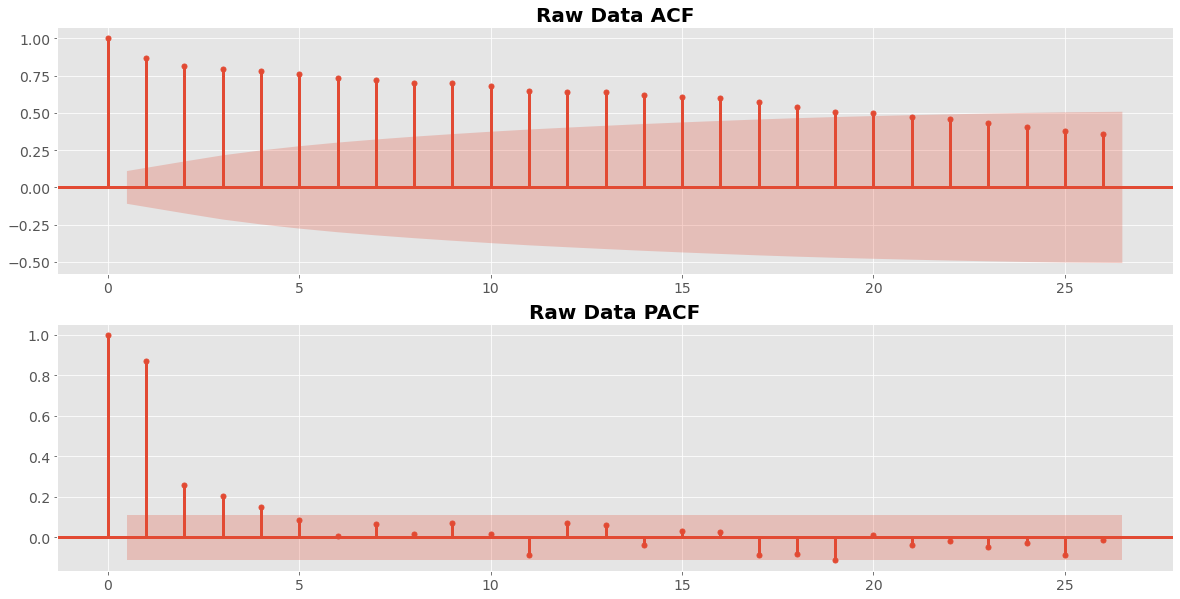

In [80]:
warnings.filterwarnings("ignore")

is_stationary(train_price, 0)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(train_price, ax=ax1,
         title='Raw Data ACF')
plot_pacf(train_price, ax=ax2,
          title='Raw Data PACF')
plt.show()

## LOCF Difference + Window 1

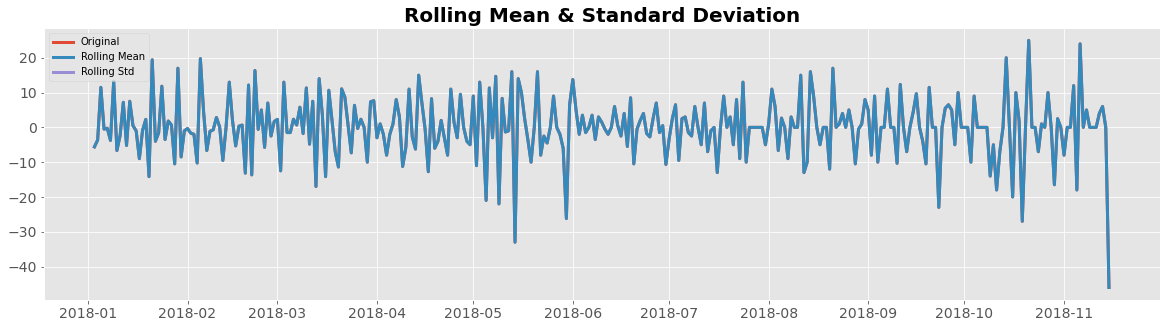

ADF Statistic: -12.47302067209256
p-value: 3.213459931884452e-23
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


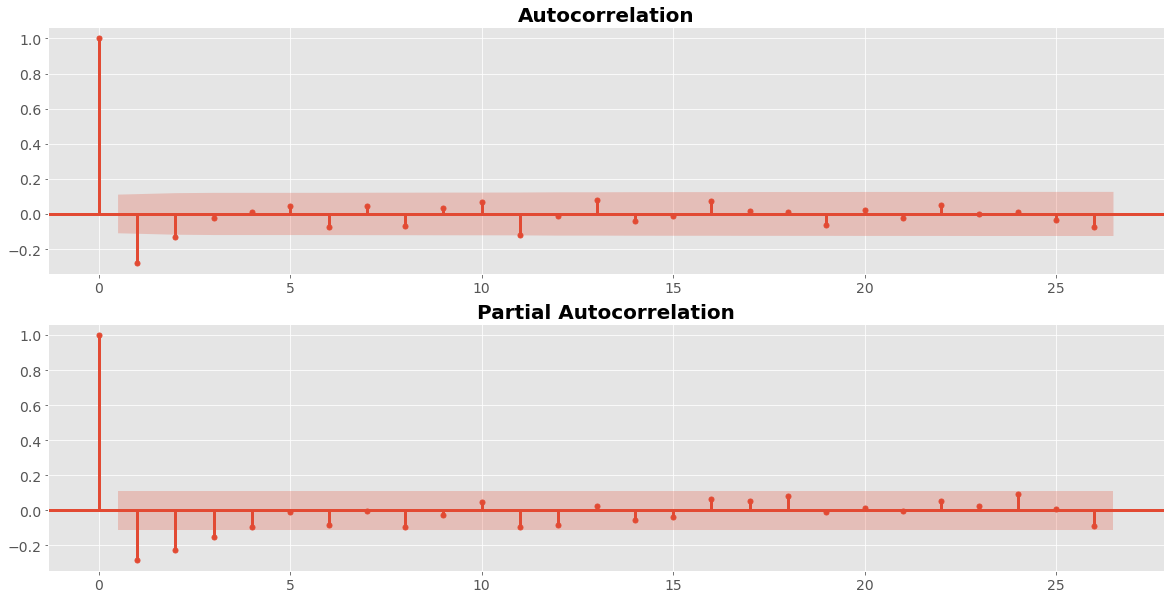

In [81]:
warnings.filterwarnings("ignore")
window = 1
stationary = difference(train_price, window)
stationary.index = train_price.index[window:]

is_stationary(stationary, window)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(stationary, ax=ax1)
plot_pacf(stationary, ax=ax2)
plt.show()

As the P-Value of the Augmented Dickey Fuller test is greater than the significant value, we cannot reject the null hypothesis which states that the data is not stationary.

In [82]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = [0, 1, 2]

best_cfg = evaluate_models(train_price, p_values, d_values, q_values, window)

ARIMA (0, 0, 1) MAE = 4.557 RMSE = 5.692 R2 = 0.900
ARIMA (0, 0, 2) MAE = 4.168 RMSE = 5.243 R2 = 0.915
ARIMA (0, 1, 1) MAE = 0.191 RMSE = 0.215 R2 = 1.000
ARIMA (0, 1, 2) MAE = 4.417 RMSE = 5.764 R2 = 0.897
ARIMA (1, 0, 0) MAE = 2.023 RMSE = 3.079 R2 = 0.971
ARIMA (1, 0, 1) MAE = 4.126 RMSE = 5.223 R2 = 0.916
ARIMA (1, 0, 2) MAE = 4.217 RMSE = 5.306 R2 = 0.913
ARIMA (1, 1, 0) MAE = 4.645 RMSE = 6.109 R2 = 0.884
ARIMA (2, 0, 0) MAE = 3.357 RMSE = 4.257 R2 = 0.944
ARIMA (2, 0, 1) MAE = 4.207 RMSE = 5.300 R2 = 0.913
ARIMA (2, 0, 2) MAE = 4.187 RMSE = 5.304 R2 = 0.913
ARIMA (2, 1, 0) MAE = 3.781 RMSE = 4.849 R2 = 0.927
ARIMA (3, 0, 0) MAE = 3.894 RMSE = 4.807 R2 = 0.928
ARIMA (3, 0, 1) MAE = 4.207 RMSE = 5.316 R2 = 0.912
ARIMA (3, 1, 0) MAE = 3.560 RMSE = 4.458 R2 = 0.938

Best ARIMA (0, 1, 1) MAE=0.191 RMSE= 0.215


## Inspect best result

               0
count  78.000000
mean   -0.191291
std     0.099368
min    -0.757088
25%    -0.255233
50%    -0.209093
75%    -0.122827
max    -0.038044
MAE=0.191 RMSE=0.215 R2=1.000


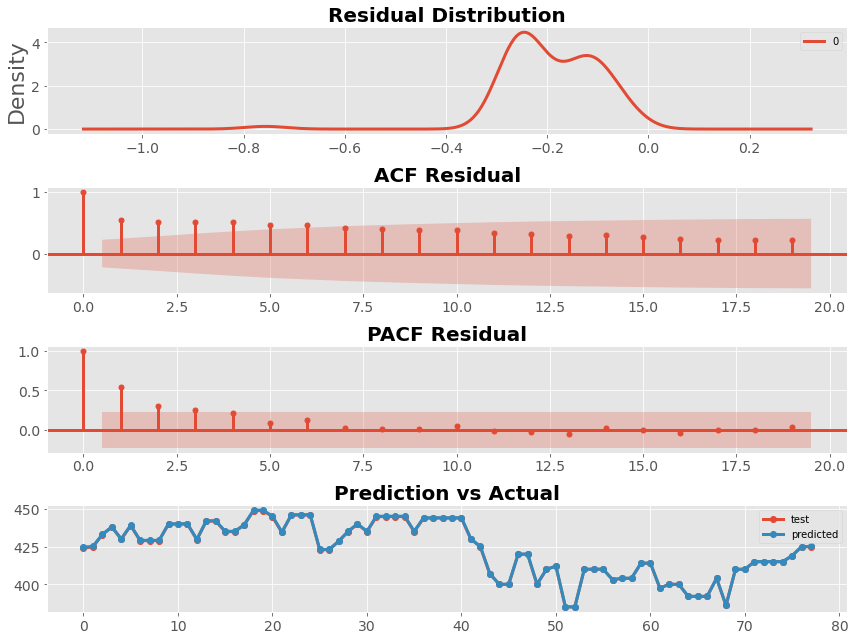

In [83]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg, window)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
bias = residuals.mean()
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Add bias based on residual error

                  0
count  7.800000e+01
mean   8.016380e-15
std    9.936806e-02
min   -5.657967e-01
25%   -6.394201e-02
50%   -1.780181e-02
75%    6.846369e-02
max    1.532475e-01
MAE=0.074 RMSE=0.099 R2=1.000


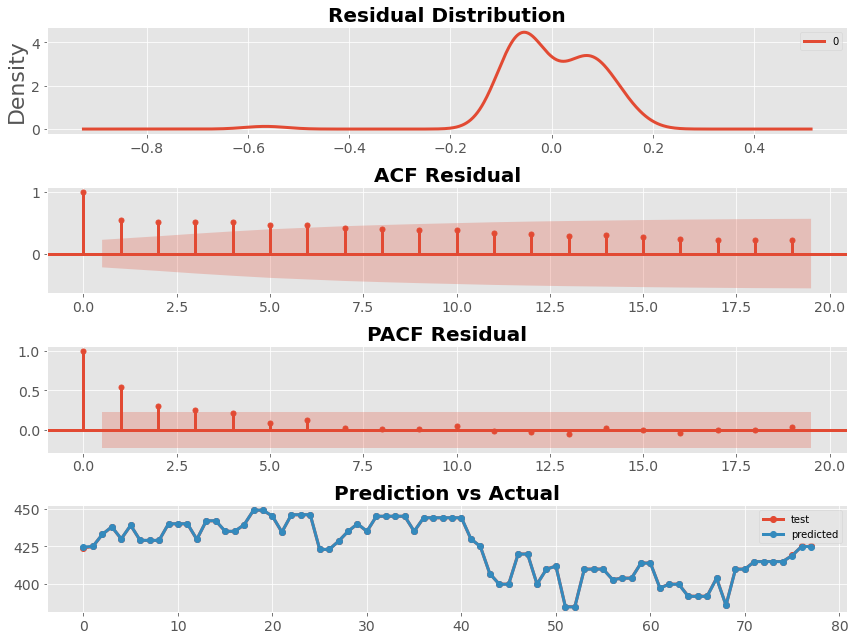

In [84]:
mae, mse, r2, y, ypred = evaluate_arima_model(train_price, best_cfg,
                                              window, bias)

residuals = pd.DataFrame([y[i] - ypred[i] for i in range(len(y))])
print(residuals.describe())
print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

fig, ax = plt.subplots(4, 1, figsize=(12, 9))

ax[0].set_title('Residual Distribution')
residuals.plot(kind='kde', ax=ax[0])

plot_acf(residuals, ax=ax[1])
ax[1].set_title('ACF Residual')

plot_pacf(residuals, ax=ax[2])
ax[2].set_title('PACF Residual')

ax[3].set_title('Prediction vs Actual')
ax[3].plot(y.values, marker='o', label='test')
ax[3].plot(ypred, marker='o', label='predicted')
ax[3].legend()

plt.tight_layout()
plt.show()

## Validate Result

### Forecast 1 week

MAE=7.664 RMSE=17.224 R2=-0.502


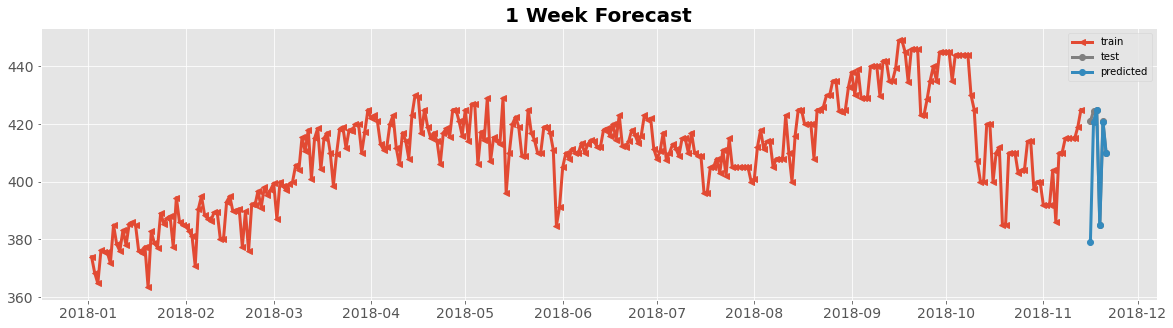

In [85]:
start = test_price.index[0]
end = start + timedelta(days=6)
y1week = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y1week, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('1 Week Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y1week.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y1week.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 2 months

MAE=0.897 RMSE=5.690 R2=0.898


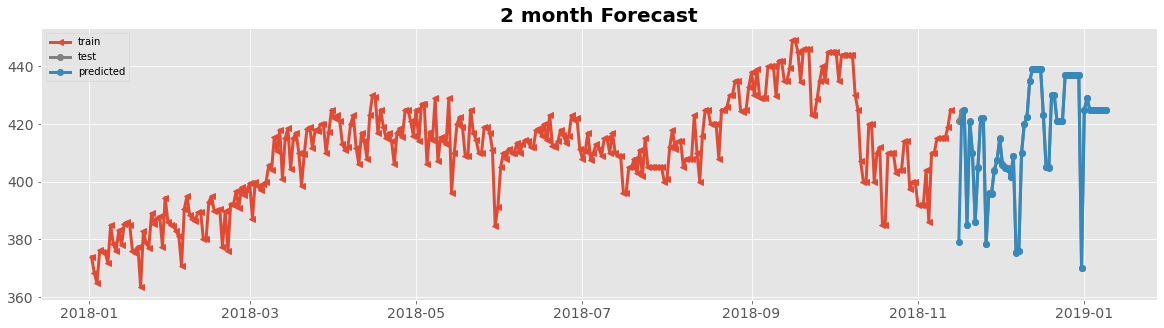

In [86]:
start = test_price.index[0]
end = start + timedelta(days=55)
y2mos = test_price.loc[start:end]
diff = difference(train_price.values.astype('float32'), window)

model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y2mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('2 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y2mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y2mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()

### Forecast 3 months

MAE=0.619 RMSE=4.632 R2=0.918


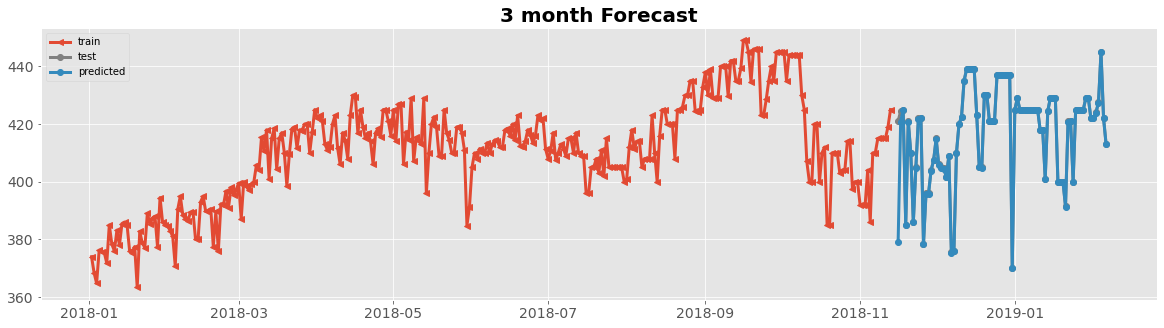

In [87]:
start = test_price.index[0]
end = start + timedelta(days=83)
y3mos = test_price.loc[start:end]

diff = difference(train_price.values.astype('float32'), window)
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=-1)
fitted = model_fit.fittedvalues + train_price.shift().values[2:]

mae, mse, r2, y, ypred = validate_model(y3mos, train_price, model_fit,
                                        bias, arima_order=best_cfg,
                                        window=window)

print('MAE=%.3f RMSE=%.3f R2=%.3f' % (mae, mse, r2))

plt.figure(figsize=(20, 5))

plt.title('3 month Forecast')

# Train set
plt.plot(train_price.index[:-2], train_price.values[:-2],
         marker='<', label='train')
# plt.plot(train_price.index[:-2], fitted, color='magenta')
# Test set
plt.plot(y3mos.index[:-1], y, marker='o', color='gray', label='test')
plt.plot(y3mos.index[:-1], ypred, marker='o',
         label='predicted')

plt.legend()
plt.show()